In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [3]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\logistic_det"

my_path = os.path.abspath(__file)

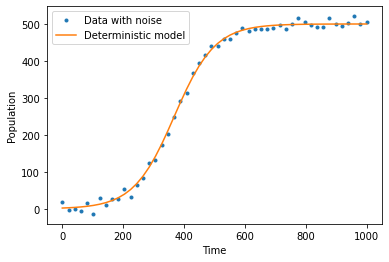

In [4]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.plot(times, values, '.', label="Data with noise")
plt.plot(times, org_values, label="Deterministic model")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
# plt.show()
plt.savefig(my_path + "./log_det_data.pdf")

In [12]:
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Running 3 chains of NUTS

In [13]:
model = toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
nuts_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)
nuts_mcmc.set_max_iterations(1000)

# Set up modest logging
nuts_mcmc.set_log_to_screen(True)
nuts_mcmc.set_log_interval(100)

np.random.seed(1)
# Run!
print('Running...')
nuts_chains = nuts_mcmc.run()
print('Done!')


Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.


d:\Part B\repos\pints\pints\toy\_logistic_model.py:74: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: overflow encountered in square
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
d:\Part B\repos\pints\pints\toy\_logistic_model.py:83: RuntimeWarning: overflow encountered in square
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp + 1)
d:\Part B\repos\pints\pints\toy\_logistic_model.py:82: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 1] = -k * exp / \
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: overflow encountered in multiply
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2


Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     3198   0.576    130     0.5      512     0.658    88       0:00.6
1     3210                    0.4      2                         0:00.6
2     3234                    0.444    4                         0:00.6
3     3237                    0.25     1                         0:00.6
100   108444  0.785    370     0.831    147     0.78     346      0:19.6
200   192105  0.771    277     0.862    38      0.813    40       0:39.3
300   216178  0.78     172     0.622    44      0.845    38       0:44.3
400   219888  0.79     37                                         0:45.0
500   223578  0.785    37                                         0:45.7
600   228120  0.863    45                                         0:46.6
700   233068  0.883    49                                         0:47.5
800   238250  0.87     52                                         0:48.7
900   243904  0.871    56                               

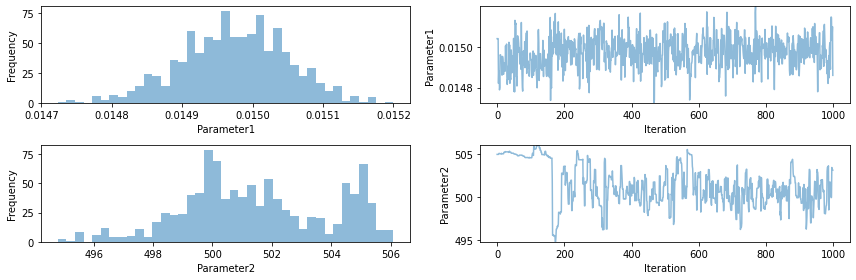

R-hat:
[1.05347907 1.31259923]


In [16]:
nuts_chains = nuts_chains

pints.plot.trace([nuts_chains[0, :]])
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat(nuts_chains))

# Creating a stochastic process

In [6]:
class ErrorLogisticModel(pints.ForwardModelS1, pints.toy.ToyModel):
    def __init__(self, initial_population=2):
        super(ErrorLogisticModel, self).__init__()
        self._model = toy.LogisticModel(initial_population)
    
    def n_parameters(self):
        return 2
    
    def simulate(self, parameters, times):
        org_values = self._model.simulate(parameters, times)
        return org_values + np.random.normal(0, noise, org_values.shape)

    def suggested_parameters(self):
        return np.array([0.1, 50])
    
    def suggested_times(self):
        return np.linspace(0, 100, 100)

In [7]:
s_model = ErrorLogisticModel()
problem = pints.SingleOutputProblem(s_model, times, values)
error_measure = pints.RootMeanSquaredError(problem)

# Running ABC Rejection

In [19]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(13)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     503    0.00198807157    0:00.1
2     2605   0.000767754319   0:00.3
3     4479   0.000669792364   0:00.4
20    21345  0.000936987585   0:01.8
40    41056  0.000974279034   0:03.4
60    59425  0.00100967606    0:04.9
80    73611  0.00108679409    0:06.0
100   93273  0.00107212162    0:07.5
120   107936  0.00111176994    0:08.7
140   120784  0.00115909392    0:09.7
160   132400  0.00120845921    0:10.6
180   145812  0.0012344663     0:11.7
200   159869  0.00125102428    0:12.8
220   174504  0.00126071609    0:13.9
240   193478  0.00124045111    0:15.3
260   205163  0.00126728504    0:16.3
280   219946  0.00127303975    0:17.5
300   234143  0.00128126828    0:18.6
320   248491  0.001287773      0:19.7
340   266446  0.00127605594    0:21.1
360   279859  0.00128636206    0:22.2
380   311428  0.00122018573    0:24.6
400   323983  0.00123463268    0:25.6
420   342257  0.00122714802    0:27.0


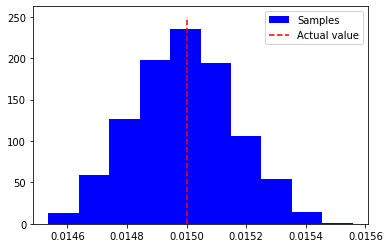

In [20]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

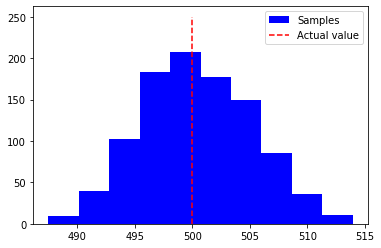

In [21]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

In [25]:
samples_abc_rej = samples_flat

[]

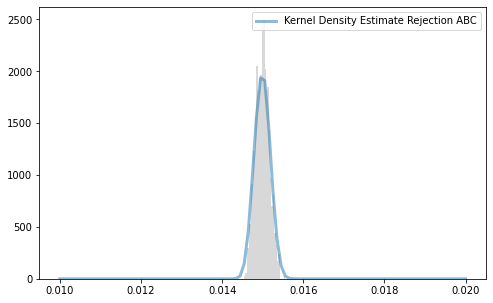

In [33]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

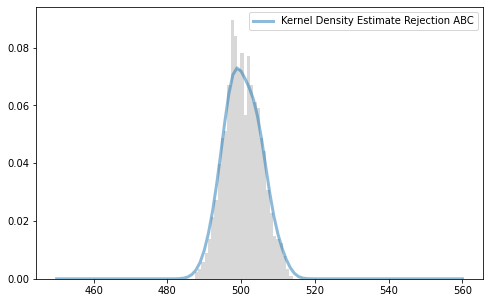

In [35]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# ABC PMC

In [36]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([20, 15, 13]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=15
Trying t=2, threshold=13
Iter. Eval. Acceptance rate Time m:s
1     63018  1.5868482e-05    1:53.1
2     63168  3.16616008e-05   1:53.5
3     63717  4.7083196e-05    1:54.7
20    67523  0.00029619537    2:03.7
40    71157  0.000562137246   2:13.0
60    74079  0.000809946139   2:20.6
80    77744  0.00102901832    2:29.4
100   81014  0.00123435456    2:36.9
120   84377  0.00142218851    2:45.0
140   87324  0.00160322477    2:51.8
160   90300  0.00177187154    2:58.6
180   92957  0.00193637919    3:04.8
200   96082  0.00208155534    3:12.0
220   99671  0.00220726189    3:20.2
240   103326  0.00232274549    3:28.9
260   106468  0.00244204831    3:39.3
280   110257  0.0025395213     3:48.6
300   114771  0.00261390072    3:59.7
320   117924  0.00271361216    4:10.0
340   122697  0.0027710539     4:28.9
360   125882  0.0028598211     4:37.0
380   128640  0.0029539801     4:44.2
400   131567  0.00304027606    4:51.6
420   13461

In [37]:
samples_pmc_true = samples

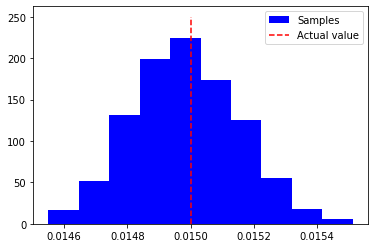

In [38]:
plt.hist(samples_pmc_true[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

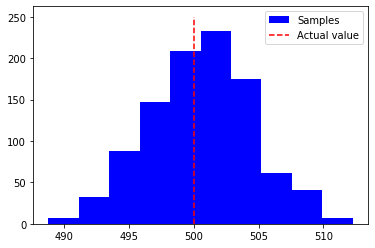

In [39]:
plt.hist(samples_pmc_true[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

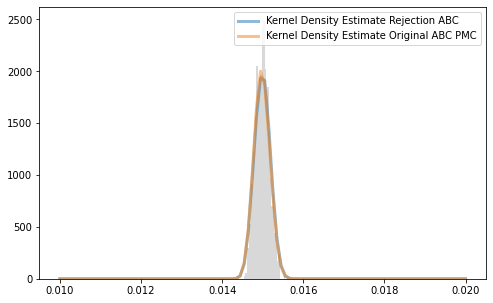

In [41]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

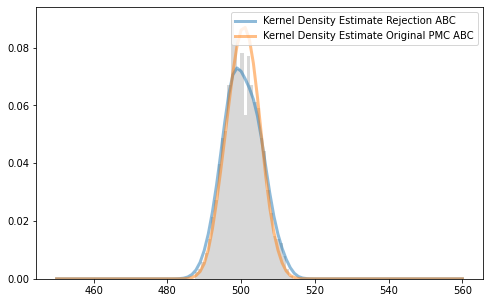

In [42]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# PMC Modified

In [40]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([20, 15, 13]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=15
Trying t=2, threshold=13
Iter. Eval. Acceptance rate Time m:s
1     12333  8.10832725e-05   0:19.7
2     12765  0.000156678418   0:20.5
3     12930  0.000232018561   0:20.7
20    15424  0.0012966805     0:25.1
40    19529  0.00204823596    0:32.1
60    22956  0.00261369577    0:37.8
80    25401  0.0031494823     0:41.8
100   28826  0.0034690904     0:47.6
120   31417  0.00381958812    0:51.9
140   33725  0.00415122313    0:56.2
160   38165  0.00419232281    1:03.7
180   40953  0.0043952824     1:10.3
200   43844  0.00456162759    1:15.2
220   47754  0.00460694392    1:24.2
240   51361  0.00467280621    1:31.3
260   56960  0.00456460674    1:42.4
280   62592  0.00447341513    1:52.4
300   66153  0.00453494173    1:58.2
320   69410  0.0046102867     2:03.8
340   73629  0.00461774573    2:11.0
360   77706  0.00463284688    2:21.0
380   82534  0.00460416313    2:29.5
400   86362  0.00463166671    2:35.6
420   90589  0.00463

In [43]:
samples_pmc_fake = samples

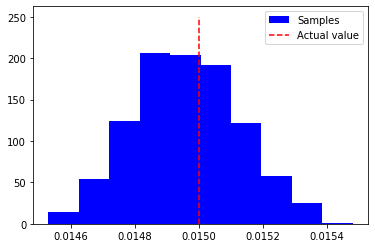

In [44]:
plt.hist(samples_pmc_fake[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

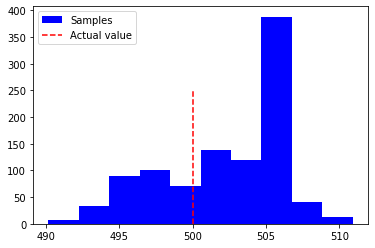

In [45]:
plt.hist(samples_pmc_fake[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

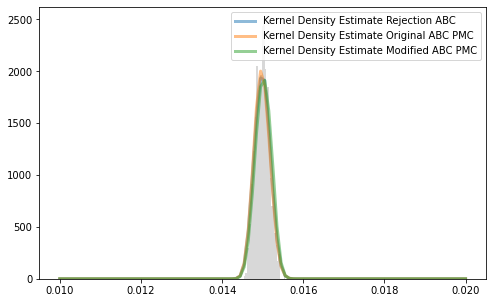

In [63]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

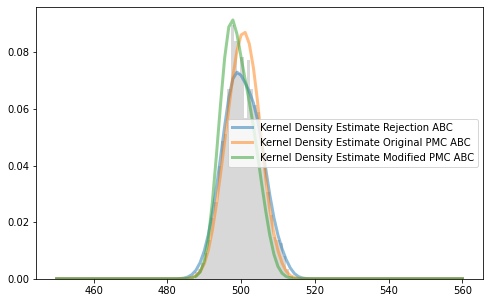

In [64]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# ABC Adaptive PMC

In [71]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(900)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[1.54588125e-02 5.08047749e+02]
resulting var=[[ 1.34415153e-05 -1.23955828e-02]
 [-1.23955828e-02  2.05697537e+03]]
epsilon=84.94175194367752
w_mean=[1.57286520e-02 5.02866089e+02]
resulting var=[[ 1.20371504e-05 -1.97532419e-02]
 [-1.97532419e-02  1.99395559e+03]]
epsilon=74.91120256490521
w_mean=[1.54718852e-02 5.03554712e+02]
resulting var=[[ 1.03586466e-05 -3.84090764e-02]
 [-3.84090764e-02  1.98895904e+03]]
epsilon=68.81644691904575
w_mean=[1.56012178e-02 5.03308792e+02]
resulting var=[[ 8.59356903e-06 -3.29454328e-02]
 [-3.29454328e-02  1.82131229e+03]]
epsilon=63.90070883253226
w_mean=[1.54310825e-02 5.03163378e+02]
resulting var=[[ 7.32262955e-06 -3.30245370e-02]
 [-3.30245370e-02  1.79811117e+03]]
epsilon=59.970892565648136
w_mean=[1.53364281e-02 5.03756163e+02]
resulting var=[[ 6.40464268e-06 -3.30158683e-02]
 [-3.30158683e-02  1.80059712e+03]]
epsilon=55.750338862839165
w_mean=[1.52700053e-02 5.03095271e+0

In [72]:
samples_adaptive = samples

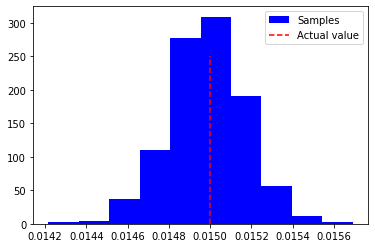

In [73]:
plt.hist(samples_adaptive[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

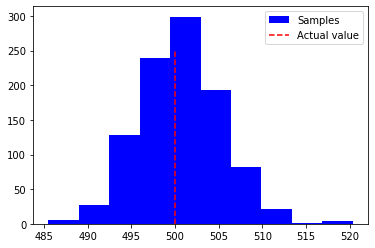

In [74]:
plt.hist(samples_adaptive[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

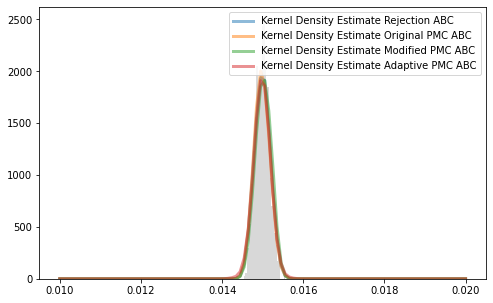

In [75]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))


ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

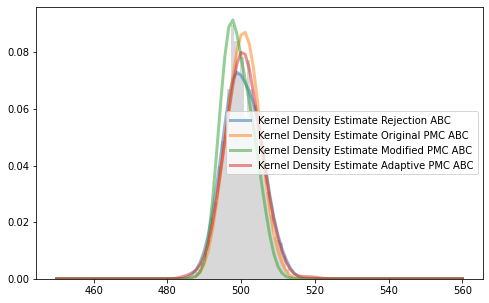

In [76]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# Hamiltonian ABC

In [11]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        
        for j in range(len(self._y)):
            for i in range(len(vals)):
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))


        rez = np.log(rez)
        return rez

In [13]:
class HABCsgld:
    def __init__(self, T, theta0, m, eps, s_eps, log_prior, sim_f, c, y):
        self._T = T
        self._theta0 = theta0
        self._dim = len(theta0)
        self._m = m
        self._eps = eps
        self._c = c
        self._cnt = 0
        self._mean = np.zeros(self._dim)
        
        # Functions
        self._log_prior = log_prior
        self._grad_prior = self.grad_pr 
        self._sim_f = sim_f
        self._cnt_samples = 0
        
        # Build synthetic likelihood
        self._synt_l = ActuallySyntheticLikelihood(y, s_eps)
        
        self._grads = []
    
    def grad_pr(self, theta):
        x, dx = self._log_prior.evaluateS1(theta)
        return dx
    
    def spsa(self, theta, d_theta, S, R):
        self._grads = None
        if (len(theta.shape) > 1):
            dim = len(theta[0])
        else:
            dim = len(theta)
        g = np.zeros(dim)
        
        for r in range(R):
            # Generate bernoulli distribution vector
            delta = np.zeros(dim)
            for i in range(dim):
                delta[i] = (2 * np.random.binomial(n=1, p=0.5) - 1)
            
            
            set_plus = None
            set_minus = None
            
            aux = 0
            
            for s in range(S):
                x_plus = self._sim_f(theta + d_theta * delta)
                x_minus = self._sim_f(theta - d_theta * delta)
                self._cnt_samples += 2
                
                if len(x_plus.shape) == 1:
                    x_plus = [[x] for x in x_plus]
                if len(x_minus.shape) == 1:
                    x_minus = [[x] for x in x_minus]
                    
                if set_plus is None:
                    set_plus = [x_plus]
                    set_minus = [x_minus]
                else:
                    set_plus.append(x_plus)
                    set_minus.append(x_minus)
            term = (self._synt_l.pdf(set_plus) - self._synt_l.pdf(set_minus)) * delta
            g += term

        g = ( 1 / (2 * d_theta * R) ) * g
        
        grad_val = self.grad_pr(theta)
        # if len(grad_val.shape) > 1:
            # grad_val = grad_val[0]
        g += np.exp(grad_val)
        
        return -g
        
    def run(self):
        # Initialize stuff
        self._results = [self._theta0]
        
        for t in range(1, self._T):
            done = False
            
            while not done:
                # Resample momentum
                
                curr_theta = self._results[t-1]
                curr_momentum = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                
                i = 0
                problem = False
                
                while not problem and i <= self._m:
                    spsa_term = self.spsa(curr_theta, 0.0001, S=2, R=2)
                    next_theta = curr_theta + self._eps * np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim)) - \
                                 (self._eps ** 2) / 2 * spsa_term
                    # print("next theta computed="+str(next_theta))
                    if self._log_prior(next_theta + 0.0001 * np.ones(self._dim)) == np.NINF \
                        or self._log_prior(next_theta - 0.0001 * np.ones(self._dim)) == np.NINF:
                        print("FAILED")
                        problem = True
                    else:
                        
    #                     print("spsa_term=" + str(spsa_term * self._eps))
    #                     print("second term=" + str(self._eps * self._C * curr_momentum))
    #                     print("third term=" + str(np.random.multivariate_normal(np.zeros(self._dim), 2 * self._eps * (self._C - self._B))))
    #                     print("next_theta="+str(next_theta))
    #                     print("next_momentum="+str(next_momentum))
                        curr_theta = next_theta
                        if self._log_prior(curr_theta) == np.NINF:
                            problem = True
                        i = i + 1
                if not problem:
                    done = True
                    self._results.append(curr_theta)
            print("t= " + str(t) + ", " + "curr_theta =" + str(curr_theta))
        
        print("count samples = "+str(self._cnt_samples))
        return self._results

In [16]:
np.random.seed(1)

y = np.array([[x] for x in values])

theta0 = np.array([0.012, 480])

def grad_prior(theta):
    x, dx = log_prior.evaluateS1(theta)
    return dx

# Simulating function
def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return s_model.simulate(theta, times)

# seed 1,  0.0005, 0.05
abc = HABCsgld(1000, theta0, 10, np.array([0.0005, 0.05]), 0.1, log_prior, sim_f, 0.001, y)

print("abc started")        

results = abc.run()

print("abc finished")
print(results)

abc started
FAILED
t= 1, curr_theta =[1.14402344e-02 4.84506673e+02]
t= 2, curr_theta =[1.13688805e-02 4.85595213e+02]
t= 3, curr_theta =[1.28912110e-02 4.93551892e+02]
t= 4, curr_theta =[1.46551525e-02 4.92217725e+02]
t= 5, curr_theta =[1.58586237e-02 4.94065774e+02]
t= 6, curr_theta =[1.43226508e-02 4.92315309e+02]
t= 7, curr_theta =[1.60024207e-02 4.99398768e+02]
t= 8, curr_theta =[1.56560143e-02 4.94683339e+02]
t= 9, curr_theta =[1.49876189e-02 4.94764310e+02]
t= 10, curr_theta =[1.43950517e-02 4.93769280e+02]
t= 11, curr_theta =[1.29577501e-02 4.88741804e+02]
t= 12, curr_theta =[1.47046272e-02 5.01108291e+02]
t= 13, curr_theta =[1.68997203e-02 4.96543076e+02]
t= 14, curr_theta =[1.52510244e-02 5.02808373e+02]
t= 15, curr_theta =[1.46454162e-02 5.03913195e+02]
t= 16, curr_theta =[1.35757798e-02 5.01733379e+02]
FAILED
t= 17, curr_theta =[1.50946494e-02 5.07799719e+02]
t= 18, curr_theta =[1.59806555e-02 5.17376466e+02]
t= 19, curr_theta =[1.57274584e-02 5.19745022e+02]
t= 20, curr_th

In [18]:
samples_hamiltonian = np.array(results)

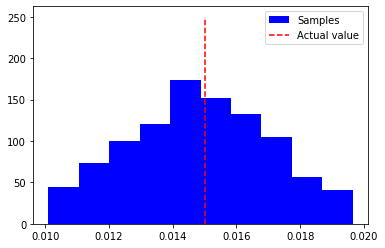

In [19]:
plt.hist(samples_hamiltonian[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

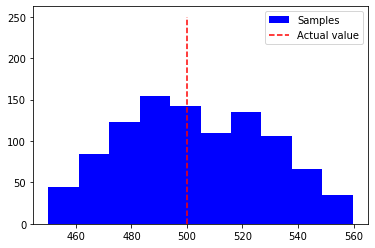

In [20]:
plt.hist(samples_hamiltonian[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

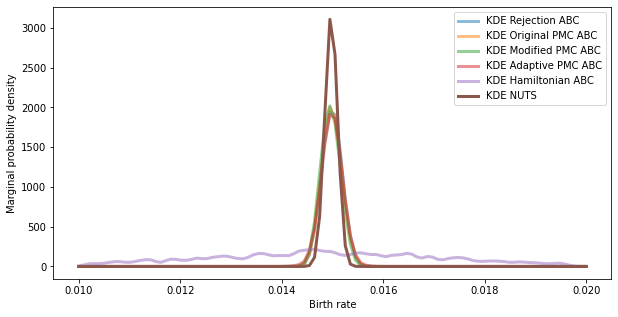

In [12]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))


ax.plot(x_grid, kde_sklearn(np.array(samples_abc)[:, 0], x_grid, bandwidth=0.0001),
            label='KDE Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='KDE Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='KDE Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.0001),
            label='KDE Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 0], x_grid, bandwidth=0.0001),
            label='KDE Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_nuts)[:, 0], x_grid, bandwidth=0.0001),
            label='KDE NUTS', linewidth=3)
# ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
# ax.plot()
plt.ylabel("Marginal probability density")
plt.xlabel("Birth rate")
plt.savefig(my_path + './logistic_det_kde_x.pdf')

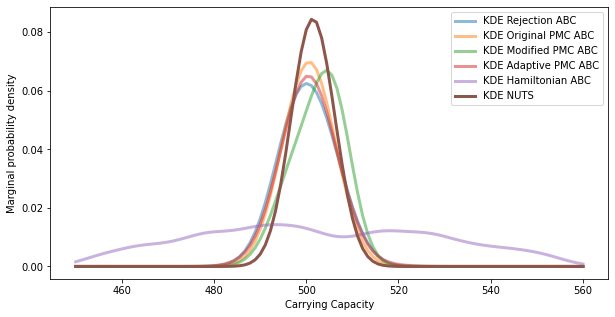

In [13]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc)[:, 1], x_grid, bandwidth=4),
            label='KDE Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=4),
            label='KDE Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=4),
            label='KDE Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=4),
            label='KDE Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 1], x_grid, bandwidth=4),
            label='KDE Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_nuts)[:, 1], x_grid, bandwidth=4),
            label='KDE NUTS', linewidth=3)
# ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
plt.ylabel("Marginal probability density")
plt.xlabel("Carrying Capacity")
# ax.plot()
plt.savefig(my_path + './logistic_det_kde_y.pdf')

# Compute KL

In [20]:
from scipy import integrate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def kl_func_x(y, kde_skl):
    part = kde_sklearn(np.array(nuts_chains[0, :])[:, 0], np.array([y]), bandwidth=0.0001)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if part == 0:
        return 0
    elif s_part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_x(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.01, 0.02)

def kl_func_y(y, kde_skl):
    part = kde_sklearn(np.array(nuts_chains[0, :])[:, 1], np.array([y]), bandwidth=2)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 450, 560)

saved_abc_rej = kl_div_x(np.array(samples_abc)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_abc)[:, 1], 4)[0]
saved_fake_pmc = kl_div_x(np.array(samples_pmc_fake)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_pmc_fake)[:, 1], 4)[0]
saved_orig_pmc = kl_div_x(np.array(samples_pmc_true)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_pmc_true)[:, 1], 4)[0]
saved_adaptive = kl_div_x(np.array(samples_adaptive)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_adaptive)[:, 1], 4)[0]

s_x = kl_div_x(np.array(samples_hamiltonian)[:, 0], 0.0001)[0] 
s_y = kl_div_y(np.array(samples_hamiltonian)[:, 1], 2)[0]
saved_hamiltonian = s_x + s_y

print("ABC REJ KL = " + str(saved_abc_rej))
print("MOD PMC KL = " + str(saved_fake_pmc))
print("ORIG PMC KL = " + str(saved_orig_pmc))
print("ADAPTIVE KL = " + str(saved_adaptive))
print("HAMILTONIAN KL = " + str(saved_hamiltonian))

ABC REJ KL = 0.5046520070219082
MOD PMC KL = 0.49479848369056867
ORIG PMC KL = 0.412671381753751
ADAPTIVE KL = 0.49776715086057477
HAMILTONIAN KL = 4.216103541821772


# Data

In [67]:
print(samples_abc_rej.tolist())

[[0.014911169714646384, 495.6026448548122], [0.014867011131772415, 508.85743240340895], [0.014896424733339662, 506.52407835279934], [0.015025145820575419, 496.68211839833276], [0.015075873333388078, 507.05592137259566], [0.015168300929265452, 493.18797123423366], [0.01491013751263277, 503.18318162269077], [0.014718343669454851, 505.6377503397744], [0.014993287702000025, 501.9639566990596], [0.014956414784113888, 503.119529261914], [0.015193678622154441, 497.50066172896317], [0.014756085210463437, 503.7966293496393], [0.015037470348970097, 499.75428323683184], [0.01518293281558746, 500.75767115778865], [0.014671509801899612, 505.2353364951725], [0.015304381094636766, 503.1710446133351], [0.01518752185269415, 498.4099162064], [0.015382035751139818, 495.10960482668673], [0.015089916185151722, 492.4294720044254], [0.015098471022718472, 499.81593372363756], [0.0151338997653141, 503.9955373648744], [0.015170221485302098, 497.50241690019106], [0.014942390761158731, 506.5868147272519], [0.0149

In [5]:
samples_abc = [[0.014911169714646384, 495.6026448548122], [0.014867011131772415, 508.85743240340895], [0.014896424733339662, 506.52407835279934], [0.015025145820575419, 496.68211839833276], [0.015075873333388078, 507.05592137259566], [0.015168300929265452, 493.18797123423366], [0.01491013751263277, 503.18318162269077], [0.014718343669454851, 505.6377503397744], [0.014993287702000025, 501.9639566990596], [0.014956414784113888, 503.119529261914], [0.015193678622154441, 497.50066172896317], [0.014756085210463437, 503.7966293496393], [0.015037470348970097, 499.75428323683184], [0.01518293281558746, 500.75767115778865], [0.014671509801899612, 505.2353364951725], [0.015304381094636766, 503.1710446133351], [0.01518752185269415, 498.4099162064], [0.015382035751139818, 495.10960482668673], [0.015089916185151722, 492.4294720044254], [0.015098471022718472, 499.81593372363756], [0.0151338997653141, 503.9955373648744], [0.015170221485302098, 497.50241690019106], [0.014942390761158731, 506.5868147272519], [0.014929744071308353, 503.1238569618133], [0.014752311763805932, 511.1277597298223], [0.014890226964947496, 495.5934663052995], [0.014795765986973224, 507.1167052915098], [0.014915712962487736, 510.64781030240226], [0.015164273257048966, 492.5760449345388], [0.014881493290559388, 501.476618076309], [0.015144852010665335, 492.09472265673514], [0.01514457459061078, 499.0197404791947], [0.014990575885795988, 500.1504814772796], [0.014752803854580873, 506.02556024876327], [0.014920334526103802, 500.09498810576304], [0.014872569168802509, 500.3866824743269], [0.015106185745907993, 498.99850013095795], [0.01520633789177339, 499.0308945743124], [0.015258794813695308, 492.7719476114089], [0.015183669349845146, 489.75053312391924], [0.01526852816314213, 497.7388075557032], [0.014861451345161078, 503.32514563936553], [0.01507308103970699, 499.0728511098337], [0.015153670348751952, 493.6223977513212], [0.015077914985358513, 496.53794069791104], [0.015077038697636894, 494.6440482311583], [0.014777713616635033, 498.4847940878335], [0.014963391931111762, 502.8594080456579], [0.01489833973147717, 507.0218602935103], [0.014672709484920683, 498.7887452393955], [0.014979960704406757, 502.8708559005003], [0.014830104829574387, 501.6884297356778], [0.015018595285566498, 507.7572841584936], [0.014818287618354022, 497.3752301553868], [0.01479171040151252, 500.5818071483051], [0.015030416254700052, 504.68883444403036], [0.014955343494274116, 506.0918990394828], [0.014948726182573549, 503.0986216178766], [0.014838376355372546, 506.59307438041304], [0.015019699111258063, 502.4369556822012], [0.014754395352014242, 500.17265097699544], [0.015090947207355907, 500.9391398955181], [0.01498557933941749, 497.7430575140717], [0.015079829835988311, 502.2397087197661], [0.01473121930230473, 500.2796844434762], [0.014946756257868732, 502.11576867624854], [0.015040705179431648, 496.5777258661849], [0.014949494607567053, 489.99439885473], [0.014826162860988338, 503.36963709313034], [0.01497616970664714, 496.4898256510601], [0.015097578156911325, 496.81809650344564], [0.01491984413658268, 502.541978068842], [0.015000974419598127, 493.8616084695869], [0.015288356265992833, 498.4138745678618], [0.015392410398698863, 498.54273551275844], [0.015007346474843137, 502.7551679329295], [0.015081826629735772, 495.58361224228753], [0.015059752788136493, 495.2881487082452], [0.014898404060786366, 504.34729220246226], [0.014845121184411423, 508.54817099371064], [0.015025713680659462, 499.5595426716267], [0.01527581673276885, 503.2813885778229], [0.014910139646863484, 496.5110644131529], [0.014841779964667047, 505.25570629116066], [0.015020939475510187, 498.2775751803781], [0.015046205330902505, 505.42600590504725], [0.015284610426590343, 502.3503556013541], [0.015107543931807112, 500.3573118692244], [0.015060008654082038, 496.7360911043984], [0.014854669855887275, 509.8318517211954], [0.01521151974977257, 505.0223465114346], [0.01467994583917687, 511.53898279686695], [0.01535207487877157, 499.2685689335979], [0.014652173518352855, 507.9872469502499], [0.014873207798920728, 500.01909479963035], [0.015102567681935661, 503.4515195734234], [0.014798737160398173, 505.4096902915992], [0.015078919094864947, 498.05262822532524], [0.014844946883529206, 496.4387330566378], [0.01509998346452487, 501.8567832255364], [0.015000989465626533, 501.86320474675733], [0.014820453676821645, 502.15470225406386], [0.014931988063400497, 500.28473935521566], [0.015091255221159252, 495.34253861015594], [0.014813269660760544, 491.6286237500184], [0.015043197016515113, 500.9718213902675], [0.014629258420312746, 506.0671239026925], [0.014856033867591286, 506.25619015029423], [0.014988751882157595, 497.6415451584703], [0.01490141535608075, 504.53638950486516], [0.01537337024420133, 501.4236487067324], [0.01497712518006193, 497.38600573642674], [0.014929269803775107, 504.5831544781048], [0.01488411255612508, 499.0127480900919], [0.014718360862070417, 504.48313434661725], [0.014984962118315459, 497.45316768566187], [0.01505287811681522, 497.6893180662546], [0.015009577921104907, 496.3782983455321], [0.015026570796621737, 493.94161600678086], [0.015309461699755557, 496.6281766710256], [0.014831022582767684, 504.125492487178], [0.014982779344573031, 511.55546577871826], [0.014997740116952695, 493.17893187481695], [0.015024200939882722, 495.8560949821304], [0.01500412588659241, 501.90624278972496], [0.014947588927524187, 500.7578013213806], [0.01474994540919983, 504.5459119583442], [0.015321735656108958, 491.48493771575295], [0.01524044152837772, 502.4271379807616], [0.014610012501694426, 496.9542268392298], [0.015078407104079096, 492.83414073979225], [0.014920873989445384, 498.7962791656238], [0.014917868547339303, 498.29754834295494], [0.015109965264979671, 504.6479899780471], [0.014993171990567924, 491.09434480895777], [0.015053811663289392, 502.03529008954246], [0.015027218247492858, 500.117420583573], [0.01495239534617128, 505.0277651744626], [0.015283839015499363, 497.43600500645005], [0.015023398943287546, 504.1473885108952], [0.015108405782501885, 498.22865675949686], [0.015046050277458981, 502.77178787999486], [0.015180718786318582, 504.77193485075543], [0.014940305072131862, 504.13662021436767], [0.014855485801092989, 501.2800228615991], [0.014959389244769205, 499.95223733185617], [0.015041830811048915, 506.5788144718883], [0.014940283129713055, 503.37716188940317], [0.015162210933563108, 502.4280488126943], [0.01507023506437755, 495.7467880675308], [0.014863976852141384, 507.60744250746075], [0.015068868149097499, 502.1654860088679], [0.014924500907298716, 504.6563593701384], [0.014840236963348252, 496.17763987869085], [0.015076325958537907, 495.2029159813344], [0.015085665890801025, 497.1345849329646], [0.015015709774061222, 500.2941156493538], [0.014640651101697485, 498.2819712190284], [0.014980146565858516, 495.34321203483324], [0.014985107272765624, 498.66489051437225], [0.015141235379653189, 505.0236776956474], [0.014978519855393727, 496.69780222383656], [0.015128896719458709, 492.019096352164], [0.015032532305409865, 503.3736798214295], [0.015119540726633789, 494.24091852395117], [0.015254945401571574, 503.9227564570552], [0.015102379857366257, 494.25000500278503], [0.014868900410374693, 509.4068493632957], [0.014961482534905882, 496.052567988503], [0.015056935887012159, 495.0136006513803], [0.014868016896283621, 501.2189243295909], [0.014931368997344445, 497.4631384921704], [0.014985079544452027, 499.8873941710585], [0.014826811227651504, 502.4268289567345], [0.014716907217657303, 499.42761666059687], [0.014921819029421086, 505.36706149584893], [0.014820660715139874, 509.6887987814248], [0.014832401154114104, 504.22071661076666], [0.014870633197654234, 498.85540935940776], [0.015074032236448338, 499.84450413306274], [0.014789481585125823, 504.662163995332], [0.014988707050606195, 500.43886707175534], [0.015064438574068275, 496.6965154988864], [0.015133841482392291, 501.34882316405304], [0.01504953776890057, 506.8908152758788], [0.015035264408579514, 499.0702118760971], [0.014902984732675068, 501.24875551660335], [0.014877287855460424, 496.4849487349098], [0.014819734212918805, 499.39405594413387], [0.01479973608603412, 498.44365235232533], [0.015022986733473402, 504.9972380004325], [0.015019027952017833, 502.85438755307916], [0.014855215577907728, 502.848180429095], [0.014929237886597443, 503.9921786052137], [0.015075241847393228, 505.3517464123996], [0.014958591265050409, 501.5967289558175], [0.014609554284740924, 503.0202775612606], [0.015020914524618286, 502.5825705300875], [0.015104114728588742, 499.95794488659584], [0.014834488970975224, 502.0100844405492], [0.015058052042211393, 497.0024822894553], [0.015162586576633694, 491.0921910854302], [0.015135668124587597, 498.47154780763583], [0.014792546944788938, 499.757252369925], [0.01494440240892053, 504.44548936560636], [0.014902195721774598, 499.51577497298075], [0.01510768533132448, 504.5507773366621], [0.015144689142307873, 496.9957912559366], [0.014983062195482687, 496.609605256352], [0.014877874255043038, 510.72169974502344], [0.015270180633933815, 506.7809539922982], [0.015166472435545263, 498.8186235545481], [0.014735151739046184, 507.30692743234414], [0.01476398980799399, 502.6135152410539], [0.014614874705781617, 513.9460156265759], [0.014944728337696809, 499.37741543298404], [0.014868304890182264, 500.17598482461494], [0.014902239025685687, 499.54756193542016], [0.014855824701863096, 511.7259488465774], [0.01493338101329886, 498.88863601681953], [0.014830543174283747, 498.33999461094453], [0.01502263634980833, 497.07423428099867], [0.014910652265671955, 505.6505227554266], [0.015298080147707034, 490.2350594028679], [0.015044732209112888, 500.25183615857736], [0.014944080839388148, 511.7159229918669], [0.014867523483907102, 492.14205853006126], [0.015025512331951412, 501.22779134056503], [0.014620535763451546, 513.0099217030239], [0.014911246641083922, 501.1542985865702], [0.015289920045986234, 494.50057602042784], [0.014854827151749832, 498.48337156163603], [0.014901472633650967, 500.7932661751934], [0.015136043794532907, 499.4303359474097], [0.01517941308738443, 504.4252768371783], [0.015101446471606612, 492.70689733721514], [0.015067850980589166, 494.602789144751], [0.015021105166321408, 498.31320095685834], [0.014999714253467314, 500.4090022381148], [0.015295232185271318, 495.87096415260766], [0.014894675847430379, 503.8625523091665], [0.014971561827098235, 508.7344673310014], [0.015192930367388379, 501.6985637825564], [0.015175991000595817, 498.916576892535], [0.01528375988285182, 494.2597170611002], [0.01507121079101022, 497.7850795966567], [0.01481279972741424, 500.7501409313514], [0.014936770312282062, 503.8418502341592], [0.015313141326886003, 493.9988738521172], [0.014958364590722802, 497.9674544710239], [0.014976078243668523, 504.07652828429076], [0.015132964969014489, 503.20854939513083], [0.01492834116886279, 502.45885213180065], [0.014956131411333992, 497.5683015720485], [0.014840391286605335, 501.54081859850413], [0.015181962290936605, 500.2437652732058], [0.015156505054924555, 502.8912271421052], [0.01479238420297491, 499.93600290010727], [0.014891130400836096, 508.6655140758206], [0.015139215797613608, 494.328013354812], [0.014964204540869393, 502.82899727915475], [0.014759246554283416, 504.4013446565941], [0.014855996425345106, 500.74176287184275], [0.015199633199556615, 501.3747010289449], [0.014830107640503364, 501.75541386076446], [0.014853307534735353, 495.5558364600275], [0.015337579490873665, 490.88655822852144], [0.015035138729821172, 504.2246996694712], [0.014852179861741963, 508.68623160348864], [0.015001131041139943, 497.2868067735426], [0.01497605308818439, 502.0253689890636], [0.014894315445261225, 504.2259303118485], [0.01527107696261372, 495.42357988513294], [0.015043249011983922, 507.88471085198813], [0.015089295461438633, 497.74519243894326], [0.01506985729776841, 500.0313656541281], [0.015169339910651895, 494.3319276123496], [0.014625086544895315, 498.86211980158185], [0.014937964861017592, 497.99287555252124], [0.014861951464576629, 510.8980318191245], [0.01515612361786724, 497.5355219065508], [0.015137367154558407, 497.0049565005846], [0.015030199382241607, 504.2332896852693], [0.014706919631589061, 500.2266446163158], [0.01527585295558331, 494.8125500950296], [0.014918891737484114, 503.7463287038405], [0.015064546501423082, 500.16464432072723], [0.015063354651908025, 497.3479072117987], [0.014992796087674277, 500.52029059807404], [0.014892593627808266, 503.6492395507443], [0.014834857807596986, 500.11920936607487], [0.015056939016625605, 503.01697024423135], [0.015225263521656686, 504.5317851146019], [0.015222402047799597, 497.3710201392987], [0.01494295461497503, 498.2483552492509], [0.014708834945224875, 498.5748850507937], [0.014707526244549362, 505.1082195377907], [0.015128692620276014, 505.51788361157276], [0.01492489123582948, 497.1111151612321], [0.015074441014922859, 502.6165850849851], [0.015124029014465166, 501.4351032734488], [0.014661847484625217, 505.9465710013622], [0.015108409018747038, 498.42741182509985], [0.015196188944572336, 502.074940565021], [0.0149653638576033, 504.6510625876949], [0.01453608340803595, 506.113257094156], [0.014840522944597036, 501.55074256442066], [0.014797801951676062, 506.77859068091584], [0.015014491356468432, 495.64343191053365], [0.01500371937798424, 504.62965073702935], [0.015041884049326722, 503.03195594584463], [0.015091477919768812, 498.4087690213482], [0.014896491727016, 494.8600527749738], [0.014794108674875808, 511.0236522385077], [0.015095334139490438, 497.4128759765105], [0.014989455286993057, 499.6378052680946], [0.015119456138214398, 492.07429065351215], [0.01555792233615385, 488.72148793988623], [0.015400385795682883, 498.4833734834241], [0.015103606743372858, 491.0472470658969], [0.0150240297573732, 491.9616166749817], [0.015052947243391714, 506.13049194143633], [0.015276230590205556, 494.5726020470127], [0.014919580452361242, 496.8263936316921], [0.014852564082624555, 499.27520180592205], [0.014798356076966866, 505.4088813298328], [0.015149512054143867, 503.67963653754174], [0.015022318127278752, 496.0715001227641], [0.014688077176046718, 497.56235340720906], [0.015086989096403707, 506.8150295045326], [0.014844882999678477, 499.92508298453424], [0.014896073436240888, 502.72684004019266], [0.015140637124867271, 503.74344900344596], [0.014901261310182216, 503.4630527949471], [0.014696830157103217, 507.0671279796296], [0.0150099524055353, 497.6085654902107], [0.015303605311633935, 494.33708191781415], [0.015058842962257575, 502.50766305333633], [0.015148776043930183, 503.06830035245207], [0.015097826481829247, 492.6737121677551], [0.01497274915657812, 498.61644157811287], [0.015214618362101504, 505.1595611478761], [0.014764053062035092, 502.20867728490816], [0.014983751922247022, 504.17290382413154], [0.015110905303035608, 497.488384836618], [0.015141463793413915, 499.7517787839294], [0.01488374054702104, 498.36580049466], [0.015001344835034684, 500.4697398290831], [0.015353132974779481, 498.35625442799295], [0.01512158856343392, 508.86023871336783], [0.014723760761255601, 504.06767783824637], [0.0148063082748306, 508.4434463665693], [0.014858944211180128, 506.4161256213595], [0.015122285429594491, 497.5465338536034], [0.01491463482252995, 495.1409566631326], [0.015148859865841535, 499.24218740163025], [0.015084812974237603, 506.2059950070508], [0.015097501403245527, 498.1994205262925], [0.014984701441167774, 509.2564772353536], [0.014990222813747327, 499.501150564766], [0.015045305566882744, 501.4795032295805], [0.015113768572648307, 493.86276891170724], [0.01511994948788321, 500.8856912660639], [0.014885966252371138, 501.9598140689599], [0.015042887249735267, 495.10660041035453], [0.015316050670430646, 496.4465967572542], [0.015008816767304905, 497.7899616254642], [0.015125301019008094, 506.60476397368], [0.015039417818672164, 503.20878699470086], [0.014980776878986506, 502.8539443239143], [0.014908259982239241, 500.2557751907652], [0.014800965870574955, 500.87766282578605], [0.015108267174472782, 496.5047061270652], [0.015094811981706969, 497.0463100002596], [0.014830150953877599, 498.3160782910135], [0.014997724693557622, 500.0590835037565], [0.014951680866213384, 510.83367795187553], [0.014786864603007023, 493.85750160326756], [0.014902089258177962, 507.0630436787287], [0.015013731446934105, 497.95697726896515], [0.014977030869751313, 510.2120898781561], [0.014968677614308649, 497.94553240280254], [0.014903252209385948, 499.24214876550406], [0.014822577258600608, 499.11064986454073], [0.015040490661854932, 509.8589624740582], [0.01475031024281778, 495.8637635657213], [0.014907239318870683, 509.5216511425103], [0.014755219729447738, 498.0624565592932], [0.014828120040273557, 498.8425124936199], [0.01492718401505127, 501.2485728752489], [0.014894487586658178, 501.3043008801637], [0.01499121794061365, 506.984853546122], [0.014748505430309571, 494.6005057730943], [0.015252088738708133, 492.7513100028705], [0.014939000520962253, 500.9633308788269], [0.015105983321318964, 497.32369201678387], [0.014682400567495348, 498.06595397557487], [0.015266369028041972, 493.9765235242734], [0.015085143027650873, 500.35881820556756], [0.015050910051437195, 503.50881172590056], [0.015081600797181939, 496.88457270310266], [0.014685321959356594, 507.21855373309734], [0.014732536661729138, 498.3160262016947], [0.015189516753804668, 499.0528675389146], [0.01505118635802969, 498.7033808770842], [0.01513893736341666, 497.67851017604806], [0.015010910617175762, 498.9654464649474], [0.014979396632377823, 501.1910129408555], [0.014991179085252928, 493.98293415951304], [0.014870397697837306, 503.05168618335927], [0.015153892255418173, 497.29450832945565], [0.015094400902453108, 499.02534421939373], [0.01464194312553804, 505.67017874233596], [0.014717670070383451, 505.5480019996472], [0.014956285757615186, 495.6254859546155], [0.015042457973850853, 494.15306403055246], [0.01478384687238931, 506.0507083698824], [0.015044430929666383, 502.4283894538099], [0.015137432610093803, 499.3687389533766], [0.014875894729138028, 504.3171538591984], [0.014822570802676401, 498.1095078909405], [0.01475558995052837, 509.50606597122044], [0.015143269736605684, 500.6855730497242], [0.01506967563281557, 500.261942353398], [0.01462513620322645, 495.2113331636492], [0.014951254516756912, 503.1569074138186], [0.015161974233224955, 506.25945307656565], [0.01484650771692739, 501.45994040434687], [0.014895346198447686, 506.4073718160535], [0.015028513428537943, 498.2846445788084], [0.014921243543052966, 495.0650653376906], [0.014858778401095944, 505.87245874682367], [0.015041320777910271, 495.19633835789534], [0.01502209731224588, 505.1377337135606], [0.015080912586731436, 497.1764303822399], [0.015218996087137572, 496.39355951594956], [0.014982422229132755, 499.28527152551544], [0.014619933619539267, 499.08292985067203], [0.015024735712567986, 502.2129375873244], [0.014923788972001063, 503.67374440428097], [0.015185236943720641, 497.36171064047073], [0.015226267609218361, 495.4828818916619], [0.014732178058529999, 498.4931519889255], [0.01516149865661768, 495.9440329649075], [0.015033099366977446, 501.92977277464036], [0.014969830191672147, 503.56321755883147], [0.01485633094196355, 510.1338008259275], [0.014884617266307361, 494.1649765132708], [0.01506368946827371, 503.83746925573814], [0.01489708974700028, 503.312331447017], [0.015043998256137378, 503.01185962793573], [0.015253523887248986, 510.8522874036236], [0.015366501974400846, 497.6104375321761], [0.014734946901308613, 510.1581276593951], [0.0152012140478743, 502.98077936468246], [0.015074231429786207, 497.91446216200865], [0.015061165344257669, 500.93400514792427], [0.014776793302644177, 497.2622511227613], [0.014875372108941836, 502.6096056945891], [0.015198606371496129, 487.7993404056005], [0.01501121233884924, 499.52055795992555], [0.014841937173482868, 510.2971884135031], [0.015057286958403292, 505.1142272394885], [0.014710114498209546, 507.8826244580123], [0.014667281671331005, 507.21064807303395], [0.015138889690815269, 496.4659674595041], [0.01475783740274314, 497.46536949389053], [0.015205883114605464, 497.2130932810543], [0.015161412055063736, 500.1367592688183], [0.015167535710261162, 491.8949910164594], [0.014974664253771645, 497.4756850580206], [0.014819826475079982, 496.04831420171865], [0.01504544561860081, 499.07298126814425], [0.015118282208986509, 507.95492783953887], [0.01513155249931308, 494.40309348683445], [0.015044093132416194, 492.79102303297554], [0.014818105579403416, 503.24713934263974], [0.014776853280292875, 506.0960792220927], [0.015392863731688342, 495.0817495908328], [0.015021246069961091, 508.10338811201694], [0.014994974394428387, 498.06927995079235], [0.015315253015584823, 497.1588371800267], [0.014716115743153488, 501.98378745773], [0.015240335724999866, 495.4468996330823], [0.014720209824373245, 503.8337645523279], [0.014686496385535595, 503.2403909989019], [0.014992010441136593, 497.8697540239831], [0.015089013663145481, 497.12202129021387], [0.014779224992040353, 507.4421573126068], [0.014720346084190162, 504.6131865648867], [0.014813299171582696, 499.62665877824793], [0.01526129296392844, 499.3539759307892], [0.01506849508457923, 500.61752993969503], [0.015161442836980512, 496.3920365609033], [0.014830599352727982, 496.59829804774546], [0.015059983812954352, 496.5096121127523], [0.015004887479455355, 505.9925305452289], [0.014760736593464961, 499.3784337606517], [0.014843945431565682, 499.30672746347136], [0.01495029069702157, 499.16380341469863], [0.015381418558186932, 493.4317802519014], [0.014925357499272245, 503.0201970312211], [0.014996466914301426, 503.57609313725914], [0.014987207277135282, 504.25792368930894], [0.015086475309007055, 501.0247491912235], [0.015244335120690171, 495.5484604267188], [0.014703919471598027, 505.66065105424855], [0.0149986077498717, 496.8366580553723], [0.01500564964695404, 505.39869703540205], [0.015173657556021167, 493.7877328020736], [0.015162469051056768, 497.7047725327526], [0.01507394258364893, 491.5032991615774], [0.015073488713264, 503.7871575260268], [0.015280717910732794, 494.79094987895303], [0.015195834569631233, 496.5698957974184], [0.014800247871055279, 510.7631606661435], [0.014776378470097332, 494.7101095701638], [0.01525785561358381, 498.01584479883746], [0.01491164961605337, 497.47518740146523], [0.015375499416869016, 490.7532453178275], [0.01486455601577323, 495.92035165212735], [0.014738971258892848, 506.648240323122], [0.01501332788173791, 505.46168475611603], [0.015201855809909806, 494.5053568832626], [0.015345345492302528, 495.98860670209206], [0.014955547206868182, 504.37257204533955], [0.014856988295733703, 512.5526510884742], [0.014900746019675247, 497.3839462269664], [0.014775385992792458, 503.9644175658682], [0.015047119948900126, 495.81531015482597], [0.015071016258356176, 499.46076213242276], [0.015065082045759601, 498.39472688486484], [0.014590856210417384, 503.446346216403], [0.014765178784857386, 506.94027735773193], [0.014771420789111603, 505.6055687019692], [0.01513212403888594, 505.74220487199295], [0.014946571619961949, 505.88244829275425], [0.014841536334334226, 495.8074081124749], [0.01521989928339166, 505.42185939364214], [0.014953756376491222, 491.11508307411015], [0.015060150302189454, 499.52296020553354], [0.014971952154709655, 487.48770058902085], [0.01486434316961062, 499.4891168721875], [0.014755082168699321, 503.63475228321374], [0.015078688526892085, 493.980187596296], [0.014982091469974496, 504.7852656133551], [0.015182847318917695, 502.36670946844833], [0.014865598288068087, 498.5725499496587], [0.014673490222003777, 508.5747575569197], [0.014787814721414948, 512.083324776454], [0.014810253218269929, 495.8712330277714], [0.01490302659726803, 505.1258503171519], [0.015178473112274559, 501.74130858481783], [0.014967696255906496, 496.8400732434408], [0.014990380993901885, 501.82651247053786], [0.014771815939406855, 501.3821659187567], [0.014923534452258445, 496.2981409808043], [0.014871900410903405, 495.2579534064049], [0.01494033405821065, 498.44997557835643], [0.015192844033995833, 493.8373951926314], [0.015270462521779512, 497.0566748606367], [0.015043067025379588, 490.5930633476102], [0.014975506218057464, 499.021962972814], [0.014898498927262398, 498.3158350414206], [0.015168652395013159, 504.19240084158736], [0.014927386051820039, 500.2503486325409], [0.01485293847369684, 498.260583090737], [0.01497622471118697, 499.5163942483378], [0.01508535909176333, 495.303370714314], [0.015398671353192749, 501.3931010158951], [0.015029073160296714, 503.32046427665216], [0.015163618465661223, 504.3091711040781], [0.014960446939748318, 498.49531756409647], [0.014885602776495973, 492.81811921103895], [0.014937953570140973, 492.3699353368657], [0.015278689769123523, 502.4868467843876], [0.014992877599305267, 505.03852940377357], [0.014747268420086211, 497.3826541006596], [0.014922292856504798, 506.2048975688964], [0.015031477326773842, 506.5329962861339], [0.015087700883848702, 493.75157026433527], [0.015231877444139758, 490.9915355754846], [0.014896026583495762, 503.9115069384408], [0.014975759810203888, 496.91194013104587], [0.014737835718832745, 502.7743697416416], [0.015061889931944013, 493.0490097235931], [0.01511443810392937, 493.85755159198817], [0.014868892947183044, 505.3272122608209], [0.014874912948922073, 498.46145491223524], [0.01521453889080571, 492.8369275636283], [0.015068733721069105, 495.9763028701738], [0.015217329065163508, 499.9945489493671], [0.014882852227396815, 502.65725360638453], [0.015194982935684168, 506.4260293587598], [0.015181136689797425, 499.2864647153583], [0.015050747807301316, 496.53947434839773], [0.014701897988216157, 504.78989134807387], [0.014906549931360941, 497.55231103821484], [0.01493618269603758, 501.9954379202072], [0.015117992898741887, 503.4735271210324], [0.015314065213689668, 488.43052531630855], [0.014828631389818814, 500.0465476965679], [0.014753808405848563, 498.4052405040643], [0.015213209957075792, 500.61874634115526], [0.014916276289100187, 502.2550903417078], [0.015110522059706536, 498.157271246449], [0.015087995516163537, 502.43095044086215], [0.014857160297045494, 508.5385685112294], [0.015066283531699844, 502.0780097495065], [0.01471573979634138, 512.4400879125072], [0.014940174911278704, 494.7097790563787], [0.01510508485169536, 501.82331515821267], [0.014789647250268764, 501.16121605826294], [0.015155601183860166, 499.2866223694669], [0.015140078932783296, 498.87671577417154], [0.014800060487023235, 500.0032757842633], [0.015028976263069, 505.2858099402494], [0.014851457179707999, 501.3567881921209], [0.014656188812531397, 504.35270804342036], [0.015081120447917897, 499.5597634097891], [0.014852613761003622, 495.67181397365607], [0.01493788726332653, 497.5386287504716], [0.014803907337744683, 504.1476476458734], [0.015207035799941397, 495.5673766931757], [0.015245582391703448, 496.46695945159826], [0.014852522835340918, 500.6138084701417], [0.014991332584708377, 495.61059236190306], [0.014896127711142544, 510.51541693445125], [0.015343620129025966, 497.4742309595439], [0.015068972106908052, 490.88514276641814], [0.014917763504506625, 506.4385115187481], [0.014982288163977266, 497.78723317407577], [0.015217738876530235, 504.789481659394], [0.015102811992538353, 495.13206160252514], [0.014702568342479974, 510.10249097503527], [0.015007168483813362, 491.9471315707218], [0.015077664218882875, 497.60361111477687], [0.014941093021379085, 504.16640681073676], [0.014952605407283718, 499.3106455576652], [0.014917208459960501, 494.9867164602563], [0.014945268489606846, 498.2372735883643], [0.014969966022670188, 498.83907937247045], [0.015041877133726317, 499.926524127734], [0.014941179966657447, 497.9546199441961], [0.015058304573144006, 506.41392469055495], [0.015275605405641796, 501.84113185044794], [0.015113855553880503, 496.8445331449869], [0.01493673500458273, 502.222009536033], [0.015132316748188643, 497.32285002254935], [0.015146628650026868, 499.71279977968874], [0.01484691032258401, 501.7277280776771], [0.015131701211109412, 493.174027249774], [0.015191704974332847, 495.9195341000284], [0.015207644932126474, 506.6419627970459], [0.014896122923739753, 492.8746821741919], [0.014910057321734551, 501.189519873727], [0.015135711065977064, 497.580986940452], [0.015162169709049909, 502.3220876121307], [0.01494989920346087, 498.2771869470896], [0.014821476921617675, 499.69928882940934], [0.014887235885575936, 495.0777969469559], [0.015124482858685995, 495.4454341933485], [0.015023599033476508, 497.09995364552265], [0.014778933683532704, 498.091119080958], [0.015215037549042548, 494.8800038206681], [0.015094237568288097, 497.1983653936833], [0.01489709060785934, 503.2917310792662], [0.014900171388907271, 497.19053995335753], [0.015268136400859337, 495.2919937578523], [0.01483116432659496, 499.839153863284], [0.014862912222223756, 497.6641460461116], [0.015134876463259603, 491.3458360929449], [0.015052596839793441, 508.2597259974336], [0.015230321174744666, 503.43030234393314], [0.014748518236778769, 505.26342733288277], [0.015031987431306189, 498.74060823809964], [0.014971517558883868, 507.16499466723224], [0.015085395968008852, 499.81984966160724], [0.014994331518569768, 507.4718434572076], [0.015149262250223026, 495.8574861173942], [0.015015554824000264, 499.8408440043159], [0.014946103474341332, 501.98819824522604], [0.014913781803181033, 497.7212541462476], [0.015060233917215365, 491.7763022741144], [0.015041842475925452, 500.13682416966265], [0.014994550610377029, 494.90527032997807], [0.0148463785427668, 505.2026571100903], [0.015172634934594597, 497.7851671469201], [0.015120007126379793, 502.2191668909289], [0.015139030400364255, 504.1584455061512], [0.015007967859210873, 497.0633407389296], [0.014693737118556462, 507.3650508108906], [0.015101562588465733, 495.47904915830344], [0.014911330659021688, 498.49972144252814], [0.014708111961174632, 497.5865099409652], [0.015135678890883873, 502.3597851178254], [0.015115087987473286, 493.97916116126476], [0.015136240887113055, 502.9670899615531], [0.014813266671096377, 499.8387517590016], [0.014727762095145338, 500.05448774321343], [0.01481941442254922, 502.74380335587176], [0.014820373680713057, 506.6484419360262], [0.0150629732574191, 502.43893474665305], [0.014933920567103538, 509.77250277440925], [0.015126453544962063, 495.1915625803722], [0.01502226913353081, 508.2418671370247], [0.014989240401864057, 491.2372661288573], [0.015206774676607943, 492.79059594736134], [0.015416289950299257, 493.5358788390172], [0.015328368298768026, 494.8672926232323], [0.015053835572331642, 498.9658336453706], [0.014984721740164037, 496.2081145369326], [0.014773889096854096, 503.31432254079505], [0.014849934982594171, 509.92678367165416], [0.01482433872284705, 498.36235808937886], [0.014973908493030695, 494.3884732535529], [0.015343149419472124, 498.6025583307331], [0.014666315235604119, 503.6963149165377], [0.015010020423128052, 493.508431320191], [0.015173022570818198, 492.604808092], [0.01538581083450581, 489.87102004164905], [0.015333833231487876, 499.4338024982151], [0.01494959911380888, 508.0149206927647], [0.014827705015309618, 499.36092188793157], [0.014891663222195213, 507.8012634415922], [0.014679539516391768, 502.3860755803795], [0.014857939996608945, 509.47306239963785], [0.014833696712795923, 500.3348903410782], [0.015191542305561368, 500.315287567111], [0.015129854388116655, 508.6309331210417], [0.014828768701737024, 504.052274618312], [0.014990597585881844, 511.0268390126929], [0.015120611105922263, 496.30397860786286], [0.01531955377025971, 500.79641089602075], [0.014697540839812877, 506.32872436944496], [0.01473041910494544, 502.4266757391755], [0.015024671393646617, 493.37262513331996], [0.014860702935722035, 504.3976452236125], [0.01513030688877624, 503.75233696210034], [0.014964476370319797, 501.33321364247445], [0.015007090020322082, 502.5720404298039], [0.015060980983796761, 497.33493917758614], [0.015152744948764875, 501.6871021288078], [0.01519922932770821, 495.0641813887719], [0.014807986907946581, 504.373639433775], [0.014807857685199977, 507.9353850672901], [0.01493513305789988, 496.6699275255145], [0.015039292520507033, 509.3499191264716], [0.015125439540157656, 504.42687637950917], [0.015268384679563025, 505.0223954638814], [0.015059034113952005, 496.9350082635114], [0.01502653540441539, 494.8574193285432], [0.015094371995478119, 504.8779138051487], [0.015015064135206518, 499.08933575395315], [0.014981834876428122, 506.44323516315865], [0.014965468288985624, 494.7161513020209], [0.015024469465558481, 500.80192285459077], [0.015174692739421163, 499.5340963354425], [0.01513824170028821, 500.53928803145493], [0.01484265299382886, 499.5635565134727], [0.01522175579838065, 492.71424739869695], [0.014886989607181213, 501.16505171623044], [0.015127908698302071, 503.0595844035438], [0.01489303790064711, 501.8971242884662], [0.01507754665451645, 502.1457797711981], [0.014911745008249168, 511.5248413771], [0.014594063741693735, 497.56065307820654], [0.01487520179669645, 498.22622753883445], [0.014889490335413053, 498.38441997028707], [0.01528797292676343, 497.07003112913253], [0.015230636993191552, 498.7343538372473], [0.015040933128199239, 490.73897987654107], [0.015037955165523328, 499.84043397211883], [0.01516306308676145, 502.3153901790715], [0.014972240077716314, 502.76132448710143], [0.01477639332722225, 501.78890051663655], [0.01510518678345336, 497.31248917556525], [0.014837166970818359, 502.0796385443718], [0.014945588092842806, 507.27227258785865], [0.014890465445378802, 505.6905779597118], [0.01496035710977255, 500.45800568320016], [0.014783218878222752, 496.3317562789217], [0.015174594570856514, 502.1141227550929], [0.014684054052736347, 509.6817810231746], [0.015146687907808005, 500.2165042558315], [0.014757623354423832, 503.3427558683511], [0.01493104168882865, 498.26214147030254], [0.015270492660739272, 498.31606946570383], [0.015037097660059118, 501.7059671825967], [0.014681732083290763, 497.3694782211952], [0.014974049951788453, 498.99805881402204], [0.014987442330858377, 506.7669908174987], [0.014824937630658086, 494.2432125890611], [0.014903985278073177, 494.53450350150797], [0.014990389142806017, 499.3082829259773], [0.014740428434560962, 507.69668045583956], [0.014857893948044525, 493.14507517435464], [0.015409306766630639, 502.2917499477507], [0.01498586390431122, 497.2967854007826], [0.015040362480838627, 496.46617020607664], [0.015113841935973878, 498.2900267604537], [0.014818283706124808, 500.8828567001182], [0.01471783866461977, 505.2025912042126], [0.01496164558740189, 494.06689994746085], [0.0149209262377697, 503.1345610163144], [0.014896068199631908, 501.15206701854595], [0.014988768188959372, 494.7584944428521], [0.014997867422173326, 496.49596691171735], [0.014909027094857037, 504.58423111046034], [0.015066282838478197, 494.80118869559993], [0.015024362046311704, 501.56323490362564], [0.014873396398297392, 500.5296352359427], [0.015241632923248778, 499.331782831794], [0.014929584333654006, 504.59285128531036], [0.014789669357101035, 504.1320797423966], [0.015196591384666617, 489.46199934253326], [0.015101320274526459, 500.0074109511413], [0.01488609328200329, 497.1065507406001], [0.015005041713068457, 496.2245173475809], [0.014879650179719282, 496.5081858634724], [0.014861628745508289, 502.2801706278043], [0.014781268414100605, 501.3337915033593], [0.014857540649231032, 498.39161639813454], [0.015308416471434034, 492.5968195371449], [0.014847008261420876, 504.84671716113644], [0.014762396031936352, 507.4388604896504], [0.015119931890185678, 498.8225298120691], [0.014768014920774326, 506.0315555380121], [0.015093631651132155, 502.0587589860222], [0.01502444661683926, 496.5666902008278], [0.01515692828339343, 503.95057379088234], [0.01493994306095155, 497.663874244152], [0.015168337077864259, 492.9637844551196], [0.015013906619964242, 495.88889180829983], [0.01485341035753606, 500.30338674380846], [0.014709887287748045, 503.3621098142591], [0.01517624806978713, 495.1026945280912], [0.015119169884786097, 492.21856890842184], [0.015207509037723114, 496.3743586402584], [0.014813325783318575, 495.29964130518584], [0.014788420075461883, 501.00500394693245], [0.01470628803335055, 511.47885047427815], [0.014946169610203673, 499.1705573736387], [0.015134540600533129, 497.27005241405783], [0.014855973105748958, 500.8806511991331], [0.015115031528178759, 498.79563543338236], [0.01474514448412768, 506.4647960154805], [0.015041470982950961, 505.41875054306354], [0.015349657821990837, 497.5798445188116], [0.014953431032289199, 494.08377181022206], [0.01498386452586704, 497.1087186582003], [0.014615363638264616, 500.53094503790896], [0.015073136752763432, 489.95981014205597], [0.015389002442608645, 493.29338581939436], [0.014983020045821811, 506.1673029131837], [0.015004406542545446, 498.1612732023225], [0.015184882759835976, 496.0012388493869], [0.015311643952204166, 494.0321933381181], [0.01493209132067215, 500.04048683786584], [0.014826221045802527, 503.3732767342374], [0.014779552244330602, 507.6600673615165], [0.015244906487558243, 498.92307043418305], [0.01522898049774625, 495.6526860800918], [0.015224460126018687, 500.9129149332234], [0.01500519049765378, 499.9905261865789], [0.014748809741789244, 498.3119939546763], [0.014800698137917102, 507.3786260073863], [0.014945954024007498, 502.36852284885015], [0.015064165075578194, 508.63257584947763], [0.014741642074625444, 498.45256386120917], [0.014843704742793049, 507.01054790376264], [0.01465947944774134, 505.17925522892284], [0.01489659589724482, 507.3439570732412], [0.014844885413589654, 497.103188892258], [0.014951084635217302, 506.99620265778935], [0.015044310924911507, 500.1561219888753], [0.015049065490864712, 495.16511494771555], [0.014803493746073423, 508.16282001257565], [0.014897333869817321, 493.06323076253295], [0.015125477212194267, 500.0311201863559], [0.015047750144328454, 492.1336152536545], [0.015107677536709392, 505.79949726668303], [0.014820487094939506, 497.99345851544706], [0.015092941141952742, 503.1218275952558], [0.01517383530688311, 488.82893352620556], [0.014763343535060284, 504.9641311929291], [0.014737214315016595, 505.0425126525855], [0.014860945863497814, 501.9946240666464], [0.015254825804153754, 497.3515218082142], [0.015185967783619119, 495.4841147354683], [0.015045163952671376, 504.14834723924645], [0.014882053293747106, 500.31946086804624], [0.015226278657714032, 501.1524725411717], [0.01486570343309122, 509.9348542307493], [0.015008857787536033, 507.85317680608745], [0.015129084864828755, 503.991294991716], [0.015002565248669896, 498.5743303332383], [0.015139927306491933, 508.7853701681218], [0.01505471853577621, 495.7202220685077], [0.015116059538510153, 494.0753626993752], [0.014999451819098345, 498.4021635640501], [0.014980396183202935, 497.4091561812541], [0.0151505260905322, 507.83230721942846], [0.014962185161376797, 501.48453345384786], [0.01485440110833678, 499.0589098966905], [0.015129886265505807, 505.35154655287033], [0.014782446367769477, 502.92312219546864], [0.01478420323921923, 501.96520866388266], [0.01501363839367574, 505.83960740929683], [0.014892563644992179, 502.82991048587996], [0.014731905914457392, 500.3136695416207], [0.015261434440897618, 505.0510373302283], [0.015121020459915036, 500.5621386863934], [0.015140823337824936, 498.495854956431], [0.015116708036045267, 494.5205123817823], [0.014950091211169629, 501.745242185218], [0.015220521707079483, 503.02098452441436], [0.01501694923224005, 496.06256565715984], [0.014963767948680593, 502.26665711101435], [0.015007303097631857, 494.09525331850716], [0.014829528563681957, 504.7753517409008], [0.015277702231717382, 502.77595128309036], [0.014816285614782054, 501.7129126436631], [0.014928852657482767, 503.5150262561615], [0.01480626194459743, 502.65607993974874], [0.014876720301963518, 504.19230630405946], [0.015164819912456086, 501.2864559827186], [0.014980612790091517, 502.3318010153557], [0.015063227149023323, 492.94638748880425], [0.01503290827183648, 507.09064158546505], [0.015084218999086695, 499.6476104034501], [0.015242857050671122, 493.53621421179474], [0.01520957014612304, 495.18756499434807], [0.014677409567507738, 501.6815635565431], [0.015002252407884342, 502.93640721297805], [0.015211412520717428, 496.2582255517565], [0.014969718786910311, 502.26070199516164], [0.01504263726878313, 497.3464183643252], [0.01481105036338233, 497.2436727444629], [0.014970075634021814, 500.56363525437445], [0.014948894014159147, 505.59458010910066], [0.014849042658657802, 506.62837034109475], [0.015401761646067373, 491.2886089849201], [0.01523470276234341, 497.4023840445911], [0.014998696148085078, 493.47162933812035], [0.015076631219159538, 497.2038987025545], [0.015038739216118415, 505.26103910929646], [0.015090384260168014, 505.70476571633736], [0.01481160843507502, 504.5793121066417], [0.014941424937223053, 499.1296451250492], [0.015036268970462422, 499.90625679296573], [0.015158398041773621, 501.2431734218811], [0.015004296429621592, 507.18989534645743], [0.014656995448130993, 505.12536115658014], [0.015038631275444959, 492.2334278732228], [0.015041608473589325, 498.1071890822638], [0.014714716913428766, 504.88772975392106], [0.014846591328886667, 509.37069930352317], [0.015153005018615627, 500.4311518229496], [0.014867945983489303, 497.0021121905132], [0.014847850243586185, 503.4574927457284], [0.015178050151307396, 496.20762815656525], [0.014980587417151846, 495.92977532355667], [0.014719219428636084, 506.51654120198964], [0.015107914469567087, 505.78318665153006], [0.015254913560963632, 498.3826519460261], [0.014804568168651736, 506.49311370780526], [0.014608313523693833, 499.8514931171951], [0.015226380407092439, 507.9152128705715], [0.014836077881502891, 503.5728721362264], [0.014800457618474941, 505.4669467106988], [0.01508865585003474, 493.1462100002333], [0.014720262225040852, 504.40918011735175], [0.01487163273816456, 504.26809283752834], [0.014913661886155739, 494.9595440425255], [0.015020030246422577, 502.8972363667554], [0.015011384923797867, 494.34077830358893], [0.014894924550323298, 499.1503233840387], [0.01475597183719603, 496.333741882299], [0.014952939255052547, 492.9745560601211], [0.01496963097127535, 495.7664165676193], [0.014787187143354693, 497.67790807287946], [0.014971255307627593, 502.18991931435465], [0.015104469959892399, 505.2116459440674], [0.015256700686919065, 506.5258375667235], [0.015004604399527083, 505.20009150920873], [0.014751086901682213, 510.8058395338667], [0.015146253637474866, 490.70446845832674], [0.015015203525417934, 502.1877617990476], [0.014943627509672212, 502.33589107247764], [0.015167551437936872, 498.7604476469137], [0.014984007119906632, 497.8433109699297], [0.014940081325279051, 499.78227411296916], [0.014814515786498804, 506.39804161113506], [0.015297255381371725, 504.2797452740665], [0.015160793012746723, 494.7757558823419], [0.015078527681685426, 496.53657821756264], [0.014941093673104647, 500.64209620859515], [0.014936303678685082, 493.6919703914029], [0.014864777235116266, 505.4439594569509]]
print("done")

done


In [51]:
print(samples_pmc_fake.tolist())

[[0.01476544657131133, 507.4802575802521], [0.014723267977748741, 509.9576160136289], [0.014896542158235288, 502.40677021478183], [0.01481956112861173, 506.196341302108], [0.015185749249105889, 505.79373149033194], [0.015042047122382213, 501.2609705966284], [0.014926214361774623, 501.14173203760714], [0.015060584946210305, 509.1394474780471], [0.014846192674610289, 506.26366379150585], [0.014882653253883216, 494.20389147794015], [0.014943306947989496, 502.9274278469867], [0.014743744536824584, 502.2735098292111], [0.014869038737260943, 506.2239533792231], [0.014817108397641112, 506.22951621294715], [0.014770498592294647, 506.2443310615936], [0.014676714989629715, 506.19312679095026], [0.015020636042244627, 504.7476153521839], [0.014988875815142442, 506.20989125898257], [0.0151804115307086, 506.22543660005675], [0.015102167458084282, 506.22078557937994], [0.014929230816410205, 506.2438881563523], [0.01502695482057895, 498.01749101593634], [0.014799562236904202, 498.97552920817105], [0.0

In [6]:
samples_pmc_fake = [[0.01476544657131133, 507.4802575802521], [0.014723267977748741, 509.9576160136289], [0.014896542158235288, 502.40677021478183], [0.01481956112861173, 506.196341302108], [0.015185749249105889, 505.79373149033194], [0.015042047122382213, 501.2609705966284], [0.014926214361774623, 501.14173203760714], [0.015060584946210305, 509.1394474780471], [0.014846192674610289, 506.26366379150585], [0.014882653253883216, 494.20389147794015], [0.014943306947989496, 502.9274278469867], [0.014743744536824584, 502.2735098292111], [0.014869038737260943, 506.2239533792231], [0.014817108397641112, 506.22951621294715], [0.014770498592294647, 506.2443310615936], [0.014676714989629715, 506.19312679095026], [0.015020636042244627, 504.7476153521839], [0.014988875815142442, 506.20989125898257], [0.0151804115307086, 506.22543660005675], [0.015102167458084282, 506.22078557937994], [0.014929230816410205, 506.2438881563523], [0.01502695482057895, 498.01749101593634], [0.014799562236904202, 498.97552920817105], [0.015014984763081283, 506.24858520827746], [0.015035416861814522, 504.75025091953836], [0.01515306365913448, 496.73740848822933], [0.015047148414502512, 506.21553674614927], [0.014992066551197622, 506.2324990567282], [0.014834250814911326, 497.73733625959244], [0.015065772111837333, 506.15594799886316], [0.015119412930591153, 502.3645858574499], [0.01490960453669601, 501.5673151452859], [0.014960547376329522, 509.9890276345807], [0.015080347909592232, 506.15557039058166], [0.014888731043081574, 506.1995801748488], [0.014625406088666998, 497.25850066120313], [0.014920676698640292, 503.8231558131007], [0.01487181993138078, 495.2573705027857], [0.015347198192927703, 501.5965293128927], [0.015162526681294546, 495.2837131980355], [0.014600370129582782, 506.1987902204991], [0.015022905581027606, 500.36310464171163], [0.015000064119561052, 501.59281926845915], [0.01477492566465145, 506.19524221493475], [0.014915859498692022, 506.26852750303686], [0.014825801775467615, 502.3122233117048], [0.01476850667597629, 501.5398663518038], [0.015047286335262233, 502.8551855287427], [0.014845898126322555, 506.2688263610009], [0.014977100168237492, 506.18448610547387], [0.014757308265680091, 506.2115604400261], [0.014949354848288913, 506.16910224711967], [0.014904631408727729, 506.2520620751164], [0.014744000132353177, 506.2639999694523], [0.01532540574687473, 495.35742933948853], [0.0151548649972032, 492.7360890005797], [0.015048444261237847, 506.19824388298616], [0.014639735105600361, 506.2169592786654], [0.015001078040050266, 506.26304903092375], [0.015054312605377313, 497.3834274455839], [0.014852639179571817, 508.57791635169815], [0.014859079097718527, 506.18509885228247], [0.01511543242215318, 499.38169854043207], [0.014937937386486473, 506.20755033020214], [0.01513604596291754, 501.47839780898863], [0.014891068251244541, 502.95934247015964], [0.015032325508844854, 506.20770288468697], [0.015167792087995853, 495.7732728403432], [0.014568055043826226, 506.2092172116458], [0.014936360306813768, 499.2648628881992], [0.014718777912582037, 504.4752308045085], [0.015052866153981218, 506.1997538416331], [0.014976525896758226, 494.26302812192523], [0.014948047609990004, 506.20640273596786], [0.015082184383138316, 502.79299555774173], [0.015187486805947573, 497.50408823371254], [0.014832341801159164, 501.56275005214025], [0.015063936726198435, 502.3752323012003], [0.014944904426947124, 501.5862956536586], [0.0148725642315272, 505.482595046181], [0.015187318582277242, 499.28906871724877], [0.014803546656226272, 506.2208486751699], [0.015074507444499436, 501.5633684734223], [0.014888525010601703, 506.243618683334], [0.015125000789620657, 504.34335407709534], [0.014812781582023203, 506.22139652851723], [0.014716950551998759, 502.2385086492239], [0.015031004394459039, 495.10461855405487], [0.015090461598969212, 506.2568394240578], [0.014975165945834989, 503.00547501528257], [0.015109613611454853, 497.23827821686615], [0.014823563797385081, 500.9241018190352], [0.015263543958366738, 497.291004237379], [0.014888808814463332, 506.24850311723526], [0.015179635654689796, 494.38044799053785], [0.015125630179945655, 495.16698220053524], [0.015039522741531815, 506.22338122196066], [0.0148689636855705, 506.2266792780021], [0.014937373589153112, 495.2030036228705], [0.015095567305045946, 508.6720855091061], [0.01479463691757972, 506.14088874311676], [0.014818187053986107, 506.2051791222133], [0.0150878045611911, 497.49003820505624], [0.014965358651156002, 497.38892762699896], [0.015288598806735281, 492.67432894514263], [0.014955545234042442, 504.73714879163305], [0.015180895816235983, 496.7848124429588], [0.014807412181807544, 506.18721128066795], [0.014859052524038978, 506.25178443488403], [0.014894971870338846, 506.25706327100175], [0.014958818764013972, 497.6007510377871], [0.015055427043091719, 493.3707098367069], [0.014876902435439258, 504.40603811237327], [0.015131265577444885, 501.46612016172594], [0.014719165149801868, 507.466340286018], [0.014990049056363568, 506.1886590935914], [0.01485456350055853, 506.2233511655969], [0.01498098555172425, 506.80249486456427], [0.015035239957776551, 500.4295191335746], [0.01471783306500491, 504.46276345491697], [0.01508855656073787, 495.8263472502232], [0.015226449806763784, 492.95864777120613], [0.014884016635979784, 494.2620984198676], [0.014721241011663687, 504.6680105271558], [0.015057756747637754, 506.23663211682515], [0.014837525292813375, 506.2185176010931], [0.014754273200002376, 506.2166807284222], [0.014992172447342056, 501.53311136037667], [0.014572136284199502, 506.1794687558838], [0.014920890612572379, 506.18141860070375], [0.01477436253974988, 506.15249860064023], [0.014723991814248608, 506.19154588747534], [0.014668860039832995, 495.5166243500188], [0.014709089396236736, 506.214691167275], [0.014721749421053018, 507.54483094904253], [0.014892555048669284, 500.8495254897112], [0.01517974818795897, 495.0967584294568], [0.015327323359427703, 498.62484319454154], [0.01488381511103326, 506.2520176611339], [0.014857388565188943, 506.15569086049373], [0.014923879110667178, 506.23959490650253], [0.01483866753102234, 502.38280520794666], [0.014962147191559708, 506.2637306362142], [0.014796775689194549, 506.202804968581], [0.014915533715233995, 499.14940603552986], [0.015110337794763022, 499.85127104635177], [0.01473239097077118, 501.53074073229106], [0.015253584387000783, 506.98174712611655], [0.014907757707192944, 500.39880441520927], [0.014751999062929762, 506.1915390043716], [0.014823782891102068, 508.5599930404005], [0.014720264748345147, 500.4233074905723], [0.014882569870595289, 504.48988824621534], [0.014982004791385317, 503.0821708556136], [0.01488930080132965, 506.1718043874178], [0.015148482627161609, 495.2550213515738], [0.014734593650654935, 501.56561872570654], [0.014750455334374614, 506.21268642796866], [0.015086484129788476, 504.54782121168324], [0.01488842785114708, 506.17007579545697], [0.015152373546644582, 508.90821980052556], [0.015011046990788262, 505.7562790220989], [0.015251431951881982, 491.13694623771187], [0.01521486440860318, 494.9394737910561], [0.014900415153559504, 506.23250877608115], [0.014759441608647252, 506.24363035302673], [0.014782877152861643, 506.1883214559003], [0.014745299201156139, 506.2106813698382], [0.014872807492294929, 501.19536852585554], [0.015114907852721807, 497.4843567615511], [0.015343376150328566, 497.37456010056707], [0.0151104337397372, 503.1669707779249], [0.014745551818376956, 500.39802399240057], [0.01479647256983667, 500.0384481635399], [0.014973103138780362, 492.9587442052668], [0.014660193284526045, 506.2408821178258], [0.015010776420213824, 500.3859872694215], [0.015365752232695202, 495.20952385773427], [0.015079740930383584, 495.27483247444474], [0.015022814906279797, 506.2006440161698], [0.015106706360678334, 506.2015016305957], [0.01498533082978355, 506.2156783328267], [0.015099192663256976, 495.8697503314125], [0.01507637925274115, 501.56120701195636], [0.01487742786028923, 506.2319376908844], [0.014742197115246842, 502.916754647302], [0.01494610304683408, 502.978623347146], [0.015023955082430514, 494.3509143203449], [0.015084379560225021, 498.01026026163726], [0.015022763577591452, 506.25356293651294], [0.015098806250978963, 506.2621037640309], [0.015158821771018398, 495.2725108737751], [0.015200740926776413, 497.77099901015174], [0.014742117042252464, 506.21140890476613], [0.015253017144175828, 490.2220439171852], [0.014992447928667175, 501.3051430628167], [0.01512309875283542, 506.1778359166273], [0.014731134788480973, 501.18542358168156], [0.014910741821404628, 494.7886903468586], [0.014649902771364251, 506.2020205698229], [0.01489321089340306, 506.22390360664787], [0.014894002821938285, 505.6305591992583], [0.014874963353251587, 506.2135147150947], [0.014717805017069832, 506.13805663383], [0.014816891654100849, 506.24969948497994], [0.014946561737741771, 506.23347485823757], [0.014662652889368513, 497.16720145236735], [0.014742071438194688, 506.24154059295336], [0.014992748614983356, 504.50555866281053], [0.014658690794316238, 509.94618939824625], [0.015005174337807119, 506.13910319431835], [0.014912955098112956, 506.19304475191103], [0.015200875777167883, 506.2320374927559], [0.014855278218892704, 501.53147039180817], [0.014835625163416256, 497.3484065418196], [0.015176967801331986, 490.1748659063797], [0.015212213048141111, 499.19937031080246], [0.014846148828173991, 506.1354713510658], [0.015037621318523927, 506.18793864026685], [0.015089393290156352, 501.25857796000145], [0.014854057883432649, 506.208940622535], [0.015157237445279642, 505.8232981613867], [0.01530481789359464, 495.2395130060306], [0.01517271665365286, 498.63346554932065], [0.014699214290686949, 506.22569660178186], [0.015202987306414872, 497.66396890968866], [0.015070602213889433, 490.31764484558676], [0.014985814727930638, 506.2431501111446], [0.01483146804690733, 510.90540372057825], [0.015161844620046914, 506.1837401478094], [0.015210702550534253, 501.22327871443014], [0.014912578489842145, 506.1853274132882], [0.014720805330337441, 497.1493816411335], [0.015044101738979217, 506.2639875812186], [0.014871047352020564, 506.1964449615172], [0.015027083609634978, 500.814071325812], [0.014805762870541365, 508.5179927168583], [0.01490205906397884, 504.42734072163387], [0.015067833904876125, 501.5694994003042], [0.01496818800965752, 506.227518882568], [0.014964360814249714, 501.53238916599213], [0.014757042281623153, 506.22194277895056], [0.015065033765532405, 501.4438280146929], [0.015083405376192129, 503.1077118641656], [0.015003848241418732, 504.776708693288], [0.015051926963461842, 504.4989556571112], [0.015076460520553066, 506.2664162525139], [0.01513246488982852, 497.2751417475478], [0.015050931973557023, 504.15994247466267], [0.014765992578032981, 504.5760282343612], [0.015050371292577162, 502.2802354971042], [0.015139812594517178, 500.415289840093], [0.014953564908589232, 495.0718589998016], [0.015277270920552036, 495.2790620603383], [0.014874120897635833, 508.3821258139462], [0.014779168553337232, 506.1944393874866], [0.014970625521516626, 506.15196627882256], [0.015093028487660282, 506.20242829257757], [0.015018462317764688, 506.27162458554443], [0.01483279691931236, 506.21371709550516], [0.01501406514904742, 506.2282518241148], [0.014688540454499362, 495.2788821590826], [0.014807410817502822, 506.1655891406185], [0.014843970802392381, 506.2032967189242], [0.014946872599411487, 503.04304703453283], [0.01489679595880625, 499.26499921837865], [0.014764351348254295, 501.6204777781953], [0.015267147825980099, 490.2797509125226], [0.014816237942740161, 500.3597833512544], [0.014762406335270421, 506.2113403966948], [0.014881067282229554, 506.23233745672275], [0.015152527014643796, 492.7667034544302], [0.014857249007343564, 506.23202711513596], [0.015176366194040808, 506.17960333138586], [0.014886640598642168, 501.295196952543], [0.014859175121568575, 496.67298455745373], [0.015086932575885836, 506.19813722335215], [0.015070466856661436, 508.23130741781745], [0.015378879819345355, 493.2702587083189], [0.014964648709916786, 501.6189082463342], [0.015073789993088412, 506.15918646328004], [0.015119968195641972, 506.1891873746151], [0.015281484023579895, 498.58679682036393], [0.014891164797630394, 503.0590457460998], [0.015004198365593985, 506.2003254292487], [0.014862167144408422, 504.1556606185705], [0.014988124366000334, 506.23474672226587], [0.01510556602903042, 501.5088961480197], [0.015152348424812716, 503.20158527656235], [0.015132038602762594, 506.7150007595046], [0.015175178134522, 506.2139262243322], [0.014994172304581237, 495.2242373416114], [0.014980358526645797, 506.2329152841755], [0.014839675942861275, 502.34183398397363], [0.015080049756739466, 506.1807482369558], [0.014918898600513833, 501.5227531418709], [0.0146466797106477, 504.3431637118561], [0.014792953550932585, 506.1836078157668], [0.015254378198737983, 495.24643866280496], [0.015046195224217624, 506.2315058544368], [0.014807704585034739, 500.4028487364842], [0.014920620711130454, 495.19484555300596], [0.014643273732039792, 504.2261174907224], [0.014908700566903665, 506.189451907011], [0.015013557500398761, 504.3439867941898], [0.01525779396144684, 502.3906328559961], [0.014911314086543264, 506.1646932022052], [0.014934474453715756, 506.19172933176105], [0.015311033682544394, 500.35926346121863], [0.01495557911054874, 506.2313795589564], [0.0150784552307752, 494.9316914954375], [0.015060157843456266, 499.2569076070571], [0.015026733516657446, 506.17567170555424], [0.01503532671366285, 503.05438229679976], [0.014860673763213114, 506.2083276378318], [0.015355895096648281, 495.1199704525898], [0.015045070277868732, 504.7683038086889], [0.014681011252704605, 506.2155814278995], [0.015023358284233748, 492.7445578910341], [0.014832325591300953, 499.4006707145517], [0.015315021602334219, 500.38084233420705], [0.014961544354872324, 495.6004936824035], [0.015243894990869434, 495.37161072578766], [0.015139490743520565, 495.25486743601107], [0.015217901795181026, 501.2626129295124], [0.014923042825717447, 506.263026186265], [0.014853054352380072, 508.26611266898146], [0.015188298412782417, 501.2302215458139], [0.014743805334874191, 495.6011078209517], [0.014968077619294915, 502.2576129325389], [0.014831076948338679, 502.2890947461274], [0.01505545325192956, 495.10743125912734], [0.014822371739918641, 497.9514187290902], [0.014787199272643966, 506.2300470473465], [0.015010096785632835, 506.27314747092845], [0.014942279207386175, 495.6427747247116], [0.015154293810251115, 495.2183551462035], [0.014740098974824733, 501.53858728402565], [0.014808438550252071, 504.4351114797701], [0.014814540699060465, 501.5880643894509], [0.014814389037963465, 499.7432331675757], [0.014908387290908674, 506.2805665674051], [0.014994600712382017, 506.18810301592794], [0.014898754373529161, 506.2193518988325], [0.015167505225774877, 501.29722373504046], [0.014699580746961973, 503.11739616423137], [0.015070340951259064, 501.51827889059746], [0.014694053267425108, 506.19895942719813], [0.014880535718018256, 497.35286515092355], [0.014904007878965028, 497.67212681317784], [0.015059307257054361, 495.3596345957182], [0.01474939660883646, 506.1706306775199], [0.015039265085715917, 506.2515673553008], [0.014776176554828291, 506.1896128884269], [0.014817432489380465, 506.2062983092077], [0.014742872159525319, 504.37533756875484], [0.015187681620533418, 501.58296230418404], [0.015323926845048973, 497.91716220271053], [0.014912954456026108, 495.11453784111694], [0.01494631866598697, 506.2167286550728], [0.015152816001794727, 495.336572117652], [0.01489078666448167, 500.403292383401], [0.015134336513846016, 495.651258660952], [0.015106999030925038, 495.58857411340045], [0.014917680463267573, 503.0889256885125], [0.015166340557348832, 498.02669761120694], [0.014946639052178046, 506.18297834949675], [0.014798086000609013, 506.2209573057446], [0.01513872888232217, 508.19822726583214], [0.014922188492781121, 504.7044102808184], [0.015085543894097797, 501.28268854744994], [0.014944979719024525, 501.66752533115715], [0.014900650162303786, 508.8917520036627], [0.014858718184089858, 508.2044193769217], [0.014932984909253747, 505.56964073469857], [0.014800905270757352, 497.9543561729784], [0.01503331015375444, 497.3513872862807], [0.014831560418193118, 503.04822879719694], [0.015004816807082781, 506.19112322837486], [0.014801249947485743, 506.17764367952884], [0.01463649234053684, 503.13047619407683], [0.015117162088169782, 495.5648162888999], [0.014763710653754565, 501.52844888122456], [0.015201584404358325, 503.0235095304747], [0.014761542174983253, 504.368403912998], [0.014818142138978582, 495.86076490928036], [0.014796649026360048, 510.63244728317915], [0.014820164900163505, 502.34825605313273], [0.015133302618664201, 501.53173972807167], [0.01492369515588389, 506.2158840102426], [0.015139619571911603, 495.1930510165082], [0.014862104906269744, 497.5144964131714], [0.015179013425999704, 506.2568806685237], [0.01498514133442731, 503.86173494878443], [0.014896634872319332, 506.20186038801484], [0.014888681251816447, 503.16646449137147], [0.014982083630693567, 499.3745413848328], [0.015056964554081759, 496.72930448403724], [0.015114278719339104, 506.18076964109383], [0.015132499298438094, 504.16106559672454], [0.014990908584145021, 501.22400443505944], [0.014958910558244476, 506.21502544703867], [0.014867413776178073, 495.31511786998186], [0.014835484589009674, 504.3997070633148], [0.014965775647102952, 506.26341781650694], [0.015069956740493032, 497.1394288759573], [0.014995625401402795, 506.1916253523282], [0.014790009864438323, 507.9035710229388], [0.014989177606781312, 495.3264461095945], [0.014968079040470199, 493.3858688909998], [0.014776226917116405, 508.2814576684758], [0.015120607513413986, 497.15766095220505], [0.014771162138419327, 506.28265895570996], [0.014962235688738366, 505.5200505425941], [0.015210687890746933, 492.46596819745696], [0.014936199371339222, 494.3715701933645], [0.015334014792653058, 494.1872681580488], [0.0147276448968744, 503.0297528450346], [0.01504323792897778, 501.5453692143045], [0.014819764910806247, 498.62748222186354], [0.015101436856497305, 495.52389073576944], [0.015047056239958069, 504.39805247530154], [0.014870011890355516, 497.6266094747195], [0.014851055560716234, 496.74609582227987], [0.014839682739799397, 498.88708870648605], [0.01486708148138138, 495.276410231885], [0.015064887710309694, 506.2085274168112], [0.015056967832625022, 506.23267183519073], [0.015189877535256456, 506.20705160222394], [0.014870060787849219, 497.2281433351172], [0.0149100799964049, 502.373253577029], [0.01486927223079488, 497.1560012863263], [0.014833433902378812, 497.66166773028425], [0.014815639473156334, 506.2680725614932], [0.015011620587794778, 507.00302156620774], [0.014674785496894858, 506.2503814539267], [0.01521182656451988, 501.5365652637591], [0.014731574369077164, 510.1465915261757], [0.014899660300141369, 499.1718067265678], [0.01486433115560426, 497.48642167009496], [0.015169334558313867, 497.46187817505347], [0.015046144524765567, 496.31242992468725], [0.014969067189716344, 506.23703027134667], [0.01491394998397837, 506.23116445457754], [0.014929443221932825, 504.5643926349758], [0.014923859729505539, 504.51341319456355], [0.015312647405932954, 498.6187057437908], [0.01485662281996299, 508.29534853153547], [0.014986399044211613, 498.9682947437755], [0.015060230319772463, 506.17596050741014], [0.015266569129551443, 504.40009174080217], [0.014910020821258517, 504.1283827886054], [0.014738413017676425, 504.06177986109935], [0.014968766168418909, 506.22719715704926], [0.014975357448159522, 497.97730547881883], [0.014938932265153011, 506.26662427493363], [0.014926799430384824, 506.22492948826414], [0.014806929927775407, 506.2778338240356], [0.014881761448930388, 507.0109766566223], [0.014970947678627312, 506.2192879701391], [0.015117818254597171, 498.5497558713557], [0.015034888931351959, 499.29431948990964], [0.014984052860106425, 506.2041323314269], [0.014824081049182182, 506.1952212512631], [0.014808518882726615, 506.18724256477714], [0.014698461561312243, 505.56610634654623], [0.014752157050532975, 501.59194252530074], [0.014682181697921086, 501.6851144738662], [0.015047958664246673, 506.1135078985453], [0.01484844460913669, 507.8780213633578], [0.014669492698040458, 507.93032537824246], [0.014869668796246016, 506.2172445610405], [0.014974902605767277, 497.6553963175425], [0.01516596383040588, 497.1594826842441], [0.015066367613460748, 504.1716265824468], [0.014782215149831267, 506.2591018402096], [0.014875612751359351, 506.1743179931233], [0.014825091335096586, 506.233808553212], [0.015105786037746812, 506.2055841530064], [0.015165819656258947, 501.5716955854353], [0.014900531763030933, 497.2577289967183], [0.014958735085133476, 508.30911205599716], [0.015016268606586591, 501.6002667535538], [0.015205108760641312, 506.98640493052375], [0.014737159883479367, 506.18499583354946], [0.014925430967383236, 506.23558394452976], [0.01500590243013484, 499.39268489471885], [0.0148718019936032, 499.2352222160605], [0.014861992551822223, 501.57193466071516], [0.014775276382804889, 501.5380745258587], [0.014942247368877589, 501.188776227704], [0.015116466613918026, 506.2558913754233], [0.015069061060134656, 497.9172193672129], [0.01483504886126042, 506.26857036275874], [0.015156835054408202, 506.2685517821035], [0.014981408073567619, 495.20844885009745], [0.015007698073668002, 498.6308315680832], [0.014831238849805067, 506.2128506012731], [0.01504377049161177, 501.5072200986145], [0.015086531670344138, 506.2461167140433], [0.014694190887103492, 505.8430033204914], [0.014842142770024262, 501.5813167701891], [0.014707329890625726, 504.4060507631523], [0.015159941091416836, 506.2171381344987], [0.014847479779220782, 497.41645976768933], [0.014767085929572403, 506.23912186073215], [0.015193482832295756, 504.60633852855216], [0.014983188830471774, 497.6121620321246], [0.014960392414717437, 497.63099223653325], [0.01479151472198427, 501.5576594214582], [0.014804664041422295, 504.53236970753994], [0.01501791057617943, 503.1886458394935], [0.015051130125065556, 501.5205633005927], [0.014902027806309795, 507.46166683983165], [0.014971968435696394, 503.6957378781614], [0.015037634545948949, 506.1923097585459], [0.014909898336767962, 495.2540662321765], [0.015123681588722042, 506.2253906780018], [0.015088492743327077, 493.32863676875866], [0.014958530546836813, 505.4779927221291], [0.014714703450442212, 506.23848386407474], [0.014944492352527821, 494.8730890769245], [0.015096628888676288, 502.40845842169824], [0.014927914364425494, 506.20735704955746], [0.014979641672349338, 504.3796015408122], [0.014912774067611876, 497.2991448834593], [0.015253863891449665, 497.15042269070506], [0.014920254000965395, 501.54995476685957], [0.01503074058492912, 499.7772061771013], [0.014805707782093397, 506.1758794496354], [0.015076489610391906, 498.91153125445766], [0.01507582837045533, 505.53510596278306], [0.014906552673299852, 504.7027906502788], [0.01500671918865119, 504.37400625456314], [0.014958170161137017, 506.2379546430413], [0.01482584949291139, 492.64624493130293], [0.01513150175879203, 497.3985208849859], [0.014710629719598533, 506.20142761940735], [0.014721921893828734, 506.1798132990801], [0.015207176407796966, 497.31884115365796], [0.015049347016634204, 504.3492017902929], [0.014788886785532624, 504.2032089197097], [0.01514302666493734, 497.14879712975244], [0.01496783368135861, 506.2260260179635], [0.014975034797930923, 497.64754152302663], [0.014729204453752875, 506.1823288363583], [0.014850714602455933, 501.5652750978462], [0.015169987817732605, 495.2480655852436], [0.015080671182401285, 496.74962150955224], [0.015043201597383326, 495.29237346222175], [0.015106099223792042, 494.19575164470075], [0.01494230761223872, 506.2298532123152], [0.015059722624080356, 506.17435325996604], [0.015202256563698812, 501.30735445678414], [0.015056549989423688, 506.25638248862714], [0.015134729377860607, 508.5165993732354], [0.015095767720240098, 495.0903228688613], [0.015227192060893915, 495.68041177880855], [0.014940391991097085, 506.246457846484], [0.015173831125878567, 506.2600172204149], [0.015156153579794185, 506.2492380696053], [0.015164190110972506, 506.2050958980495], [0.015183815245405206, 506.1663779536137], [0.0148789871150715, 497.6382811285067], [0.015161695774701816, 508.1332769749707], [0.015096641247407882, 497.1366290282584], [0.015072989095887597, 494.98900282478866], [0.015050789614584113, 506.22332943165225], [0.014937105411707771, 502.3914345993589], [0.01491939835064906, 498.6558117793055], [0.015304351950649895, 501.6000009301085], [0.01504076061449407, 502.77912295763235], [0.01467972869595862, 506.1948149164598], [0.014897012924778142, 506.1902360058406], [0.015350285378140566, 497.2115793073553], [0.014851092524512825, 501.63008476886824], [0.015010049217369228, 508.32750111941664], [0.014985673327051688, 502.9701408549802], [0.01460465280937231, 506.2421120799036], [0.014744657216125192, 506.1922659851669], [0.015081943370926353, 494.4015238595194], [0.014695828343823191, 506.19361856731126], [0.01496742396386591, 506.18229146241225], [0.014812375774811516, 495.1755800670106], [0.014982276397703958, 503.86339652890643], [0.014985708112597867, 496.3771206615108], [0.015097400331794722, 506.23687166165234], [0.015168713005484558, 497.4598891765394], [0.01479451604871241, 506.19929988338527], [0.014968992848741794, 506.2000902094828], [0.014993353284030694, 508.17842044008165], [0.014846858764366037, 506.18873025469463], [0.014971416143070744, 506.21224631909405], [0.01493292090001765, 502.2258930438044], [0.015005557362951437, 498.01676407747544], [0.015255399141097992, 497.1480259285674], [0.01477783123269785, 506.14947063190175], [0.014824161251483673, 505.8646144317789], [0.014963097230562786, 497.4068883326723], [0.014864827142639373, 503.8635183641062], [0.014967950540397682, 496.39650576133937], [0.01510947583084291, 506.19391620301616], [0.015080800427543475, 494.2587508618868], [0.014835358489481521, 506.26729043522744], [0.015016033441297679, 510.61955469975715], [0.014940839683354896, 507.8835701381553], [0.01520750391859223, 498.60751386228833], [0.014891907849954127, 503.0653836597485], [0.014884153621843149, 503.0625742219042], [0.014935406214559358, 503.10508085828474], [0.014969340657596536, 506.2019612283115], [0.014884699642416354, 506.262551561379], [0.01526433521154028, 504.4056922426738], [0.014984357554621566, 498.584916375097], [0.01494501483998638, 506.23826857124646], [0.014890840130409614, 506.17181866702276], [0.0153739419351491, 495.5973090758177], [0.01485991523025429, 497.1382976849312], [0.014945205592098925, 501.56430872159876], [0.01507259428057498, 506.217316164361], [0.015105838182621092, 496.77629555159206], [0.01463682155746224, 506.21588711380076], [0.015043908236651644, 506.1952969487721], [0.01502966256276284, 504.36141663939054], [0.015048080886567757, 506.230149857757], [0.01509524845468298, 506.17603092074546], [0.01488415821578834, 497.5173149811097], [0.015058333474411528, 496.7894300884423], [0.014789598096663178, 504.4540799627089], [0.014946583507093866, 501.59255920759864], [0.015211819268487737, 504.4649817100419], [0.015007489059402947, 497.3285312064888], [0.014933530801157181, 506.1614836703617], [0.015027954021592061, 506.2748098269106], [0.014701382196194764, 504.35808094971617], [0.014715738044023362, 505.47557284937346], [0.014876551080805434, 506.19041572265473], [0.014813163102839266, 506.23625103768705], [0.01498425158558924, 497.1126877863593], [0.014848437609105314, 506.20699925843894], [0.015026835139138613, 503.81316397817324], [0.01484974302756563, 506.2102854962739], [0.014851654590330417, 500.39901512651977], [0.014679092729827292, 506.1992675369574], [0.015126545943437006, 495.2888392945412], [0.014908321972886985, 504.4145624803154], [0.015006339622541828, 502.388030642237], [0.015132128395330003, 493.3837821338873], [0.014787547252230191, 506.16989713966416], [0.014877032308474461, 497.68761493371017], [0.014663848172114758, 507.0362018925231], [0.01474711151337704, 501.61725063433886], [0.014746190773634886, 506.1160175014165], [0.015222827398041332, 502.4231414761237], [0.014702413191911998, 506.2145485429991], [0.014971350872746801, 506.1901938732283], [0.014789982419362526, 506.1970534268429], [0.01522470884017051, 501.2548377464585], [0.015023654185023216, 501.21901152551015], [0.015241827326648803, 492.6993424468329], [0.01515792756800827, 503.19515770023077], [0.014815156816368658, 506.2439331377886], [0.01496152827639765, 506.2083615779793], [0.014947505349079846, 502.3436324105304], [0.015016798529445484, 503.1740581643533], [0.015321294404147551, 500.4036050952046], [0.015051829328896609, 499.8203315382826], [0.014697245007712237, 502.36970173649416], [0.01521047687075473, 495.02557309467727], [0.014961021606858117, 506.21642802674654], [0.01471830852911024, 494.2197723565192], [0.014710366316373617, 506.2311761980366], [0.01488422384430542, 506.18353756693426], [0.014873550326533643, 501.63319108880023], [0.014900906503936145, 498.63574003391597], [0.015027382620973658, 495.92456926274957], [0.015075414632320256, 499.2764878794688], [0.014956928004465422, 501.5594275118967], [0.015089967783594012, 501.59008695461193], [0.014905931628463286, 497.14504605130213], [0.014874107470998087, 501.18140407836063], [0.015100217962083846, 501.25712472758084], [0.014801750986080676, 504.41927437442166], [0.014749641099713119, 506.24062277311094], [0.014591992056217118, 506.1880977176859], [0.015061589961866401, 494.22762632879966], [0.01509788093371934, 498.5928061148062], [0.014759658182568115, 506.1779493058639], [0.015054942802348138, 501.31370723880895], [0.014919362677212849, 495.1930060946067], [0.015195002557431678, 497.5254247814327], [0.015072722789597457, 504.05007445762806], [0.014784881595864056, 502.7822828275996], [0.015284741174397647, 501.55436288828446], [0.015058020164704363, 499.2489275433517], [0.015279855449636219, 495.3121160652317], [0.015083038073692875, 506.24192835415863], [0.015111753097465099, 504.35761345654737], [0.014960204980406134, 504.15758718949377], [0.015132298189642927, 498.94566621792285], [0.0149994476599534, 501.55653810597937], [0.014914866860143204, 501.52706168424], [0.014806893008420115, 506.2192389912355], [0.014626866865679442, 506.99909746923106], [0.015041326952009113, 502.3450323178229], [0.014765765971462019, 506.22090727410756], [0.01489570079778433, 506.205609022218], [0.014907812553026893, 506.24010856864925], [0.014880649669220883, 501.66263848829453], [0.014858335384401466, 506.23580915373816], [0.015262030074240323, 503.80003351230124], [0.014782565176125674, 497.3871553336306], [0.015087380129111127, 506.2338086826985], [0.015081974614520384, 494.21348801504115], [0.01508502434398457, 506.18004670720006], [0.014688020639853592, 506.24232341293526], [0.014904688436227914, 501.5594805569846], [0.01487001923825319, 506.2088007820092], [0.014711766690748638, 506.20350867703246], [0.014909318294589028, 506.1664001412064], [0.015237359699639606, 493.4363560071758], [0.014928251119330058, 506.2174542301469], [0.015057686483050997, 506.273973096387], [0.014908210617084257, 506.1248662322379], [0.014946300214077514, 506.9815220971057], [0.014887585921532982, 501.3078646191349], [0.014941757964640303, 495.3006085690084], [0.015133690150669192, 500.0506920203063], [0.014845934622336038, 504.35174385312956], [0.015019540299851362, 506.2071190976009], [0.01504629603089526, 506.2385207325761], [0.014972714591934734, 501.2747175790661], [0.014601412111982588, 506.1759644340674], [0.014969725918933991, 497.3032551492819], [0.014852395188895388, 497.1939449111176], [0.015196945309303857, 505.81922207061973], [0.014901618021820079, 506.2240924229827], [0.014992739827461842, 493.38965235474177], [0.015035733799614976, 506.1856787350627], [0.0149638129280237, 506.24228397220253], [0.015197379798570087, 497.4320149796324], [0.014974982138205948, 506.21697617960086], [0.014529727430368612, 506.24747191228636], [0.015018135925907077, 504.40310129476785], [0.014942722149689962, 507.45797089375236], [0.014745853190950547, 506.23331291963706], [0.0148985449506895, 504.6429464477414], [0.015054437136768257, 504.53151111285257], [0.014761757437717264, 494.86301437868775], [0.01547975661146549, 494.2615848310064], [0.015205238394353077, 503.07264388335204], [0.01489469843861066, 506.21284537486974], [0.015118533225693698, 506.2464961269061], [0.015189751586727003, 506.209170541862], [0.014903882220467932, 507.5237989550792], [0.01501300714959344, 495.3899858592468], [0.01481491293365978, 506.1556383714922], [0.01512576353047662, 507.938036656282], [0.01518969117977309, 497.6070132232922], [0.01532515961072344, 499.12958640886], [0.014986372998791736, 506.22260345818506], [0.01496306939503528, 506.17630694311737], [0.014950969118002312, 501.5992225574377], [0.015058000044597428, 502.3084780233885], [0.014683810053217146, 506.14813342662836], [0.014910319565489454, 502.31755539738623], [0.014639872240890736, 506.2266686115967], [0.01491242359922563, 501.56616232838144], [0.01488230073512555, 504.5195793455602], [0.01490830512195908, 506.20314450561546], [0.014916530866086429, 504.3815720032469], [0.01487954331685477, 506.2615502688229], [0.014787871467447991, 508.11318391063077], [0.015101554682534867, 501.42399397661757], [0.014944618769996436, 502.26671128482707], [0.014905255443565503, 506.2280708992051], [0.015016834605962075, 506.1877670311062], [0.014791771127610782, 506.17811205369907], [0.015060658202849157, 495.83589408731734], [0.015094782751641474, 501.5637844284998], [0.014815033242228838, 504.37668182398625], [0.014798386963631198, 495.27261526736527], [0.014666916187500424, 507.4647612367066], [0.014949602529183405, 505.83229710713607], [0.015290133997688367, 495.32138840449835], [0.015080977529641203, 501.23465192208533], [0.0147185311791057, 506.19323676988864], [0.0148820267763055, 506.2205140018848], [0.014839786254396598, 505.56734575520727], [0.01529798186899695, 505.83198417571793], [0.01473118301659453, 505.8491329408271], [0.015121592779101406, 506.156997696629], [0.015074157299793806, 495.21345775105385], [0.014940747197699781, 506.2248116126584], [0.01521671906913753, 504.1045857624798], [0.014887618142755394, 493.39073655309977], [0.014807977165594665, 506.19970024023144], [0.014808341884943114, 503.8020152760409], [0.01518940536755758, 498.93574772470214], [0.014963612832297638, 504.3553162100674], [0.01492685568792158, 506.2877805923094], [0.014848683598088492, 498.6147376806415], [0.014577634168042208, 506.16375893262875], [0.014875867973834746, 499.23829500082945], [0.014865734268874536, 497.5022483314153], [0.014776188748507538, 506.2315120428542], [0.014799638356878942, 510.61452919055665], [0.014618896951652272, 506.19435236876404], [0.015111858547857612, 492.6886324156601], [0.015287076113438334, 501.19228341648187], [0.015239646328779426, 501.2083761497811], [0.014812433583615111, 498.0338731938867], [0.014889008061189106, 497.42201947354755], [0.014845949400716324, 501.2691263645265], [0.014805985906302496, 504.3770774607768], [0.014845207429057086, 504.3998254971497], [0.015083714176404606, 501.17638138293023], [0.015095026539234117, 506.2281962570114], [0.015103135547731584, 497.9924765085888], [0.014942449605460765, 506.25247208692826], [0.015112020386402648, 506.19023216941], [0.015337910321426911, 493.3748465223712], [0.0146963015761765, 506.20807153433725], [0.014885626480886299, 501.2739614429762], [0.014957659788552088, 494.9893694045511], [0.014878312343996392, 497.5277243168654], [0.014891145652884866, 504.0399779057681], [0.014848567265488579, 501.5914710916162], [0.014945882640991556, 506.2601636589181], [0.01490838322923905, 504.48252198411535], [0.015048953726309038, 506.2018288717298], [0.01480362672714585, 506.2375702725602], [0.014971594472809322, 491.199653841324], [0.015065093104766673, 506.22514631078246], [0.015011570484694283, 498.00823748319243], [0.015078205916528843, 498.63177693929407], [0.014555542373950046, 506.23444173245014], [0.01487838255726296, 501.32979612612064], [0.014988490220930952, 506.25665645547406], [0.014922400035138969, 501.4942690672059], [0.014920515177962449, 504.1274638451569], [0.01505275980167849, 499.29368281018236], [0.014748628303534768, 506.1936688238083], [0.015078544405219196, 506.2382554271357], [0.014663344601672273, 506.2133117280899], [0.014883853858891294, 506.2883981671012], [0.014992317045185452, 501.51729876375435], [0.014745803668696841, 500.8185309396128], [0.014870884106277385, 501.20134517649376], [0.015057212987973844, 494.82146036919715], [0.014999652859875432, 504.4098080112647], [0.01463845521712122, 506.1849699464811], [0.014940834365522833, 501.52257016173934], [0.015079114236136955, 498.9318567420411], [0.015234741484524996, 500.38698906209373], [0.014864644143497743, 495.2826298293388], [0.014937631905294114, 501.57947507503116], [0.01494810132521024, 506.18991419522166], [0.015060390571417072, 501.4617446789399], [0.015143680411205129, 495.67258958519625], [0.014971208291335077, 497.56359310384755], [0.015069495101782968, 504.4561190778007], [0.01512355386252771, 506.2125862248676], [0.014827540638991206, 498.97339777297805], [0.014972666579876196, 502.7972479416452], [0.015093524472678425, 500.841973352617], [0.01470308603405854, 506.25101761788756], [0.015110430557781085, 506.9811416575187], [0.015036716891775125, 506.21077019961893], [0.014833486679058946, 508.4786644639204], [0.01477389973320964, 502.919987952414], [0.015006732974945865, 506.2161239555922], [0.015025924350688767, 501.5571875968105], [0.014979116189460058, 495.1146426446994], [0.014832251782871633, 504.2205135075199], [0.014538055240686456, 506.2222592411184], [0.01506414644785629, 506.2201515514157], [0.015000759391226595, 506.2488271599028], [0.014878706382470934, 506.2164547705725], [0.014978070890094784, 497.8869870896262], [0.014753484462578348, 501.4622210923997], [0.015035256889557773, 500.3739479023541], [0.01480853522981105, 506.2338031841006], [0.014904407303181395, 504.134954324443], [0.015192028143462514, 499.00568191181486], [0.015099790197513023, 498.5859799538362], [0.014733298618433349, 502.29134589566365], [0.014909290824888474, 506.26228300198136], [0.014915295540726755, 503.7860638396685], [0.01484061412155341, 498.95895672405015], [0.014872024960595507, 506.2004137597734], [0.015115303266710905, 506.1659370278277], [0.014798587676611926, 494.4040945357144], [0.015325575926544035, 495.2784502324107], [0.014872281896459701, 503.1341564106814], [0.015005319445755333, 506.2680737039562], [0.01485950332339422, 497.5617429886705], [0.015063467009611503, 501.2978771044234], [0.015210562037702683, 495.8687118615776], [0.015145420430000328, 497.6232258625585], [0.014917037312207192, 506.23476428986277], [0.014800041411946876, 503.00247617735107], [0.015230792361412313, 495.5860969976156], [0.0147930526943036, 504.7407898658879], [0.0151769456767239, 494.1873500312047], [0.014580408450114083, 506.23413490424605], [0.015148996630560317, 497.47788566217883], [0.015249234177367189, 494.2613543165984], [0.0151217148268874, 506.23118040285465], [0.01516843102258468, 495.03678776205857], [0.014943098088761467, 501.52477417633736], [0.014839266574275499, 506.19458178683317], [0.015212273392284505, 497.66968137496826], [0.014694661354893813, 506.24158581258854], [0.014912773953209854, 506.21937828757046], [0.015322949577385182, 501.57391608453327], [0.014784289405022931, 504.26950578846737], [0.015191305666444808, 506.2336397823159], [0.014774195599941798, 504.7786345929658], [0.014835379659845051, 506.1892351137904], [0.014750137356052873, 503.084459024219], [0.015205564914328104, 496.63130617134294], [0.014971842913436537, 493.4063986475241], [0.015211181798008113, 498.64461706983275], [0.01506262953155923, 504.40663923377934], [0.014900239913689434, 506.17883669220595], [0.015370050406399492, 495.11863982171803], [0.01485139122964588, 501.2991387741912], [0.0148950606886444, 499.28039339183056], [0.015053823916164813, 500.0188681061512], [0.014886053316095717, 497.5305911416038], [0.015061176530217853, 507.4312413445361], [0.015013241752692773, 502.9075327762524], [0.014797517600481994, 504.549361661095], [0.01478957133569375, 501.26996554180045], [0.015038563616577306, 497.1866669828349], [0.014936645806285644, 506.18423198930185], [0.014946477432261003, 504.0028324288998], [0.01503814506406536, 497.6056138269146], [0.014960094318274338, 506.19638382439047], [0.014988269799939974, 503.0069640747909], [0.014923001322283042, 501.2892143373339], [0.014842314229590897, 504.3735169583824], [0.015135470623375342, 497.1139868448641], [0.015139262659854907, 497.9896868530262], [0.014949441145424545, 504.36428497547826], [0.014826523186322547, 494.418016102874], [0.015092176122083826, 506.1862271725134], [0.014939528286255308, 506.2021918917126], [0.014900755199002177, 506.2037772098722], [0.014871741695786532, 506.17377087880413], [0.014890481911411027, 505.8661905978392], [0.01498424863795398, 495.2417695350407], [0.015035202339539318, 497.9857079059144], [0.015118157112101717, 500.82325295044933], [0.015041308173527732, 502.9140238825861], [0.014841863158690145, 501.53838606944714], [0.014884654747887914, 505.80493127066006], [0.014726860774048885, 506.20134672583964], [0.01497351994872093, 506.22035604438156], [0.01493975161419665, 498.07567423225896], [0.014999229421123422, 497.2473506421206], [0.014810460091487442, 501.2473413440824], [0.014952684258536582, 505.81306538022966], [0.014992998942112092, 504.1819928316052], [0.01483060920304155, 501.2958795083069], [0.015173515214916099, 504.491412927918], [0.014830226170112837, 505.62814141081947], [0.015021996585139894, 506.2074496466107], [0.015030719441786855, 506.17943614009624], [0.014977172821083637, 506.15440424570363], [0.015025054766778087, 491.22894872469004], [0.015037068930790244, 506.20500893849334], [0.014920865090291608, 506.22382186766816], [0.01521769787234814, 506.2191732494942], [0.015228120693740107, 493.32258409515407], [0.014612090470838482, 506.1563803275181], [0.014816328902459088, 506.22522094931946], [0.01515033232565054, 498.64582307146713], [0.014922836776270154, 506.2049901932108], [0.015330303411496335, 506.2274416935525], [0.015209836251683474, 506.240741265761], [0.014900659261637087, 495.30399761473177], [0.015066500091393344, 495.68528846202], [0.014570437583358208, 506.21941863368465], [0.01516447521541237, 495.936316100274], [0.014698574666217325, 497.3179753335673], [0.015220077639477017, 499.21305551478883], [0.015126360912673574, 498.9361525961896], [0.014965197291448915, 506.30533419933306], [0.015121048136943224, 506.24229885215385], [0.015013974966949041, 510.05427985024795], [0.01515338282962978, 497.9445297013315], [0.01478354981854889, 506.7288749156505], [0.015055529005133059, 497.1063714136451], [0.014934572342603073, 506.1872393679279], [0.014980661448695748, 506.1878713754643], [0.015118383437823965, 506.1731874829296], [0.014943217700104183, 504.37995563341343], [0.015105013544740656, 491.19511814050895]]

In [69]:
print(samples_pmc_true.tolist())

[[0.014921649188130836, 497.9705838085952], [0.015073184045095613, 496.4482671524947], [0.015201963183042804, 498.3380581015152], [0.015045214386362828, 501.4432990224519], [0.015030979857956876, 506.1013275211077], [0.01496063492872043, 494.9127229425021], [0.014807614423419062, 504.5151845421797], [0.015046542847175682, 501.5541496616409], [0.01501247124611871, 502.4877990293071], [0.015251324334351174, 498.5165994671536], [0.014995051050833997, 501.48800407398994], [0.015244328635824611, 501.4567397329548], [0.015032521411505184, 505.6016041743762], [0.014755904523733017, 502.71746570613135], [0.01527150495101351, 499.63021283505407], [0.014961018218662005, 500.67230500872773], [0.01497354285693011, 504.78059331864256], [0.015056653368595267, 499.8129685440382], [0.015193957954126817, 501.3968840433423], [0.014997519247300353, 510.0318888526786], [0.015160936884720812, 498.0298263548332], [0.01493043586466972, 500.6374911296934], [0.015019903192645854, 498.0882642150841], [0.0146693

In [7]:
samples_pmc_true = [[0.014921649188130836, 497.9705838085952], [0.015073184045095613, 496.4482671524947], [0.015201963183042804, 498.3380581015152], [0.015045214386362828, 501.4432990224519], [0.015030979857956876, 506.1013275211077], [0.01496063492872043, 494.9127229425021], [0.014807614423419062, 504.5151845421797], [0.015046542847175682, 501.5541496616409], [0.01501247124611871, 502.4877990293071], [0.015251324334351174, 498.5165994671536], [0.014995051050833997, 501.48800407398994], [0.015244328635824611, 501.4567397329548], [0.015032521411505184, 505.6016041743762], [0.014755904523733017, 502.71746570613135], [0.01527150495101351, 499.63021283505407], [0.014961018218662005, 500.67230500872773], [0.01497354285693011, 504.78059331864256], [0.015056653368595267, 499.8129685440382], [0.015193957954126817, 501.3968840433423], [0.014997519247300353, 510.0318888526786], [0.015160936884720812, 498.0298263548332], [0.01493043586466972, 500.6374911296934], [0.015019903192645854, 498.0882642150841], [0.014669369432924703, 505.2475949221695], [0.014874208347965224, 504.39932857001213], [0.014975954630606858, 497.4139795157187], [0.014841770491034207, 504.7662231056671], [0.01517638569381692, 501.49788301408654], [0.015221971940629566, 506.56128640281895], [0.014802375053455904, 501.2908294809517], [0.01485482952571874, 498.78247914978425], [0.015122761650884785, 496.8337884901336], [0.015044171930319691, 496.53560959128436], [0.01475004033957749, 504.59171197559465], [0.015109549180070703, 497.12751610074497], [0.014747170803901408, 504.9274766192661], [0.014729013358130616, 507.9570561387637], [0.015061773956309034, 494.6425483307076], [0.014928807522319893, 493.4260051326381], [0.0149203023366458, 502.20779466415763], [0.015109175815007099, 498.73220884190306], [0.014862747500412173, 498.5786141946611], [0.014905337005903567, 504.9530042819346], [0.015049971907161322, 505.42276144784256], [0.014873175924062801, 496.633988325706], [0.014654889356504863, 499.95172685919573], [0.015132284687769308, 499.47823353127194], [0.014838381058678794, 495.5404460768997], [0.015043625949969282, 503.05244431804704], [0.015018422362228192, 503.0909839523703], [0.01531170281818902, 498.51541799201493], [0.0153131755827493, 501.1302519667116], [0.0149210733696866, 495.29530969419903], [0.014921352850472028, 504.4918837171341], [0.015129551141438581, 495.93931946915393], [0.015324431512478746, 491.64202213542495], [0.014873675878903632, 498.41879718041326], [0.014815885173038836, 507.61990571005043], [0.015067465800664573, 498.78118166994136], [0.015160430073011238, 498.640998029085], [0.014813418651388332, 500.8560603040875], [0.015209529083522234, 504.7726901811483], [0.015010342840823518, 499.0696594172096], [0.01518891062555422, 490.8345445197365], [0.014959422759905328, 493.49209467025537], [0.015154583596527101, 500.7893570644514], [0.015155954180122569, 502.75380013943067], [0.015036002426113242, 495.2805651373554], [0.014898604514834643, 495.3852935927837], [0.014827692446596916, 500.46561531794106], [0.014959371551232403, 493.9513003305135], [0.014788756741460803, 500.85394039685116], [0.014992376696851434, 496.2082592377689], [0.015033633457260177, 496.66446849517774], [0.01487689853013963, 498.0548027580349], [0.01504454707804365, 495.91037015933773], [0.014896073580882494, 503.24478710007145], [0.01490335192150442, 501.02852230003094], [0.014758396099701632, 503.0545012485032], [0.015144853573730797, 493.69799214126255], [0.014859225208020218, 508.1602863807976], [0.01513110380695178, 498.38061498621573], [0.015152422182783133, 496.8426969956947], [0.015016697778968214, 501.309005132027], [0.01526348751531131, 501.523403757397], [0.015008168685744635, 504.13081806416886], [0.014936071016835622, 502.5046284771908], [0.01492552055432542, 503.7075115102399], [0.015108053879831313, 502.8091211898543], [0.01498592834567158, 502.7290571638753], [0.015188247511587396, 502.07586345404894], [0.01509367302239418, 493.16220842098744], [0.014987554161581146, 500.74023934600405], [0.014776821738999388, 504.8510421641459], [0.014887292620306785, 498.2958064580822], [0.01492187290849574, 499.42384592114155], [0.01495390234637472, 502.46193615224973], [0.014900191962235024, 503.23463989038873], [0.0152237805444932, 499.25379083596425], [0.014903595015966645, 501.3337523887664], [0.014919009917561319, 505.41154594254056], [0.015171305521474738, 494.575600885343], [0.014809509210704572, 501.4433197806175], [0.014955486518499601, 496.4199315159244], [0.014850401732337289, 502.3520111012036], [0.015174562925407323, 494.6527538888336], [0.015011769985302277, 509.66447410649033], [0.015042490566357406, 502.01984370023166], [0.014823729062596113, 504.42323320700007], [0.015167460916885112, 502.9610049642537], [0.01484066352526698, 500.24042336970734], [0.015012930542091756, 502.4452792653581], [0.014813553104253934, 501.35103247154746], [0.014762154248168813, 504.23224465947004], [0.014873538302663506, 507.05178626913874], [0.01519901312858289, 493.19079797887963], [0.014968187233318933, 509.44979304818446], [0.015086975173971532, 509.3140052471556], [0.015025578216506606, 499.4261511725328], [0.015069038493723645, 508.30395199228], [0.014935128261388006, 496.05706271705344], [0.01520876886946629, 498.8908436796296], [0.01511571233710901, 496.32056032088246], [0.014964964522960037, 496.5389711810198], [0.014851677326655533, 508.038011653747], [0.014745909148872692, 510.14686941021057], [0.014958877793595669, 499.76361412649044], [0.014925156782257311, 495.9877412541194], [0.01480696447573922, 509.32019735824514], [0.01492526165433989, 506.56269666487026], [0.014868230827915658, 503.05606575643975], [0.01505086848734553, 497.39072136090834], [0.015106841859189759, 500.38559564524616], [0.014991127340121403, 501.4142905920871], [0.015449736866440621, 505.8785643390939], [0.015200133978832233, 502.000400869844], [0.014920306442417536, 498.4233089929167], [0.01484381025567756, 504.7678137627165], [0.015103655762571352, 499.5167893856371], [0.015254903636833484, 501.8068765755259], [0.014925685736434482, 496.12643120610767], [0.014986541947799319, 504.4352531386405], [0.014790794193324788, 498.9759077638431], [0.01484424937413188, 498.37287046532845], [0.014778912825542452, 508.3205204726626], [0.01533190950433155, 507.70171617369124], [0.014753049894666467, 499.7414355174233], [0.014830103527895804, 502.66474290602173], [0.014937675868172762, 503.8988058029571], [0.015065219655748781, 501.5411962587611], [0.014851729651102014, 499.2990005968514], [0.014979214550621714, 497.7415851466529], [0.015216277504104335, 493.28977876325825], [0.015076205339582035, 498.2983025347897], [0.015032520140116922, 499.9634625810464], [0.01480498968064475, 494.05800706606954], [0.015219323097248126, 502.416119602288], [0.014888264254165442, 504.7843026693075], [0.015094758902216407, 498.5292428117415], [0.015055225843929572, 501.23286705825126], [0.015107853304806502, 497.3654632375461], [0.015035201537129547, 495.15953663274075], [0.015168899624055024, 495.88253184664376], [0.014807504915839988, 496.63793201397306], [0.014866395515296244, 499.9537849423523], [0.014902137348900373, 499.52091025091687], [0.014763468194902723, 508.07343287996844], [0.015227824007515363, 499.5406846704777], [0.014837014610506799, 506.87508340524414], [0.014954546622551555, 498.39760612607915], [0.01510280302593569, 496.3242389798129], [0.0150715468576529, 502.5036938956166], [0.014879148632778425, 506.9577153223119], [0.014899573699649185, 503.5541818282036], [0.015132895434213239, 501.84694607827385], [0.015065861746260166, 502.2308206816504], [0.014730603185389608, 501.38899909966534], [0.014883939737752497, 501.8840196483915], [0.015002152676392756, 508.2611492578101], [0.014885912156888446, 502.70789479554804], [0.014914050377275003, 496.73777754876687], [0.0151670262393577, 501.3728152299108], [0.01494924299669539, 500.69702944741044], [0.01494643911178021, 497.03783386377404], [0.014822303569445123, 500.8214860135869], [0.015211627126831608, 490.98441162707394], [0.015007385165563849, 505.61991027681586], [0.014914829845951402, 501.8130629616895], [0.015147345059017955, 496.74180612796965], [0.014962681325780637, 493.9832514645782], [0.015031244246529251, 497.0080707949912], [0.01470956173163424, 498.5760457918847], [0.014856801821308238, 502.9141141584861], [0.014869783873217645, 501.5355923576472], [0.014867447440850794, 495.85283404821206], [0.01478063305359027, 496.71538005235783], [0.01488906493356195, 504.81387980746945], [0.014861706972392716, 500.01649709363244], [0.014908110475559398, 495.31070648037144], [0.014933119855900128, 495.683018992062], [0.014912205043086843, 497.51143936474665], [0.01493293724060263, 504.4806674790252], [0.014918962027633894, 505.8735770261871], [0.015085486695700333, 501.46096867452627], [0.015076256582193866, 502.4436723370312], [0.014868465201970296, 498.780742470774], [0.014932210924515087, 501.8635184886428], [0.01504054775730432, 496.0577826938917], [0.014877972354401706, 501.19850809983865], [0.015189248794690247, 506.60513811312813], [0.014880582354972149, 500.7624312983324], [0.014926171353271964, 507.97859005480086], [0.015052093672233736, 501.1124507171262], [0.015252386638340163, 495.04227677971846], [0.014977905777353903, 497.15565711656126], [0.014980152882820506, 500.159230616506], [0.015023822635636244, 497.79135174327956], [0.015045635329962791, 501.76572438279163], [0.015119127770804094, 500.57048244948476], [0.01521524022465851, 495.5071265216505], [0.014999664667942987, 509.62746296303294], [0.014882958065869716, 499.98295623162113], [0.014975721051411508, 500.7036709388406], [0.014780435922896408, 503.9488726974781], [0.014896785205232575, 501.25556897080173], [0.015056196760292899, 504.8122428590201], [0.014751155237562295, 505.24421961569476], [0.015039050640640855, 502.3746608472098], [0.015046997662884993, 499.64538571429813], [0.015242496953587318, 502.3654695008923], [0.014965000575403103, 498.71324165547446], [0.014874952108796148, 499.3897900538184], [0.015304060957745343, 499.3857344007953], [0.015108577823155325, 504.8159190729701], [0.014881898965342776, 495.2116581802859], [0.014929934089075177, 497.33144627037075], [0.014853803468594641, 504.1257214634743], [0.014710567380060508, 507.8493915662527], [0.01520149647444973, 495.31208665793116], [0.014907188418958283, 504.81383746369903], [0.014937181261373812, 502.36333622986837], [0.015191768379547384, 503.0737384037823], [0.014957328314637938, 504.49932212701356], [0.015025997150003368, 495.9895244614642], [0.015135234860348502, 494.92026351868685], [0.014968121456681922, 509.38430934061563], [0.01492020042796908, 500.27935169041314], [0.015003182303153957, 502.0096550468852], [0.01495481546570371, 493.1657806016276], [0.015197313221018457, 494.946421903197], [0.015119653172756806, 505.8174883044515], [0.014802367859645603, 498.35641024672566], [0.0148878787435557, 497.6191642103655], [0.014731866154014627, 505.68142396848106], [0.014819791672837678, 508.1047974067603], [0.014681066609814086, 500.97003542540006], [0.014819412324019, 494.8885875753924], [0.014862248701493918, 499.8174115604527], [0.01528571705916578, 493.6148957362732], [0.015249187382746431, 499.3427896238666], [0.015250612618281168, 500.35741729178136], [0.01515476074393481, 498.47192026753817], [0.015030205700091736, 497.63263327797824], [0.014619658692718356, 505.5084339892466], [0.014889972855970669, 498.45246468427365], [0.015055163050632626, 498.609788370823], [0.014843929796174504, 503.9213287248203], [0.015017229090159196, 499.6589158703751], [0.014878309517951315, 497.5015485352217], [0.014796466568352182, 497.70539786746025], [0.015242744799970443, 492.65685486800203], [0.014956973164540187, 492.92384774987244], [0.01540700046275226, 497.39598731467305], [0.014794177972170095, 505.6325692548985], [0.015353215858906243, 501.3728074739838], [0.014884526751363088, 491.6916439961512], [0.014947384581076096, 506.0906282501341], [0.015017727498770188, 500.78322555136816], [0.014750629350842617, 500.69853295564116], [0.015028396454644651, 500.74646317269764], [0.015248700814094648, 500.21991453607245], [0.015229596453467607, 497.5665717783432], [0.014985721847007945, 502.4288864601254], [0.014998626555135489, 498.1134859813084], [0.015376528917434398, 495.25881422490966], [0.014897848475517176, 503.9980710211441], [0.014886901488066862, 501.84762406378456], [0.015070910875111984, 500.19378621011657], [0.014868370436877212, 501.19661617640656], [0.01493356043345076, 506.6317767162776], [0.015041965561826168, 501.26860559535766], [0.015049571630258898, 500.2157861188026], [0.015135423561527693, 502.7098029753529], [0.014963189511158936, 496.0573959450398], [0.015012843421455774, 498.3622465717796], [0.014856002690506135, 504.79107738309267], [0.014833206274751798, 504.8099075875013], [0.015027824733382752, 494.41362501099036], [0.014940381025000452, 504.02493301313916], [0.014695864424176742, 504.7892936109446], [0.015228473640722304, 504.8180213362215], [0.01500412374971642, 504.9941010569907], [0.014935223067160323, 494.5930916277549], [0.014978533735858657, 506.08003769924767], [0.015029471394740139, 499.7003317571161], [0.015214290531821344, 498.6141777765502], [0.01472586524082633, 502.8293313250913], [0.014933684625832302, 504.18107849614415], [0.014832920733647736, 500.5784590602648], [0.014937446113671543, 503.90585382204824], [0.015095327527891498, 504.8027865463762], [0.014679462452072004, 503.55502895817375], [0.015165983445065622, 509.0243565502171], [0.015302240698407929, 494.47653055202574], [0.014856324700930098, 504.84307115137614], [0.01487854254609634, 504.51192742462985], [0.014628159834104036, 503.3428137457855], [0.015093044661120955, 502.41767444215895], [0.014923209962033989, 493.45097561826594], [0.014942180790629178, 504.0934998733287], [0.014714519190346735, 508.5594864304395], [0.014714747984372157, 503.98614094262393], [0.015056815304710574, 496.6976205690996], [0.014890077379933392, 507.6558649210864], [0.014824848372329197, 494.54084276891757], [0.014763137005648058, 504.047203444823], [0.015032649425836807, 499.2791816640597], [0.01507891566616971, 504.7925558147465], [0.015017236629132976, 505.0386900669245], [0.014909347976908982, 498.24217573947647], [0.015276998372796816, 497.3525803986055], [0.01526759971690587, 502.7045721778892], [0.014859499226154631, 499.2113846021433], [0.01518413980054312, 495.8606471311365], [0.015118945445843789, 499.6999928172318], [0.014842188595925574, 504.82451574428984], [0.0151768147361359, 498.2082252489588], [0.014556092720303681, 507.6940991384834], [0.015145760058194496, 494.4176880104366], [0.0150415183280262, 501.08490648807526], [0.015022951466756633, 502.40191791029906], [0.015128538000780104, 495.8900539077341], [0.014887607193117965, 500.7185974552298], [0.015196619239714843, 496.79809423909734], [0.0152877707664755, 497.39498246488193], [0.014992609673585119, 502.1132204977186], [0.015139625066922065, 501.9419868317486], [0.014965545315417807, 500.78073039291996], [0.014941095977672313, 498.55750647850124], [0.015251618568761902, 496.15769341848204], [0.014867497627797077, 501.1425037663321], [0.014794464506765607, 500.69008103214], [0.01502328121572818, 492.03642873023534], [0.015078388560083453, 494.7299301128122], [0.015113747542197898, 499.7285954932025], [0.015004752354834219, 499.75941699330735], [0.015126031976746675, 494.26873701576676], [0.015053921763255469, 500.04178501341966], [0.015109398001014653, 504.3011255316534], [0.01523023662345366, 495.19767366725927], [0.015176817192466227, 495.75217032472824], [0.015159579941128088, 501.84414623057495], [0.01481972549447013, 504.8147077045373], [0.01500709024744942, 500.5456574837339], [0.014975838499924189, 498.4816712335849], [0.015358383408753236, 496.14010479843546], [0.014970284249406664, 497.3283629739664], [0.014949439726793853, 500.8572975529887], [0.01504820593407645, 494.0477605450939], [0.01486379760220517, 503.08003272004333], [0.01509417336833729, 492.6887061576945], [0.01488818485126685, 497.6520795850762], [0.015288392696150553, 500.62234634964375], [0.014641360108551533, 501.30211602643163], [0.014788089190143561, 501.0388363377265], [0.015070631269958279, 494.7623774424508], [0.01470315918269228, 507.98592464281654], [0.01519245084540115, 501.36276681134757], [0.015010898480916038, 504.76989740872506], [0.015403280210882468, 496.85732552535165], [0.01509188459522291, 500.30031242088955], [0.014983830830931395, 508.73282015879374], [0.015052603620870249, 498.0568806697981], [0.015090055511897028, 494.6815417499809], [0.014995043770131297, 502.4762766665931], [0.01498874004502854, 496.6706410552282], [0.015268478442055469, 493.33237715226187], [0.014825200764742271, 504.5737080937157], [0.015032572282656724, 497.59009367589493], [0.014583241193636397, 501.2814727160416], [0.014805590803863527, 511.52129340577267], [0.01517284556245989, 498.9097089332951], [0.01506353079783094, 506.6533878275651], [0.014795629547558507, 500.0334431501248], [0.015006502342814103, 504.673536457822], [0.014902250864928242, 501.5345267512155], [0.014966830647532998, 501.0637910988671], [0.014872833793682325, 502.3518541844548], [0.014627172481719906, 504.4839485931688], [0.015143555032391742, 498.2137747277803], [0.015060174219506553, 495.14147037664554], [0.015242634273936797, 495.0232600799415], [0.015021561578722897, 501.9145172316242], [0.014964181107832894, 497.7858121666562], [0.01512663084312772, 498.09407509435044], [0.014956991433569397, 493.12613654432283], [0.014949528643208055, 496.1678767338704], [0.015035174032784381, 493.78887840945345], [0.014748183471822598, 505.0017837282373], [0.014790583870158459, 500.499755444263], [0.015096744336708363, 498.39416833600075], [0.015096974387197001, 506.60728770272675], [0.015023614076057012, 503.1018464874247], [0.014899717835408645, 499.08541253072553], [0.015139601857425283, 504.47416837176786], [0.015279477151967742, 494.99159465045636], [0.014932480347195316, 502.32934832033743], [0.015206431877960615, 499.98373445934624], [0.01477175153633879, 501.55453186494145], [0.015000179164041704, 504.9328599316526], [0.014868068390488256, 497.7756967785959], [0.014723130871517998, 502.17887992151503], [0.015160262702790639, 493.5297786670998], [0.015075169917598346, 498.4597821961046], [0.015019373838169855, 500.1447599233726], [0.014643038221039375, 499.690412666932], [0.014926620335141158, 497.39287307453264], [0.015178329012363625, 498.3020512599765], [0.01499966442492922, 493.4822075118898], [0.015114797488547126, 503.1556018093107], [0.015015321497906258, 503.82517963868673], [0.014931567288070617, 500.7596274618067], [0.014834945070694636, 499.3326196562959], [0.015316481817389108, 493.34655376864606], [0.014956876909300356, 498.84347490340923], [0.014981578429245681, 490.42605100526475], [0.01517063874234191, 497.9885104284197], [0.015032060497589412, 504.00351375155583], [0.01497090575851761, 497.3698569350427], [0.014782316601143085, 500.8410429709229], [0.01477547936716524, 495.9115638959725], [0.014591078118571583, 508.51776764295823], [0.014761748844864716, 497.23618632459363], [0.015128328842733858, 502.95672770737247], [0.014869754691290493, 493.4202388575008], [0.015091241471890258, 494.60391774564033], [0.014910161828899194, 503.12230102286674], [0.01475067043293245, 502.3472610431786], [0.01501610436376498, 496.4864809569906], [0.015029713956675184, 498.0470849767813], [0.014983447244607102, 503.1830619992354], [0.014965914806815596, 501.9822375193579], [0.015123243147204077, 499.4386604134615], [0.014876867607043024, 504.00649837617436], [0.01478480964912444, 503.85179349474834], [0.014700894037948902, 501.21913313012595], [0.015292152895567462, 505.2989542661817], [0.014960174651138164, 500.3753281815756], [0.015195183427367552, 490.85730728073406], [0.015008388385621425, 495.405512040338], [0.015132769021468703, 502.32614203535087], [0.014957485370442784, 506.2061771320657], [0.014953659338977444, 506.58312533392586], [0.01496500462911784, 499.91883698331213], [0.014880159625693813, 496.6476374038295], [0.015350146463974215, 507.43055945548787], [0.014852420216413106, 496.23428914116073], [0.01493603685928071, 495.05148625156914], [0.014749422940610338, 499.06541443760085], [0.014938773224558655, 497.35806748624543], [0.014970805073478153, 498.08119295702846], [0.015000605825936124, 500.79920278067334], [0.014895342904975163, 500.77526643608326], [0.014838651740583013, 504.0199426877297], [0.014665619040634898, 501.17143592571944], [0.015197907100902611, 494.03036939602333], [0.015061017580667102, 495.4595110918479], [0.015025104506472481, 501.42815119264446], [0.015107917781089494, 498.7303693835038], [0.01490608478668004, 497.5832997584831], [0.015022211199954102, 501.215264274613], [0.015019097805979717, 506.9267776897449], [0.015463247376827433, 490.8567602030011], [0.014883150574974946, 501.0732744538764], [0.015030724443913132, 502.8350311216768], [0.015008301173280333, 503.04954408366524], [0.015062440055701875, 503.88600761351825], [0.015155326762089414, 497.4325270166805], [0.01495376179106898, 504.7734407887153], [0.0149909982035214, 504.30862270832876], [0.014720478100004139, 502.8064382424717], [0.014974931070857893, 496.47924459016315], [0.015126770607256763, 497.2686761164797], [0.015170778571637282, 496.3978115496069], [0.014642059749718328, 504.39978494408496], [0.015050050654460986, 504.86937179209866], [0.015138918805442061, 503.0724923917829], [0.014651580250504833, 512.2701136771926], [0.015200474200744277, 500.0630988731034], [0.014939538712607425, 501.4606057461479], [0.015116890292714501, 503.0824905390646], [0.014987393465905966, 503.99210842158385], [0.015161050464249252, 499.8481525003678], [0.014935020056484293, 497.7238374417784], [0.01474323041499872, 508.3531589072503], [0.014958719894331255, 496.0995844253116], [0.014696520048311498, 503.19305466917956], [0.014915389632943732, 505.534270336898], [0.014990960639417631, 502.4136572080521], [0.01487835170932865, 501.13051797170124], [0.014896182842056212, 506.0423535252288], [0.014697247334344219, 500.4899134652161], [0.015126855443997566, 493.73244338086755], [0.014999212963824506, 491.5040261032506], [0.015196862460058854, 492.2366124730859], [0.01502442831623954, 500.2964012385814], [0.014835478668188962, 505.8682724936989], [0.01454994983965807, 504.59954144462813], [0.01512581426081451, 497.7041233134734], [0.015119611605992693, 501.8227223046757], [0.014947313747934966, 499.41001773699173], [0.014841288245662072, 498.5524540179921], [0.014816766328576179, 503.85620044678393], [0.01505878867531873, 502.17046596580263], [0.014984639839206608, 499.8487467411847], [0.015126672523788173, 493.1686509389977], [0.014842435366827335, 499.07000322304214], [0.015182375779143551, 489.08460748489955], [0.014901320055554293, 503.9174918873268], [0.01503870109418423, 502.2765656334729], [0.014956135130882937, 496.3635405387477], [0.01507832280520407, 501.2778154543074], [0.01532910645724811, 496.8354528376931], [0.01505162064377277, 497.73268249688346], [0.01496826319702505, 501.27207880373584], [0.015018955757185776, 501.84764230103065], [0.015062565562527904, 499.7091865024113], [0.014878856532557324, 500.6389034216584], [0.014710493986915206, 510.2333111119952], [0.015102335243088027, 501.80722633423306], [0.014891884400704603, 509.0237550421107], [0.014754268986858513, 504.82760083969333], [0.015210392039955499, 499.84265753232904], [0.015071359031832583, 506.1375143023569], [0.01496968602840123, 496.5265396910473], [0.015035506576466276, 508.35521785443245], [0.014844991473763858, 501.88350602698705], [0.014993339368831678, 502.32219647639323], [0.015145699074403324, 493.282382061303], [0.01509143817645727, 509.77467862996843], [0.014856917399773432, 497.15213540013644], [0.015035986367925473, 501.38023764344], [0.014726594711191135, 504.63518946066563], [0.015042058421731052, 502.20840376099477], [0.014757569884655044, 508.9615048018095], [0.014727288887793611, 502.48008652567023], [0.015030121495322764, 503.10629976806075], [0.015037374144390412, 501.252826998313], [0.01519389467556749, 494.26884196700684], [0.014842028621025802, 503.7865593261953], [0.015130200042832321, 495.52763156622825], [0.014791340916384938, 504.5586849809218], [0.014892380067393483, 504.6262119399452], [0.01497237784569422, 503.7957058086895], [0.015230668450847647, 494.0110315766094], [0.015055243359280913, 504.0471388112551], [0.015153121674465007, 502.34668323215305], [0.015052224609049345, 501.83270616461084], [0.015191649941624353, 496.3203214529632], [0.014960330590691791, 501.3329153873247], [0.015328478879513465, 498.268241245907], [0.01518138626181029, 499.99690084220515], [0.015322284515814646, 501.21334865309393], [0.014892134603119686, 499.30719250420015], [0.015106754853505218, 498.1574724270965], [0.015142071953782147, 500.2228514844511], [0.01481059755916698, 503.2850138402641], [0.015261894162503474, 502.63920777161877], [0.014805088332677208, 502.67116379255], [0.014933799661624645, 503.82838003788925], [0.014864785448980695, 499.23472437788575], [0.015078479180378782, 499.8257040880191], [0.01496211479265635, 498.5744005982115], [0.015184884427298024, 500.2493866572641], [0.014917104825100785, 503.21422608077984], [0.014802175702370007, 496.72725757799157], [0.015223714188507084, 492.206873941336], [0.014988940898497312, 497.71692997894064], [0.015302959329729415, 500.80918734762673], [0.015141505929587797, 502.7192365546563], [0.015330119040719419, 499.0341801173397], [0.014963146331182616, 501.31860591479625], [0.014680283581413326, 505.4723236083519], [0.014885086334563624, 500.43993036756297], [0.015089516878222946, 504.36745113324463], [0.015102031562765843, 499.77163746584114], [0.0151218942982533, 497.5715672853154], [0.01508692171575477, 498.09668422253935], [0.014917612700052743, 501.79830059707103], [0.014940933067275283, 502.02321519103606], [0.015047353017735871, 504.78859941039036], [0.01485437627613629, 501.82882428373455], [0.014725697276865622, 498.80459007666065], [0.01521345947937218, 499.6429813613994], [0.014875609630688963, 503.861234925753], [0.014751373219341965, 502.3226671463492], [0.01507916880743786, 504.81887285702265], [0.015169218455652706, 494.23344455976513], [0.015073988870768598, 488.7846164749171], [0.014993900153556217, 504.9536573752091], [0.015118992204210197, 501.9814543783659], [0.01510403788684661, 501.4274437996373], [0.014829934440839701, 501.2098940323608], [0.014875943079603394, 499.6352854235874], [0.015014044751231683, 498.6430743575998], [0.01505408240879357, 501.0664410679595], [0.015031021593091748, 503.1167995240172], [0.01501378965363981, 493.39173444987296], [0.0148330928584147, 502.64682481339923], [0.01521065586756499, 498.43852842838345], [0.014992900446155696, 493.6874000621068], [0.015055806441820571, 507.81999818801], [0.014647888066440141, 499.59511715936986], [0.014889988432781815, 497.1322672658531], [0.014767975485092663, 504.870803913902], [0.015093278310365008, 498.8135939309724], [0.014954566757641008, 497.0714377342965], [0.015020233131173184, 501.2921043265652], [0.015002895425629891, 501.4987613922605], [0.01505726094370406, 508.734070576989], [0.014983904232704194, 499.1267795093172], [0.014781657612831943, 505.8518617057066], [0.014873296540278153, 505.57285659326345], [0.015046134871046177, 500.0700286448137], [0.014783623555458397, 499.4779286846697], [0.015050230176497629, 498.0337555376227], [0.014704396187134622, 504.8150742842997], [0.014670403197996288, 499.5399580425501], [0.014902470935095601, 498.3293531232993], [0.015272575021304505, 496.39913531163944], [0.01491770616328316, 504.9905847589627], [0.015477353948174325, 493.3751434655631], [0.014804375874831754, 494.0087064041292], [0.014829472161302098, 501.4468580242222], [0.015012343642419712, 498.07313736010195], [0.015003707307616911, 500.3732042469251], [0.015174207360547361, 496.5037027872576], [0.015095669109355852, 495.4768637746353], [0.01477730674704925, 504.7070818012213], [0.015418035148263905, 492.70884599395214], [0.01498984547423672, 492.0174551814144], [0.015189589391258617, 495.6404107220431], [0.01485019314389936, 502.8039862965714], [0.015037954052454075, 499.9733375447071], [0.014984209539146504, 502.82866373205], [0.0147626990751196, 502.7318331233527], [0.015151187609938999, 499.8693572803033], [0.015207819922017144, 499.839243665305], [0.01500218729767718, 498.43748726003975], [0.014995875964740862, 502.2473091725941], [0.015025655660346455, 501.29294355042407], [0.015006876546078978, 499.2201053382907], [0.015086309647774337, 494.69996578946603], [0.015061815900362372, 494.0360908561134], [0.015198967616267135, 499.3206167059619], [0.014880614828279154, 498.0423000358424], [0.014739245384770103, 499.67888045912883], [0.01492141393109808, 504.0195126116448], [0.015288751556436674, 503.14333982631223], [0.014812728672007412, 498.71426055254614], [0.015067577487394306, 500.63025275644645], [0.014952597039124367, 498.3183159554818], [0.015130471645169697, 499.24454484669235], [0.014838907278996774, 497.3062959839225], [0.015046443934223845, 498.42324567227587], [0.015169220819655492, 504.80019650735306], [0.014844022151369438, 504.7425084548156], [0.015244520803899066, 501.34839790721617], [0.015332341209897222, 500.0099628531881], [0.014940428851562212, 506.0652675054435], [0.014779817925986613, 498.4338010248898], [0.014920977755091937, 495.769328058554], [0.014741425482282898, 497.3606824165169], [0.01478270143060062, 504.8215423627842], [0.014928280730188353, 504.79265714429624], [0.014853498610094502, 504.8191230412677], [0.014618325048589325, 498.6209110687463], [0.015134310331219194, 494.5339539659069], [0.01507273923242303, 504.4230346027238], [0.014749002426420509, 500.7218038530326], [0.015012563330095275, 509.28022811483373], [0.014987405352117681, 497.65440080308184], [0.014823734653140581, 501.1995999818577], [0.01510283343416325, 506.739614204526], [0.014928743422829413, 497.3790566382999], [0.015092507966630465, 492.72249505496944], [0.014882080533272385, 495.8603458296891], [0.015164068301533369, 504.25553004537414], [0.015135830869842423, 493.9770800035257], [0.01526221777502225, 497.45510403917626], [0.015248476807958853, 497.46413480334013], [0.014658942315450361, 500.73316135475187], [0.014775396618050496, 502.48182053097753], [0.014728218491141875, 502.3837024569141], [0.015235549913938239, 508.80366757116906], [0.01499308173326487, 503.28921676835444], [0.014850031149453668, 505.52046170343294], [0.014757687220180329, 492.3652915745967], [0.014837941092603581, 501.26934997208093], [0.015128881201119038, 503.3063690836629], [0.015098221703823148, 503.7242717566899], [0.014870697609884973, 503.19958066444116], [0.014732317183428581, 504.74065833963857], [0.014933394635256829, 501.1449104279643], [0.01486558862172673, 504.0823998703223], [0.014878929958760901, 504.1263867712713], [0.015235785690235164, 498.8790834171202], [0.015076072183269385, 496.6764801615269], [0.014833036280046539, 500.6366530921919], [0.01476900302146611, 507.70342693977307], [0.01499720822863201, 501.4092682014476], [0.015180831549658717, 499.4814653401088], [0.014907876635811352, 499.65098334800115], [0.015308620147975743, 494.64113179810903], [0.014943206235142939, 498.03454844055153], [0.015026808075029277, 494.08693203529646], [0.015002540992327671, 500.81004873743376], [0.01511737950482608, 504.56580662270403], [0.014784449421441765, 504.12781264625517], [0.015061803926776293, 504.80297302619823], [0.014702816043365404, 500.79314671533075], [0.014881503072951734, 504.80623717475885], [0.014826180678246297, 501.1007140162876], [0.015027521263663768, 498.4748271518044], [0.014930869606471144, 498.6236118797794], [0.014902250197642061, 500.62753667521673], [0.015252442797052141, 502.2568212674841], [0.014745950752312005, 501.2089373625432], [0.015132865419342938, 498.5621546687565], [0.015073361422365072, 496.76384533390717], [0.014911835089570087, 510.053598279443], [0.014899260883928274, 505.34403958444165], [0.015074323443364988, 500.613965845437], [0.014935820746931902, 497.4360908995245], [0.01493278584969009, 507.69359316792395], [0.015039262148482505, 502.3092503995717], [0.015168318684006319, 498.5692235619034], [0.014866394075093456, 503.1168559398541], [0.014974838582802203, 496.19182540881565], [0.014958482905164069, 502.9938795836705], [0.014939596150693814, 502.34920874831954], [0.014953724834804229, 496.6821259038499], [0.014938992072395803, 496.50658112531016], [0.014840782909703806, 495.93311728728406], [0.015110444411482977, 499.3437234009842], [0.014938376553713004, 496.0230245090046], [0.01469656707658884, 500.6191783753891], [0.015312522589812295, 498.31248132356467], [0.014597862395414711, 504.7623107572311], [0.014905080601339665, 506.1243017983804], [0.014752931207522274, 500.41883779101335], [0.014942441915888297, 500.47941154503144], [0.015002525960408122, 503.5461727849679], [0.014985354543693883, 498.1472449801641], [0.014927766960380841, 503.2171499572561], [0.014938671112476327, 506.698110291766], [0.015143916309380199, 502.0527074849156], [0.015015749007469284, 501.7642536441282], [0.015224028246378363, 502.46725460189083], [0.014765333940959314, 504.4370142023229], [0.014877529088476232, 505.78002242162813], [0.015083143395614451, 499.6227403244056], [0.01459376856501575, 497.9774423133688], [0.014891564124280915, 498.3477452173915], [0.014813432316851156, 499.11186259418645], [0.015046034744538502, 494.79450012127916], [0.015297042292138694, 492.3132692238112], [0.014896347874711875, 498.4207831969923], [0.01482544966017038, 499.5049952035205], [0.014773835848557133, 504.71342281455907], [0.014633398076193673, 498.4806844303754], [0.015184773398301111, 504.0047639030657], [0.014930388331202122, 498.61483503996175], [0.014686715557653692, 500.8644797924393], [0.015029410439977717, 502.43162186912645], [0.014898593417947366, 493.94938045552436], [0.014788058859960224, 505.0088704043923], [0.014935863684957931, 496.6546615355196], [0.014905196498371569, 504.7446593788074], [0.014779085271067418, 508.8270071346736], [0.015023110541893566, 499.18892720608767], [0.014939119273180937, 500.2442584492126], [0.014983483599467462, 503.2542699700498], [0.014804301127431044, 506.1427082423104], [0.01499356988573163, 494.4265572885439], [0.015052763146472466, 500.2324647093952], [0.015106386627738005, 499.96856412802765], [0.015180299123996058, 497.7712324281309], [0.014919853089579781, 499.97453442300275], [0.015001650243921858, 504.4573994237024], [0.014854451241764346, 504.62091592390664], [0.014815271993345588, 499.7191622072241], [0.015217202544568223, 501.29681775902276], [0.014660315543345992, 502.22087617226833], [0.015163232336170708, 498.4687719828234], [0.014621155464128616, 502.43299309482234], [0.01503170635057122, 506.11793858425267], [0.01480909889834905, 502.34972898083225], [0.01501705081606825, 498.0800170972332], [0.014785226393708065, 504.79578296558134], [0.01481607779000569, 504.8143328265124], [0.015073350300845959, 498.67092763571503], [0.01508906445498637, 496.1186373205326], [0.01489904566983581, 500.0895655926728], [0.015300933482887661, 497.48890904259486], [0.014970015654109664, 499.29804623034573], [0.015136805840001861, 502.72666001672314], [0.01463004579622614, 502.8241512837308], [0.015179230849958912, 500.8052393331502], [0.015010546331727175, 499.3367329094519], [0.015200315199637247, 494.9863021338789], [0.015131080915940957, 494.0183112704395], [0.014948919391563618, 497.54504787962765], [0.014885032632980537, 504.24972939469586], [0.014662929966414523, 500.29606276269953], [0.01483279575850772, 498.1960288698921], [0.015257454009431898, 501.51345062710124], [0.015056942955972551, 493.25687458939365], [0.014919013861748737, 499.4625997593066], [0.014942929282948431, 498.47437486505476], [0.014960824289587567, 496.49457084261985], [0.01488619460150569, 499.10822930094736], [0.01488161124782957, 495.10637498864975], [0.01510857451014018, 491.41454878413305], [0.014744862843540263, 503.04627695251986], [0.014698907656261617, 506.70400479842425], [0.015244559313895468, 498.65185490102886], [0.015186757835309624, 494.674272343842], [0.014878911182956561, 499.71529918444816], [0.015132348115366968, 494.5485909861232], [0.014797489314353977, 504.0359314544661], [0.014880530816534572, 501.84111215778324], [0.014810556149737725, 500.77965285544195], [0.014989403042165847, 498.5104020481166], [0.015205787390327557, 495.03833208021985], [0.015126768523861729, 498.45362788662334], [0.01502076090821063, 496.52174249298935], [0.014834316145004238, 503.27761765619454], [0.014796961408522605, 501.0538321279677], [0.015227481775110976, 501.16643184052896], [0.01499209713688906, 501.8016979253572], [0.014622507137576894, 507.17102996908034], [0.014964781545368528, 500.74525062660007], [0.01512813442864961, 499.22987779725736], [0.01511655494252616, 499.9517165490414], [0.015099532468271585, 500.6120527175714], [0.015151002310171677, 498.9024852105162], [0.01490687268048906, 499.800873857176], [0.01514282651930935, 500.3206662730146], [0.015087906531168517, 498.95786308376466], [0.015446163970296392, 498.12343289737464], [0.015022117390073062, 503.9621623851531], [0.014948164508896793, 498.9281875746549], [0.014826207105023506, 502.7745026481679], [0.01509165515810081, 499.1687326495774], [0.014683378377585474, 495.5824195364889], [0.015058707009382052, 502.2485855115098], [0.015014290025150636, 495.96351508257794], [0.01519653881041707, 502.32817055209705], [0.014924818274172469, 508.26589176359977], [0.014782755534537163, 502.7816890431635], [0.014831242331614244, 499.08566382472753], [0.01494176064878997, 503.17972131999176], [0.015000124850144873, 494.0455580897388], [0.014955258335976494, 493.66704000053517], [0.014984132537404774, 506.94723085868895], [0.01470779672539504, 501.31224700544277], [0.014914267540262111, 503.25259506465756], [0.014770306641440025, 502.3181920180937], [0.014968830165569972, 501.38226625405275], [0.014852645365070487, 503.7683321701147], [0.01516341366526656, 501.35606101896366], [0.014871078446243146, 501.90299716906236], [0.015128183591955639, 496.3245258248675], [0.014742867316948474, 503.55227313706666], [0.015079278947508589, 497.2517226902132], [0.014897035443644725, 500.78058181461245], [0.014905924771042177, 502.30461164131884], [0.014826781779672588, 504.62196661403914], [0.015181161126652834, 499.34489117427273], [0.01536758391988597, 495.3602039277357], [0.014886019418868949, 503.8853980569609], [0.014796153006150966, 502.32940134649493], [0.015064090360600227, 495.2755480234375], [0.014661018007170642, 503.04317224894567], [0.014961132667696084, 501.1937032117988], [0.015108497528945023, 503.2228154746221], [0.015059730443734548, 505.2727911854245], [0.01532744560382978, 501.8188028075756], [0.014682082049965397, 504.79188382565815], [0.015118367846325554, 503.93398526236484], [0.01477638118503694, 501.77133608268366], [0.01498170914500854, 497.7059002467789], [0.01513665808159682, 497.41561650819233], [0.014724143419030118, 505.3265129329344], [0.015214061860673554, 497.3466290985781], [0.014794309956828053, 502.2373542574053], [0.014954398857479756, 495.7440106337239], [0.01477546133278399, 503.5525283697096], [0.014975108108429577, 502.08820975508394], [0.015014340213369788, 498.81523378355564], [0.01492704128690377, 502.8912854606428], [0.014675212893490773, 498.6504760691067], [0.01522022118040687, 499.85286018534265], [0.014983128538344916, 501.0023221479129], [0.015075113691178584, 498.59894079300204], [0.015169395459269507, 494.82436638923355], [0.015358090963717583, 498.76639157743705], [0.014774769193055084, 507.57710503964273], [0.014983866960034228, 497.9891583298718], [0.014726195720733718, 507.4829803007937], [0.014732749342977419, 501.83521233218244], [0.015159522901849356, 501.80467505388606], [0.014858056929687306, 498.4129099248606], [0.015076800581024988, 504.76123992769993], [0.014998598728791904, 499.8877096160935], [0.015296074263259803, 496.06634055472136], [0.015109570961930035, 504.51147911261756], [0.014741528319952157, 505.4632314047388], [0.015037890930609895, 498.3056267891398], [0.015334831978823099, 494.5431404415043], [0.015164561767237916, 504.8796099045702], [0.0155124144588989, 495.40578022728744], [0.015017278443354171, 499.78990213999737], [0.01489474517809086, 506.93535010423574], [0.0148826782441376, 501.07037557776687], [0.014777638342889459, 494.00312008761387], [0.014949454600353565, 495.3955823227996], [0.01511176674494813, 495.057710550323], [0.014687997447119164, 502.2815000323946], [0.014881199701163412, 497.7914218918165], [0.014755581797609735, 497.10404933126125], [0.01484518097120998, 503.14403688868697], [0.015097073011651774, 501.85472266048953], [0.014924327251179963, 497.5953776821852], [0.014829422435043066, 507.2145151362168], [0.015212265582701522, 496.31151215918317], [0.014790918334583554, 501.40052595801563], [0.014927184770048427, 507.19686078811355], [0.01495576593105391, 497.79078427326755], [0.015195967383078861, 505.26449960988737], [0.01486141328211984, 498.055670040015], [0.014814510931415918, 500.49439785727975], [0.015102986339388808, 501.4427099546143], [0.014814701042077345, 510.3708828045838], [0.014912344614920997, 500.9700872091888], [0.015110157658622772, 497.6358269162947], [0.0147978156572315, 502.6710746129931], [0.014746816254993784, 501.8239183955046], [0.01480971508233751, 492.89674627349564], [0.014997826152233665, 506.2356414907978], [0.015154168840573606, 502.37011592878247], [0.015198652410965118, 492.92403374203684], [0.014821225105201612, 501.26718646496954], [0.014917064107736591, 505.8948166616988], [0.015008989351052542, 505.5610087980104], [0.015066932671344888, 503.94300782054347], [0.014878151201845847, 507.87644603913435], [0.015121532443035485, 504.29755921330815], [0.01522983274888538, 504.8214423175176], [0.014990594222026, 507.71342799968903], [0.015407191732590019, 495.2964527742224], [0.01484043854238032, 499.07906489786365], [0.01520159484238582, 500.2133249302086], [0.01488206837339802, 504.3994181144804], [0.014974928506689906, 500.08515396446086], [0.015200417615106382, 498.3171628627113], [0.01516150686175036, 498.3916769434361], [0.014692038882851928, 504.64917045334465], [0.014890266385857541, 499.586298122784], [0.015009069041952594, 499.22539047492336], [0.014978692010913446, 501.85031787039946], [0.015303774744140632, 494.64791543622675], [0.014794924414157015, 500.3016971915177], [0.01492718697737384, 502.9783600836586], [0.015011640033991677, 499.2068500599295], [0.015018282515735164, 504.69737732274166], [0.014927583854908132, 506.8989854139573], [0.014944060956879522, 499.1808319796847], [0.01494913108053081, 499.8834230787099], [0.014671238787272426, 501.0458299795164], [0.014854652679114184, 506.15514400356943], [0.015086957591094931, 494.9966229803376], [0.015264515630893755, 503.17393230158746], [0.014803236565893484, 498.46418365183206], [0.01505408418349281, 496.1350829272167], [0.014921124866916916, 497.6976301898325], [0.01505512276730425, 497.41098577620187], [0.014801519246265304, 501.3315320346158], [0.015056383003297362, 500.4002171918926]]
print("done")

done


In [77]:
print(samples_adaptive.tolist())

[[0.01482854384717369, 503.46358138954565], [0.015213458844371145, 495.86656493533854], [0.014733891529428717, 504.8450426465249], [0.014978750055768306, 498.42790575561634], [0.01489150598444582, 499.0036535157644], [0.014818348635809372, 501.31444482747486], [0.01486976312412543, 497.8224750493638], [0.015226894143252089, 491.03890242693876], [0.0149097669673972, 495.0933555868971], [0.014958639608449058, 501.6318291840098], [0.01473297569976461, 497.5356255219799], [0.014833925849740514, 498.1033388396007], [0.015072805029080273, 498.4061795408121], [0.0152292202951635, 503.0876410630411], [0.014733120892327199, 509.488823179195], [0.014779095864109072, 499.4663458867896], [0.014984171580192057, 495.88138447533873], [0.014947497511110684, 505.43822943111326], [0.015033930220552778, 507.62825950101484], [0.015057101605534428, 498.6420282988914], [0.01488576926439845, 497.57683678632924], [0.015022483210050707, 500.01199991782744], [0.0152789922985236, 496.16498544220065], [0.01517062

In [8]:
samples_adaptive = [[0.01482854384717369, 503.46358138954565], [0.015213458844371145, 495.86656493533854], [0.014733891529428717, 504.8450426465249], [0.014978750055768306, 498.42790575561634], [0.01489150598444582, 499.0036535157644], [0.014818348635809372, 501.31444482747486], [0.01486976312412543, 497.8224750493638], [0.015226894143252089, 491.03890242693876], [0.0149097669673972, 495.0933555868971], [0.014958639608449058, 501.6318291840098], [0.01473297569976461, 497.5356255219799], [0.014833925849740514, 498.1033388396007], [0.015072805029080273, 498.4061795408121], [0.0152292202951635, 503.0876410630411], [0.014733120892327199, 509.488823179195], [0.014779095864109072, 499.4663458867896], [0.014984171580192057, 495.88138447533873], [0.014947497511110684, 505.43822943111326], [0.015033930220552778, 507.62825950101484], [0.015057101605534428, 498.6420282988914], [0.01488576926439845, 497.57683678632924], [0.015022483210050707, 500.01199991782744], [0.0152789922985236, 496.16498544220065], [0.015170621982281817, 499.88755540884813], [0.015191836040272575, 495.2017051904393], [0.01503736774061275, 502.26741780775063], [0.01487766968331054, 503.6473562987096], [0.014970078128635742, 502.10195748418187], [0.014856979915391241, 494.50516423546117], [0.015207606926366479, 501.03222108811366], [0.015092980460916342, 503.8286574638577], [0.014946801817283093, 502.2045418144252], [0.014854206454419887, 505.34068512768505], [0.014876689237671182, 491.80158735533513], [0.015098422005360719, 490.37504312948425], [0.015234016071670749, 507.5183178638165], [0.014938374577355891, 500.86699310950803], [0.014642051461446624, 508.59732200905324], [0.014918897577857955, 503.3772821966724], [0.015425129431091303, 494.6876360431729], [0.014936063092399069, 499.7371071509776], [0.014835634684771561, 498.7651350134501], [0.015060858051115364, 497.8443466019958], [0.014892668587675713, 491.25508873129786], [0.015085177715908317, 509.64030784261087], [0.014981802719182357, 499.54438931091426], [0.014674226136313771, 500.32841833712644], [0.01520108595226833, 508.1744691545904], [0.014786888788077749, 503.6444141714193], [0.015071352478793841, 499.78207232226777], [0.014917461241680984, 507.0268246259635], [0.015363109339060621, 494.88062090727743], [0.014793704295178811, 508.0779453063557], [0.015279794259322988, 495.06254729922375], [0.015042619985075, 502.7591583361026], [0.01527930562208181, 501.7290157055062], [0.015230706509836362, 504.27256410918255], [0.015265762952910282, 500.04446422362486], [0.014799282571276136, 504.22049272564607], [0.015022795758672816, 497.1995172140896], [0.01501322082802228, 498.3503259125106], [0.015341855394271289, 501.8199345375529], [0.014975407431203841, 500.993262072556], [0.014973504725992026, 501.7975702942896], [0.014882298035449123, 503.9967893150606], [0.014986978695081523, 503.91574555050386], [0.014979325650397335, 494.354741174755], [0.014787922890143822, 505.0093092598869], [0.014916785717247505, 502.2951330339241], [0.015167135627898126, 507.5867339493781], [0.014813599496753522, 504.85728872496725], [0.015096027011704252, 497.6405693243667], [0.014813089413671305, 498.42921487244615], [0.01480814016744687, 499.9181408161084], [0.014999616963317615, 496.8466489299959], [0.014767581233467227, 498.28700712879726], [0.015050931151873436, 501.2651826367046], [0.015136660042970028, 501.01388212096856], [0.014574644568370656, 501.91746374015815], [0.014868951712494246, 503.1782257514038], [0.015008494680791932, 504.301904391689], [0.014846200893481123, 499.0254161163902], [0.014939157565378657, 502.90690002566055], [0.01482449177582835, 499.47184247387673], [0.015474864779506447, 495.74878650354395], [0.014871029432912153, 493.21564532571665], [0.015022154937973858, 498.39604327898513], [0.015151227542948172, 493.5756303436954], [0.01545823369346115, 494.69269470653984], [0.014872868323967144, 495.6502701217112], [0.014883677909226534, 504.91529917038247], [0.015005479538353786, 498.27074340973286], [0.014764823487279066, 497.95911404016897], [0.015018128940096744, 507.60342808039917], [0.01541710824648152, 498.957763809421], [0.014890894148259124, 503.89499892943724], [0.01504576672543276, 507.1770663747955], [0.015114611309067352, 501.7488228277575], [0.015090729863350305, 495.86529496991045], [0.015063427494153892, 498.6651131461764], [0.01506042376756828, 501.89869460609674], [0.015148623426898544, 501.32130314610873], [0.014789567094317982, 507.1367828494696], [0.014680646419327717, 505.0907041383577], [0.015109675798622038, 498.40503239339137], [0.01477155920372805, 499.5569828304041], [0.015088486595429208, 499.94536256073496], [0.014950131882223721, 500.2127632026449], [0.015093889905218202, 493.64712310445753], [0.015038184960903834, 497.5501558977124], [0.015083294271762547, 499.4010235952474], [0.015124827587214779, 499.6462464759406], [0.015129931230295395, 507.64130853873667], [0.014951046902764388, 503.03599363411433], [0.014958348397603941, 500.8344741742434], [0.014757678507139759, 496.318017689866], [0.014931456901053854, 499.65833505733303], [0.015254784382103474, 496.1476717541511], [0.014916421792149123, 498.85080220102645], [0.015209152741660285, 498.1365731705206], [0.015065529751290125, 494.3127499509653], [0.014640512828181962, 505.60313158874715], [0.0151160362731347, 503.67852313562935], [0.014825926555317642, 498.697838212613], [0.014862999832917199, 497.69539567195915], [0.014843036615442656, 502.9542045440109], [0.015005081208376458, 503.17014804611233], [0.015045754700442383, 500.8563271044154], [0.015171729810129476, 505.8909697125431], [0.01491471469009318, 510.1473229241315], [0.015188647599325878, 498.6094252985237], [0.014984477900843285, 503.66603511480326], [0.015121055395018372, 493.5459285924013], [0.01461444831486231, 500.0175373555086], [0.014795832899441697, 499.082529993178], [0.015052795189537454, 503.72095528523556], [0.014904398358474938, 502.23878411640857], [0.014880245699923732, 507.4967665568772], [0.01498140337701729, 501.6679325552743], [0.015039918958145304, 491.2803941062906], [0.015109836705649004, 496.76332234186935], [0.014732010660831121, 505.90648927121134], [0.014705627642086829, 502.73917556593375], [0.015050512575097416, 497.843799912412], [0.014951513667738515, 499.52317639786304], [0.014793954073378563, 499.0415792137585], [0.015273387656420822, 502.6681174185597], [0.01483828990703449, 503.2383390757908], [0.015110221636147092, 502.33840572365557], [0.01501506151456886, 498.17458085035156], [0.015167510164208716, 501.7151478612551], [0.015192310396675382, 490.21870594296723], [0.014677375111598834, 501.7411001966658], [0.014982577619839402, 502.85782528221335], [0.014948109715968225, 503.80907790103754], [0.014749779229978019, 511.4387714374963], [0.014909838654798595, 493.78445918630655], [0.014963644191793414, 503.02860526917976], [0.014870842224557156, 493.06776804855326], [0.014899594966348654, 503.219863298942], [0.015116767314365342, 499.2980663671409], [0.014896427444376074, 506.81095813639826], [0.015225166235608044, 493.67120972896095], [0.015029626934431975, 500.11972073817157], [0.01539295629809408, 503.1346859879736], [0.015122719306781903, 500.19641921835495], [0.015006063402703992, 496.57925608883073], [0.015053826845916001, 497.3254902621856], [0.015093044760572381, 496.3878083051707], [0.014872359783351465, 501.25212485953216], [0.014966060513048768, 502.36827316416475], [0.01487933361296644, 498.18079119736757], [0.01496987562257453, 498.1793229824535], [0.014777530799730682, 497.3571206686595], [0.014788477733820716, 502.2957540219076], [0.015276299596240505, 502.36315203302655], [0.015218402172834072, 495.050777254891], [0.014987049487796446, 501.0259165837607], [0.014945180849786946, 496.9220057074511], [0.01493178864645942, 495.533484952761], [0.014944683361984845, 499.49387789069567], [0.014947509263106474, 499.3598863758467], [0.014983419089449576, 497.9278290611327], [0.014988390605862007, 503.2051833108247], [0.014888598111274472, 500.83884253680145], [0.014856152201815376, 507.5758074883337], [0.014894040359624263, 505.8439215140572], [0.015083358097645811, 490.8993525919145], [0.015256947146774696, 497.84678938580043], [0.015130171110921787, 495.10519038118036], [0.01464930249335332, 504.6743267221529], [0.01505610688658811, 496.1959472234746], [0.01504627588494909, 496.21650693682955], [0.015171289054510232, 501.3195807610391], [0.014913327852259932, 500.6358562217558], [0.015188755531787246, 498.443809951888], [0.015322009287561146, 498.3899155859618], [0.014965568089917513, 500.58373057613795], [0.01481746697303632, 497.68463472237676], [0.015155112573820736, 493.6357493002352], [0.014701813541092073, 503.763896704576], [0.015082614776393612, 505.6064568065741], [0.015082285827967683, 508.1729128241159], [0.01486967257357678, 498.75378139504073], [0.014836608320543952, 508.4688308453852], [0.015026732634861978, 500.2033843730343], [0.014677744414313194, 504.1554199209339], [0.014843542598400556, 498.6945815405148], [0.01491806900569363, 503.0519511962602], [0.014946314300957098, 500.4751386742646], [0.015292626886508252, 495.68938133470397], [0.014714545469809166, 504.6880756492162], [0.014900986312627878, 507.92865677417126], [0.01523986106898138, 494.9353116731549], [0.014763601148261243, 499.67504451268735], [0.014686519047807382, 501.38496340850133], [0.014996275763927213, 499.40166399779065], [0.015253087550756259, 493.85935340041834], [0.014956675605594324, 494.33046924628775], [0.015045496984726821, 498.62227675960725], [0.015019593179708086, 501.91989691992313], [0.015142289488791484, 495.4674749248208], [0.014992501921834293, 498.15398577343615], [0.014850851039240592, 495.9175268679418], [0.01484903711364877, 506.13586506201983], [0.015065200896928038, 493.77450890744285], [0.014940697195451847, 500.41136302158657], [0.014817832778881644, 506.19835175323476], [0.015050090081228741, 507.61446782363674], [0.015097141978302496, 500.1302269869236], [0.015158001682729535, 495.9935729822815], [0.01481186566510457, 496.5023015453168], [0.015188557281241478, 498.2604160651783], [0.015371692102644063, 495.87291369002827], [0.015013930264135108, 501.3139115044495], [0.015032762918794774, 500.3505362659644], [0.01512922435013411, 500.6657798169747], [0.014930000641123889, 505.13111526815504], [0.014770212550671914, 510.2916107858057], [0.014834415718293527, 501.82749497910135], [0.01501201630792113, 503.56951586399623], [0.014943264407361248, 506.0491700525811], [0.015143613657175058, 497.98190575737306], [0.014823583378295094, 499.1920871021367], [0.015260152009429566, 504.7628752388773], [0.015282772570243238, 496.9469821708598], [0.014620308513974325, 499.848181943799], [0.014920969087186325, 496.1252685330865], [0.015098243062390281, 498.6674427409786], [0.015240471604925856, 497.5068429501359], [0.014839833050782165, 505.75262413282485], [0.01488513641456623, 498.6030079014399], [0.014951932876070769, 498.40200490112255], [0.015088071480891172, 499.0998423389493], [0.014965056548963225, 502.8275346635061], [0.015204752101705805, 501.8818111064448], [0.014842451116434004, 508.158538139402], [0.014917662334006739, 499.2569140537987], [0.014844674098792886, 499.97669035738016], [0.015157412352749842, 500.8591768327408], [0.015159873003519796, 498.7729180010467], [0.01521404021592318, 492.6543197214247], [0.01490653940255514, 498.6381682130267], [0.014925862209416304, 506.91963648232735], [0.015305100239284936, 500.35113981438195], [0.015075401305428324, 507.38665785664296], [0.015083191075714915, 496.5875648625684], [0.01526623424960978, 497.9014509561707], [0.01499424086167067, 500.29163230403725], [0.015121546588421887, 499.6428100056805], [0.015025030356471111, 501.01005579094704], [0.015130027567049292, 500.66944487570237], [0.01515483678166278, 496.64784356438105], [0.0150354642425665, 501.3690009116808], [0.014956079931484761, 505.3255329271275], [0.014946049727859737, 496.0029926756681], [0.015165129540551705, 499.4257873502084], [0.015031350595555002, 497.2837212076512], [0.014891033207176326, 502.1310163817665], [0.015194742065981615, 500.21950889811774], [0.014758491086762412, 508.02452158691136], [0.015224998024191668, 494.0526714593104], [0.014642474275579239, 500.3633497219322], [0.014563930159269257, 504.0664391701398], [0.014717836081916905, 504.89897396974743], [0.015258861563214552, 491.031805555173], [0.015058799931056188, 504.84747094173474], [0.014846612337119928, 495.16946080316626], [0.014886403471052226, 504.9281690020398], [0.015215931190969235, 503.85295603295964], [0.01491978868643943, 500.8175511316499], [0.014907390712202677, 494.35391875497186], [0.015057862664816497, 497.4376875293895], [0.014924885908776409, 499.36097569872476], [0.014834303321508356, 505.69925117884446], [0.014750171078041335, 501.557154809129], [0.014997578109130733, 497.21566080780036], [0.015064208746256528, 494.30963508039474], [0.0149555724999528, 501.983006533474], [0.015158835487117347, 497.5275854300874], [0.014826317401240912, 497.86962104681925], [0.01492170783719812, 497.5465163238676], [0.015192295052471598, 502.78702032997256], [0.015186625247166264, 496.40983257718625], [0.014943272674549597, 495.842066463068], [0.015189677271430566, 501.8173174079395], [0.01466020514593749, 498.47713827598386], [0.014675901486632373, 494.32806155218094], [0.015097356855464615, 506.70869600159057], [0.015138862291082899, 503.2861368006455], [0.01507455182900823, 494.0766769540145], [0.014789254222311091, 499.3329923024486], [0.015078151175531903, 502.59302521932545], [0.015120435012880608, 498.6269777742575], [0.014725052802003875, 501.7967471918812], [0.014968002947009486, 502.31314936427856], [0.014770487617363269, 508.17968804799233], [0.01514094460222395, 494.2511151397471], [0.01479754284297837, 504.163238103053], [0.014863959991295271, 498.02886631402663], [0.014922439724067328, 500.1990770576254], [0.01482737455879872, 497.9723726570004], [0.015070158901348505, 497.2325302988441], [0.01505472427052874, 504.2379911732688], [0.014920468954194167, 496.6167442763754], [0.015096861764550289, 499.750512101586], [0.014886269622439986, 505.52338029477966], [0.014900507465202587, 508.9476161641223], [0.014897821058859619, 497.06020042749816], [0.014957478697329149, 501.33653040551286], [0.014693187879375489, 504.9676078860371], [0.014762580614737425, 505.54477836937065], [0.015076486314867263, 501.07903329068745], [0.014669071560766269, 504.36866179747875], [0.01487430382383317, 495.2703766760811], [0.014764914888886623, 499.0640553257565], [0.014957476404465864, 494.7352793327158], [0.01490923290065352, 499.66563292945585], [0.015000975993729777, 500.06517220715756], [0.015384058146955246, 493.36503485089236], [0.015040588868236983, 504.8146394594716], [0.015233722979195749, 501.4112223429451], [0.014752413604494845, 498.7851509978867], [0.014982279338418879, 493.10726527990465], [0.014886976052144696, 509.31290003174314], [0.0150076351536328, 498.9140487265439], [0.015109710364584661, 503.0687895758234], [0.01505280021809969, 507.51448327958354], [0.015000554538248983, 506.85388640162387], [0.015066483260678849, 501.73859364708346], [0.014929480721404615, 501.5132341514798], [0.015061119610659843, 504.64145040177175], [0.014881755410188043, 502.03461821692594], [0.01489889128809275, 505.66720232547317], [0.015294956230298749, 496.6128736988558], [0.01504036702756058, 504.6521884794437], [0.014985463050743521, 492.7027541635485], [0.01489458276375315, 506.51486624740943], [0.014931937688330156, 497.86081333948874], [0.01486102665093857, 509.4627483882037], [0.014956575906989992, 510.54233320820055], [0.014979322637617984, 502.57804026878193], [0.014725307903877749, 508.68835257005117], [0.014874485180350434, 503.51185154480083], [0.014984216870767378, 502.41373603873967], [0.015138838843794154, 499.144985976654], [0.015056847270895828, 502.03052166810653], [0.014868469994681732, 502.40167354419236], [0.015149112727241535, 500.0093035773237], [0.015105382082277963, 505.6190120512387], [0.015089327530881535, 500.22196110341855], [0.014810140382739409, 498.7082549215347], [0.01501934085295754, 502.9311084541549], [0.014862097501006517, 498.3638110752604], [0.014891267698844822, 506.5903002194592], [0.014733550513068887, 503.90825186718445], [0.015219787648473666, 497.993336660953], [0.015135089742453232, 504.3745531044209], [0.015019373679872258, 499.91025886617246], [0.01516735128533737, 494.45240729876423], [0.014608826628096469, 511.30314705286804], [0.014948477134031734, 500.2604038825365], [0.01495302688688005, 499.12027305592176], [0.015007932795747456, 505.8505807257707], [0.014959884756541598, 505.9507527225969], [0.015071914981458916, 502.3283926383857], [0.014861217740987151, 501.1095980006813], [0.01502994067848607, 504.39023792761697], [0.01507819602195085, 502.1973537250003], [0.014807355052141792, 500.6661926393431], [0.0148761255948611, 509.13721393720107], [0.015141301938054684, 497.2494799653825], [0.01511091068716741, 504.04028232583175], [0.015240157263173213, 504.7610378011027], [0.014987392765542031, 500.28952620423996], [0.015050749056389097, 502.99373201531057], [0.01488062788494313, 501.7687264436957], [0.015018555707773676, 497.22412378410905], [0.01479194608829793, 503.354039971545], [0.014876868060961751, 508.13407155901496], [0.015185443027376153, 498.15684684116917], [0.014886544522568919, 504.02446632593586], [0.015003551759357296, 499.9527096892182], [0.01497086883161273, 506.78025318214645], [0.015131698341027544, 504.2865758432896], [0.014822535474156228, 499.94890804656256], [0.014926063001820183, 504.2790349769641], [0.015181293070793302, 501.0289361879593], [0.01496916233608877, 506.8619623879556], [0.015006825306313878, 499.01065320512924], [0.014855461205274522, 501.94174315488766], [0.015149637852115701, 506.1070313939962], [0.014911047548871919, 499.755683898845], [0.015134819837609594, 500.5732939487349], [0.015031811147566153, 501.4146074039112], [0.014881170093054612, 502.6202800887028], [0.015082047731021552, 492.1786325786962], [0.015053633339712736, 495.15897173769025], [0.014827931946396498, 502.3936155427402], [0.01507962703216485, 500.2738452061724], [0.014988413206758608, 494.3376372228324], [0.01471213997406911, 503.03535889953025], [0.01518539906353245, 503.21702352010146], [0.01503173638668538, 497.11823313122335], [0.01533075380679364, 496.770636034088], [0.014842906555801396, 503.92042264628736], [0.015049863345921835, 502.20288467105513], [0.015051156246628873, 498.9989311397796], [0.015242921361092066, 498.6804008208192], [0.014783790696052018, 501.638999170237], [0.015011446200348017, 500.3323376065298], [0.01488853443645077, 499.74437880784086], [0.015045214291362559, 501.44936828306567], [0.01495622441752663, 503.1550511733846], [0.014626697848817862, 505.9054280781081], [0.01478660612577256, 502.38039148148675], [0.015061112864017073, 497.67412118342946], [0.01496972751020231, 495.9943276782894], [0.015235695496559662, 495.86378572607794], [0.015033328356102021, 509.88988212114293], [0.014738012519457375, 507.74142370726196], [0.014969124879244834, 503.64493154926834], [0.014875599641247465, 503.8871989070709], [0.014930792339882525, 506.4804099740293], [0.014969795303208452, 501.1923442929273], [0.015054671560098952, 501.0374552163517], [0.015052025475190384, 497.91096462501804], [0.015126913561446055, 496.53024792900936], [0.01513555414152912, 496.0640905862657], [0.014875686141008034, 503.6917261979247], [0.015096485552113962, 493.30755547236936], [0.014811051732032825, 510.3160988845225], [0.014875552121117078, 508.2311659424797], [0.014858620891570355, 498.6193214456145], [0.01465307091361861, 501.4943667915499], [0.014947086868728698, 505.60612584602916], [0.014770480230043449, 505.039054915124], [0.014927674539968367, 502.94964088290453], [0.01498767762799093, 493.7532374787094], [0.014908876427028081, 504.7889204294598], [0.014813742408732821, 497.38232254662256], [0.014744322830794257, 500.87489492224023], [0.014827316467723029, 493.2750909584576], [0.015056940247554627, 499.08763198197545], [0.014646022794159141, 499.7577566366461], [0.01489360953467, 504.7425988698291], [0.015287562337947248, 495.740102436644], [0.015081128299583442, 502.71234214348635], [0.014684888952710841, 507.71552073948385], [0.015021545077124969, 501.26369811702597], [0.014970923713716638, 494.42060054695645], [0.015115627938746545, 494.3542002340321], [0.015261401688767095, 500.4799521722721], [0.015237842613420156, 499.96967677128293], [0.015025986948728134, 501.70531762859343], [0.01507156143551292, 493.31728038976235], [0.014905181257270136, 497.87903330585453], [0.0149517189555584, 492.78243262929476], [0.01509005688675297, 503.80989869079406], [0.01515030657971477, 494.03018794741723], [0.015138012586770559, 498.0057247655931], [0.014773369926191686, 497.66568238646215], [0.014797335278276164, 500.88367089747544], [0.014889103625120723, 506.66056616568306], [0.015075170882261915, 505.62319044900676], [0.014875022542905564, 498.6106940984364], [0.015010272768033305, 502.78073483756333], [0.014803720747594628, 501.7704655934281], [0.01522072500019659, 507.03240028162924], [0.014882509333776954, 501.0157825369916], [0.015154530127439442, 489.2423608694433], [0.014992465212190916, 505.9101868468191], [0.015058103218714255, 501.54008502287394], [0.014879996958883859, 496.2523263631191], [0.014830454401808423, 506.95015122954254], [0.015069538999715472, 494.2914784069348], [0.014943378837232662, 506.1662353251756], [0.014652443171703113, 501.83035282378563], [0.014946229678725963, 504.8147361623046], [0.014836072882319747, 500.78467141466626], [0.015319680023977919, 499.4576155823768], [0.014923086499214713, 492.7094744297987], [0.015132324739379033, 496.9936821937747], [0.015077312292171302, 500.11201721491415], [0.01505053201440778, 498.73241203965136], [0.015024683514122028, 497.0129016464177], [0.014974999658566971, 501.28674055561646], [0.014806068043668809, 498.4564448954816], [0.015223546285334282, 494.54390595690796], [0.014890789840931071, 500.52872724900277], [0.015292985871460059, 497.5558520286276], [0.015085961624481335, 506.19713604185165], [0.01495472426892576, 497.2545988152076], [0.015044685322425103, 498.6384523513505], [0.014891620739805852, 502.12692600400106], [0.015325918272714172, 495.84520983017956], [0.01513785929122682, 500.2611745689268], [0.014883983877789829, 501.0017484697537], [0.015128901492639249, 506.9876047355627], [0.014976611156179584, 505.5409111884931], [0.015139081452198647, 497.92393445589823], [0.015013442861452179, 498.6849160219402], [0.014567018906488306, 503.0289350392099], [0.01472698906251594, 503.82521104876855], [0.01531034427533901, 503.7830126791718], [0.014899118008305984, 505.64755018541894], [0.014922841405101696, 511.7419678892959], [0.015082369700304613, 501.8203856672853], [0.015299096882884571, 489.86591806144423], [0.015468912211052059, 489.14065507367076], [0.01517200015344932, 501.29706186756033], [0.014772377187040869, 492.9295076283271], [0.014947218161330744, 505.13977751084957], [0.014790831053186225, 503.869511029407], [0.015162872965118408, 499.5073593692088], [0.015256160342700336, 500.45155560585926], [0.015000159313374414, 501.9677056980096], [0.014812779542728433, 495.7133059978564], [0.014875246732485619, 503.3016080241462], [0.015145291549117422, 506.8026023645555], [0.014904034561594039, 495.9818493554905], [0.015037862190320425, 495.2080652038095], [0.01511162633019128, 502.263971066488], [0.014918621579970755, 499.41446729345625], [0.014973729834779794, 495.0546990389685], [0.015212404058607435, 487.25027529821074], [0.014820304094786073, 509.3901876880318], [0.01515807305899833, 500.5800053626161], [0.01507485432539531, 502.21354870918185], [0.014834338381469924, 495.9489001160491], [0.015111128067936673, 507.08804220479107], [0.015299760697915133, 500.6579636285007], [0.015068842581193313, 494.79857554854664], [0.015014891520514414, 501.15346710618627], [0.015160624438466134, 502.23067524608547], [0.015104273484361032, 494.5991031877543], [0.014535870831415533, 501.5202245805942], [0.014955840965589686, 502.01569211241514], [0.014963803213909218, 500.4677134940981], [0.014825673144011904, 498.45753682821606], [0.015098263847884113, 502.4328803368928], [0.014885029223697504, 500.2018539448493], [0.015058889809494932, 499.09812064613243], [0.014680267634591591, 506.863060042204], [0.01464489918371754, 509.66444996894484], [0.014907519756162712, 498.0466598294129], [0.014974201180619732, 496.7117181171579], [0.014650960774563362, 509.2016280123825], [0.01473013324473544, 508.24713236301454], [0.014626238274097338, 503.5594675100869], [0.015081974730422373, 500.3436578002855], [0.014793705028573976, 505.9324414039131], [0.014900677043915712, 500.4135897278601], [0.015015550505370298, 495.709415074493], [0.01481099330965167, 493.00599476763796], [0.015128358064685774, 496.75184828530445], [0.014911687138375799, 508.0031621208521], [0.014961985292255117, 500.73028050420197], [0.01476841523838081, 505.1509691639175], [0.015183742706205922, 497.144416131213], [0.01508251260551543, 505.1815758229722], [0.014880719443543692, 497.6529765427341], [0.014948888902449721, 505.5203180683455], [0.015007141695461851, 496.4174027698267], [0.014878831971820113, 505.73112784484704], [0.014866585273067796, 499.70475022025187], [0.014749476280606548, 498.36806436884115], [0.014767472026042831, 502.97102798589356], [0.015000161917940381, 499.67122319325335], [0.015046806536628503, 505.9912136980701], [0.01490503412074188, 501.3978795890622], [0.014835683431951036, 508.03208574475167], [0.014888409781144904, 505.38498554884046], [0.014711263170242982, 512.0014141296165], [0.01485194463066562, 498.70647667242844], [0.01489768106797872, 505.0644022232093], [0.015098106684666336, 501.49528405969284], [0.01515786541305386, 500.1438688727493], [0.014947530927015285, 495.5471535859585], [0.014952483683067447, 500.06638658540584], [0.01492168485523868, 511.1360268213501], [0.014907349455861795, 506.3128139618133], [0.01494264312869509, 500.588649841644], [0.015100556101625832, 500.8504928514869], [0.014747350380712574, 499.9215532201938], [0.014755700566339328, 506.6467029438042], [0.014886039863866416, 498.9972558355061], [0.015021339284425079, 495.8208954102636], [0.015208761819042073, 492.12262448542754], [0.014910769972652707, 497.66116942442284], [0.015119676783846393, 499.517546802672], [0.015147490125800921, 499.9492781919111], [0.014880879961845802, 506.66528773974886], [0.014920989589157023, 505.66079266956825], [0.01479641608027816, 496.56784857448304], [0.015027155071485413, 500.3776498425678], [0.015124881767204999, 501.2538185182246], [0.015188650121236946, 501.29225200844684], [0.01531872954988898, 496.97987806579505], [0.014931642114234395, 506.79540238781703], [0.015052085935686452, 500.1115690640623], [0.015066736805527857, 502.5813080284189], [0.014750661650867521, 501.1059725106453], [0.015010002254742324, 499.8829964970316], [0.014888654330104164, 502.41494366252647], [0.015031049520802855, 506.0427590491121], [0.014796453950785618, 497.63042768081675], [0.015111275863526506, 493.07433788186677], [0.015190152222317895, 501.7872834100973], [0.014824773666446477, 508.2145085340899], [0.014897933384309824, 506.1369619546143], [0.01489220814787278, 502.5498156694331], [0.01520582260178141, 493.29333884735655], [0.015197094145789975, 497.45759960502943], [0.015294943284758986, 498.8149567098393], [0.014987644692206585, 495.54231667917014], [0.014657037359467369, 506.3000694957425], [0.01489386050467829, 494.90603434725955], [0.01486058943437406, 496.7289663431587], [0.015220285537754797, 500.7624842070977], [0.014717846718396047, 498.3936707449838], [0.015015662912032768, 495.4071285700545], [0.015338346503516865, 497.879685907881], [0.014918484422115658, 498.9899840759769], [0.014808444072598615, 504.16388977417034], [0.015044404714205905, 505.245004006697], [0.015081276687651989, 497.4742046402548], [0.015043694725627834, 500.2138525504581], [0.01507348464367653, 500.95283652102], [0.015033508419775717, 497.62288823587005], [0.015065726773527896, 500.54228987745364], [0.014885942630502668, 503.6363671243989], [0.01484396174288242, 498.1370711966934], [0.014831085845865002, 497.31818373874097], [0.014924464845170817, 500.6765107725346], [0.014729013748519985, 507.20800176474825], [0.015193955313976028, 497.8536599135024], [0.014867957137919604, 495.31820017102575], [0.015152172022422824, 497.3023001755685], [0.014810949406426343, 503.5231287286836], [0.015082869047533943, 504.2017230475377], [0.014960802404971494, 503.2471744623066], [0.015198721009333086, 494.75139303552834], [0.015172301773546013, 492.6453240677659], [0.01475793265574521, 509.09335234571205], [0.015271705116392828, 502.088009023683], [0.014603635512803732, 501.20215358756366], [0.015058450264568543, 496.56786230333523], [0.014944936677921046, 503.0034399059944], [0.015137268392245256, 496.3187434318726], [0.01476659409388332, 502.0238420662226], [0.014947639242863641, 502.68515343031896], [0.015060914655630864, 502.7825045154169], [0.015324744226767526, 498.4961805117029], [0.01490435091940406, 507.3196541458633], [0.015138087580009079, 500.39041364766274], [0.015076956398401235, 500.2138293063145], [0.014588185286397545, 500.78246562246994], [0.01515356184335296, 501.66932909648915], [0.0150271022762048, 501.5316655629109], [0.014993151127868014, 502.989153137641], [0.01495876222631015, 502.96065662547494], [0.014975636925235122, 498.88542868422445], [0.014804568553178968, 499.86988961568625], [0.015203523096539662, 495.3063368183891], [0.015043382206167112, 492.9298117639968], [0.015127357588879436, 493.53644218556616], [0.015042768849314225, 499.145678463313], [0.014735598157560367, 510.52935066846703], [0.014971465316389146, 497.7653688527464], [0.014956475330513244, 502.14166433567334], [0.014907676588179236, 505.05498712395683], [0.015036726660214255, 491.7777924493635], [0.014844460896472704, 505.94424230054767], [0.015093807247734669, 496.79958035493013], [0.015014301529029028, 491.20159786189373], [0.015144903580594707, 490.63179936645236], [0.015126669316718072, 499.7928469738322], [0.014897588439730818, 498.5598584650451], [0.014962313730884807, 500.80913523688594], [0.015126413089763086, 501.21266957683264], [0.015132406371135028, 503.12615941507426], [0.01507740245779302, 500.3733816546306], [0.014573635922606968, 501.80431739739174], [0.01499967371578953, 501.86977137147585], [0.014913909961058418, 502.39935395447014], [0.01515018640878139, 500.30930930508816], [0.015008324578578829, 498.86148146806784], [0.014937312901004078, 501.40260284433015], [0.015019252865609001, 504.6535546104174], [0.014762833365539563, 501.44918809952753], [0.014866918009001926, 506.9127066895658], [0.01507864282453247, 506.8225952650234], [0.01504874504180721, 499.9450824623246], [0.015002058086519386, 505.68606456963516], [0.015280335689913608, 494.79798615151026], [0.015062162460815756, 508.65925506574183], [0.015087348301554315, 497.24902896889154], [0.014898009772445878, 496.086409681763], [0.014779401619512682, 504.4604236492784], [0.015125365890727787, 498.0060442279143], [0.015195478086702473, 500.80536361431643], [0.01495309366218629, 503.2978280007638], [0.014947038297822268, 498.1234230772001], [0.015201406790317272, 505.6286871150816], [0.014846543480485799, 502.9430476941963], [0.015066053399211656, 501.5451502731289], [0.014921232075465345, 504.94556541949083], [0.01500309873384061, 504.151081103737], [0.01494297034211956, 497.41320074143147], [0.015047438384001884, 493.4108261129711], [0.015082265475145554, 502.8852118936968], [0.014954086064433192, 505.17259803579685], [0.015216262358456068, 494.2435354699924], [0.015242544937554649, 498.62967506193985], [0.01481699877689194, 506.0888553619175], [0.015002890738497263, 504.6813578899398], [0.014857516848600701, 496.3107863516442], [0.014947479914397542, 501.94392179098355], [0.01475787415211107, 499.9156138291382], [0.015182826743309678, 500.5485791665784], [0.014938740965174745, 503.53505832419756], [0.014737675406311533, 500.2123572699383], [0.014725879792257233, 498.4688591350196], [0.015171088360699116, 497.10830228598854], [0.015046559915991676, 500.5069678613475], [0.015190273041778375, 493.675138234669], [0.014937760146878849, 506.34284507158276], [0.014746768115064346, 509.43303934770995], [0.015181119033391508, 499.6462663671673], [0.015033868870854693, 500.7279155218514], [0.01487712754879681, 500.8615656465202], [0.01478665148710346, 505.225914921496], [0.015123348196399086, 500.7151453674131], [0.01496843429766233, 506.5414342076506], [0.015015033742474277, 495.2873797198881], [0.015171292643998134, 503.13974860368234], [0.01509595266945076, 493.42518089318804], [0.015181700571652345, 494.49357636005533], [0.01494913219496926, 496.3617577818876], [0.015058835911814108, 495.0857161069943], [0.014714838342332915, 500.6567299741511], [0.014959382242219535, 513.0497061923539], [0.014884340342320489, 509.0036323546342], [0.015145915310040869, 500.0200313770551], [0.015163128134060556, 501.41110921327333], [0.014757747771252843, 500.3202863782318], [0.014919221373580465, 505.0664510561304], [0.015205376483964892, 493.5917320324336], [0.015230789785625577, 502.6290979098282], [0.015168450335549295, 497.29589180564903], [0.014952046690104309, 497.83026103079305], [0.014946341597243706, 503.6244439133146], [0.014969622284891109, 500.49961628402264], [0.01513812154433967, 503.9485191982058], [0.015199097903036436, 491.28321319007284], [0.015006906289514212, 503.1595328832172], [0.01524063031725746, 493.93189166450463], [0.015051474160315695, 501.07585134444605], [0.01515210458361129, 501.58061449891073], [0.015275974041945218, 492.4920275847461], [0.014843832146900111, 504.85269175923554], [0.015080824022912163, 502.4388910231105], [0.015170121081955536, 498.1802101079625], [0.014997703163473054, 509.6807743189394], [0.01505039145399987, 496.94599060741126], [0.015105971357203558, 506.2066855734179], [0.014869281357625809, 496.77255105679376], [0.01499943949661385, 494.59056530674906], [0.015014995204156958, 500.608021421016], [0.014976202159926785, 509.9493529645405], [0.015062936012293932, 503.6098522750876], [0.015017890812424902, 498.6955650883837], [0.014883718498016937, 498.9059699035101], [0.015091136664200259, 502.6964090096927], [0.015176613885455653, 502.63179502045625], [0.015077010838609151, 494.40852639777574], [0.015025534257702252, 495.526871575513], [0.014787294679142627, 505.31193554093534], [0.014966723722035316, 500.33420704995024], [0.015189099500614704, 495.835232442143], [0.01514082234206781, 496.00285506295484], [0.015041200266861591, 499.4370751538794], [0.014923586815090671, 506.4057570312281], [0.01501997570389939, 497.1212582000088], [0.01503842759235486, 497.46907915352426], [0.015156864290019105, 499.84522671046705], [0.014844484893993407, 500.6413137629652], [0.014870393249325634, 503.7549141331287], [0.014879304230531982, 505.19792054520775], [0.014918344796118903, 504.43797741294264], [0.015044673520115175, 502.745187308879], [0.0149434925752708, 502.01225395604], [0.015245103440431939, 499.8635058706519], [0.014894377719794547, 494.2103110380211], [0.014979710228652311, 498.8393317940279], [0.014805551138045596, 498.2765050132519], [0.014655391575524113, 509.3385811602976], [0.015278656169724193, 499.45720163567404], [0.015132239602439633, 498.85269518993067], [0.015078633278733027, 498.7305059327406], [0.014910451677025307, 496.01057823320014], [0.014774733946634937, 502.9763378216382], [0.014770342727860502, 502.39397646500345], [0.015274642244298094, 495.70955018633464], [0.015028242849232187, 495.8813192665368], [0.015083525367195682, 504.8551866359721], [0.015030911261466686, 501.72796825264186], [0.014868087602261168, 506.7207673855483], [0.015113709622953431, 496.6445145460942], [0.015132077885734656, 502.81293070371385], [0.014885062109992832, 496.60684733533355], [0.015031592878246321, 495.21932868900336], [0.015039140473564508, 499.56239440922656], [0.014958920686125938, 492.17894396482563], [0.015179071490968706, 495.94911692705017], [0.014864851584883045, 498.80401762075087], [0.015164018816749966, 502.7468999061116], [0.014939452713044126, 504.6339690372817], [0.015365037757846289, 494.76947235754847], [0.014974479491799038, 502.5700106462116], [0.01474785677159869, 499.4381428361845], [0.015110520544149948, 505.9766784016464], [0.014739598411607022, 498.5538818480258], [0.014953420580043564, 501.5022444748819], [0.015159838613575519, 502.13227938030326], [0.015198728995856383, 497.0339820406256], [0.015253720341952003, 499.4314982900106], [0.015016722598170522, 496.90074774823785], [0.01500603887790973, 505.84030351216364], [0.014841744151601338, 499.75699823066793], [0.01502833901442012, 494.31061317879244], [0.014999186566900817, 505.0246115355435], [0.014850519813115875, 497.88038162970685], [0.01502954563116683, 496.05353304106063], [0.014886101553611843, 503.1929619516096], [0.014991294483838156, 497.82768637802513], [0.01477691535447361, 505.3140661330571], [0.014868880788885947, 501.2140209748029], [0.015002876235130027, 500.62079642103254], [0.01518604886901545, 498.07952271141517], [0.015008188702824483, 493.2342160497021], [0.01502264442710188, 496.39234008056894], [0.015038486619308311, 499.8670384846238], [0.01480969248968182, 506.4019136942463], [0.015107875487145345, 496.77935785603285], [0.014709309783421394, 509.5286912615236], [0.015127437737125124, 498.9410521311886], [0.014786874383266597, 500.6432633975944], [0.014941290394520208, 496.2848663201164], [0.015061775602925697, 494.2348158524928], [0.014901037271464329, 500.21284418699094], [0.015125795087520282, 501.8798876558581], [0.014984992287022691, 493.7946662161249], [0.014971271651619895, 498.0853315314705], [0.015114557120713324, 505.2074194744475], [0.015024051026190205, 500.91653855675975], [0.014841391195052922, 502.8714953146477], [0.015107365802919414, 492.22797145803617], [0.014887028131222614, 497.33346431649335], [0.014984338968137719, 500.209661266343], [0.014934658023505633, 500.4653170195542], [0.014983414247042536, 502.0636289417079], [0.014971886027435311, 497.8004968254181], [0.01512548695800413, 489.6657668266767], [0.015277418830204694, 496.60358147886035], [0.015098104517708193, 508.83902942884976], [0.015216613706676659, 495.2317194298192], [0.015216917134676926, 505.40864973160143], [0.015203197755949943, 495.5819016390193], [0.014936014750873357, 510.7966263723675], [0.015115447469471214, 494.33454636761456], [0.015037194934425312, 494.4845081857919], [0.015114767879126616, 493.65649779509545], [0.014670041616846704, 505.17930410671244], [0.015160043774838098, 501.5670054852309], [0.014817271429636729, 505.57265590590714], [0.0150190587261688, 499.45386935998596], [0.014811454182287897, 506.2163568223835], [0.014766767252470038, 504.7936334951006], [0.014775740351685204, 503.25965397083763], [0.014588813595784485, 514.7389603509993], [0.014695086505077932, 503.95122732286114], [0.015351601832229975, 501.68353289544143], [0.014606365983121894, 509.06687142157574], [0.015582879281698483, 499.7166419335122], [0.014398722471855313, 512.5388046572588], [0.015073770685101429, 503.2536807592719], [0.015048758367547908, 497.3386035909351], [0.015042175620688082, 496.2560221363334], [0.014660487258215183, 499.83948226964594], [0.014638171422155644, 502.88859868142856], [0.01453911052950002, 503.67406567007873], [0.015381950473102467, 490.17266828707307], [0.014441245475087357, 506.9603256526605], [0.015396606421106027, 502.0523269462312], [0.015275335393525715, 498.5997454514505], [0.014771575743197768, 485.74962862382256], [0.015149995163119162, 502.3025723667753], [0.0145671805020952, 501.829142486422], [0.0148769160224262, 500.84782092784855], [0.015343761787446432, 492.26653049022576], [0.014586590950196952, 500.98577043980686], [0.014879906735837648, 503.34424924331256], [0.01496648725350317, 520.3752160664841], [0.015421015773250557, 486.35616586457235], [0.015094956414475717, 496.36853442552206], [0.014921117376378534, 496.61002356464013], [0.015246195561157866, 517.343264996931], [0.015359688784052278, 489.5567791731618], [0.014969990180820342, 489.22859431055014], [0.015194164614035503, 490.7055525111482], [0.014663045280890498, 503.8172252278089], [0.015238092312323506, 494.99888053655985], [0.014849083356716326, 494.4516274942444], [0.015691017650557044, 499.3961118505306], [0.014888280690873475, 501.1499537509964], [0.014842664462970289, 502.2227336708699], [0.014658509229221222, 498.65000681262256], [0.015012593587754284, 495.9769062067184], [0.015201775045759976, 500.1156958707585], [0.015391436796333324, 501.09628107168135], [0.014814288925783752, 498.5759403775458], [0.015190394755718626, 500.1488321667085], [0.015516923172979938, 495.8426444895224], [0.014768024117275676, 487.05938879166877], [0.015120986346684868, 492.5264186494698], [0.014636139678339398, 499.5173964196657], [0.01564460244865447, 492.8306097849577], [0.014975388829913667, 504.9281514567974], [0.015223959375544617, 494.01545469755666], [0.01504149406793713, 507.396650787532], [0.01535501583225483, 485.5121079012088], [0.015138490312516115, 498.52194390060293], [0.014608373052262503, 511.3648702754066], [0.01421647091391233, 518.6069648697556], [0.014323427394670688, 504.10572000704036], [0.015353800302046151, 501.91548385232574], [0.015409522748550187, 505.4090462524274], [0.014554493155448876, 510.688148487913], [0.014990464531955789, 500.5450058414848], [0.0148406249771446, 496.7391240313548], [0.014784392298346475, 495.904110199762], [0.014906496039640591, 506.0514597134527], [0.01463852314536603, 494.68621059571757], [0.015120751177063253, 504.9363996530043], [0.014990229231126945, 503.9054119186832], [0.014932315076024294, 509.9412056272819], [0.0146955170750914, 503.9060506836237], [0.014909593063958492, 496.1812044894079], [0.01507319803579141, 499.99795639882376], [0.014808942806887897, 492.6934003289378], [0.015434611750651233, 485.56053908813345], [0.015009919488931335, 497.50157779128443], [0.01474334919559551, 510.65843307103864], [0.014651318053127011, 499.0264331099272], [0.015315196663036233, 500.49577302955043], [0.014962937633658477, 498.0763545030846], [0.01535346313885336, 493.6922246608481], [0.014683022646885124, 501.0709748672499], [0.015219081843010627, 495.19575492558454], [0.01466775718316616, 496.43814966185954], [0.014938808831576667, 490.6152066586381], [0.015395474202482124, 497.23136620939897], [0.015129738981494431, 499.4355958423772], [0.015366920352946128, 493.83555560481085], [0.01437999661898543, 506.8954318020305], [0.015404627858500702, 503.11098284045835], [0.014521857444536643, 508.9084590119978], [0.014902441223731945, 517.8542013961767], [0.01503060666934785, 508.78481284549923], [0.0145365408341335, 508.63717425054097], [0.014712068931596805, 512.5481275677605], [0.014832474624734268, 501.2239560022974], [0.015122148698717128, 511.7994962556947], [0.015119413039201755, 489.17455049494447], [0.014849185122195017, 501.9758540674725], [0.015033111647849135, 504.0997609785242], [0.015138447086694831, 507.6772037734188], [0.01449399255465696, 511.0357958647297]]
print("done")

done


In [25]:
print(samples_hamiltonian.tolist())

[[0.012, 480.0], [0.011440234404463701, 484.506672606582], [0.011368880488209833, 485.59521338459166], [0.012891211017482484, 493.55189150978305], [0.014655152472187379, 492.2177248605563], [0.015858623723726983, 494.0657742012616], [0.014322650815824026, 492.3153089256317], [0.016002420687407277, 499.39876837805963], [0.015656014337356382, 494.6833392992341], [0.014987618893511568, 494.7643098003513], [0.014395051676564139, 493.76927968682014], [0.012957750131443468, 488.7418036448514], [0.014704627173594945, 501.1082906776626], [0.016899720307876124, 496.54307550539613], [0.015251024373996395, 502.80837281941086], [0.014645416216720697, 503.9131945417888], [0.013575779777683152, 501.7333785742063], [0.015094649356280139, 507.79971867431624], [0.01598065554857911, 517.3764658610243], [0.01572745837952216, 519.7450223298949], [0.015569324499711512, 532.1805208545352], [0.01742801817862519, 527.344589314074], [0.014620059222450101, 531.7047604920577], [0.01435924215114909, 540.924603136

In [9]:
samples_hamiltonian = [[0.012, 480.0], [0.011440234404463701, 484.506672606582], [0.011368880488209833, 485.59521338459166], [0.012891211017482484, 493.55189150978305], [0.014655152472187379, 492.2177248605563], [0.015858623723726983, 494.0657742012616], [0.014322650815824026, 492.3153089256317], [0.016002420687407277, 499.39876837805963], [0.015656014337356382, 494.6833392992341], [0.014987618893511568, 494.7643098003513], [0.014395051676564139, 493.76927968682014], [0.012957750131443468, 488.7418036448514], [0.014704627173594945, 501.1082906776626], [0.016899720307876124, 496.54307550539613], [0.015251024373996395, 502.80837281941086], [0.014645416216720697, 503.9131945417888], [0.013575779777683152, 501.7333785742063], [0.015094649356280139, 507.79971867431624], [0.01598065554857911, 517.3764658610243], [0.01572745837952216, 519.7450223298949], [0.015569324499711512, 532.1805208545352], [0.01742801817862519, 527.344589314074], [0.014620059222450101, 531.7047604920577], [0.01435924215114909, 540.9246031364843], [0.015203628018384107, 544.214675628152], [0.017326438458328566, 556.8371034226353], [0.016367582108416864, 534.4666850354542], [0.01455987268952592, 533.7799564139613], [0.014690368719840924, 537.9465831945266], [0.01118993509133217, 540.2293246090835], [0.013309121627238652, 545.4078928896361], [0.013595883796559783, 539.7433039339246], [0.01316605002208049, 531.2268474863027], [0.01464736096109823, 524.4812648055901], [0.015698093869147164, 525.5043816962001], [0.013842795205351907, 530.9743026852251], [0.011875683639907778, 543.9040250018236], [0.01381321535461752, 547.790572768871], [0.016627779846942855, 551.0685788054675], [0.019488078410954807, 552.8866937328199], [0.018159032131577157, 544.2536281133127], [0.018683487107689665, 547.7638231833395], [0.018881000796328266, 536.727987505027], [0.019542451766936222, 531.9891577688043], [0.018581245083019247, 550.2370069438592], [0.019083927614047532, 535.679207628985], [0.018902963604605073, 528.4464762854459], [0.017293715987040933, 534.0376620471992], [0.0163258634200974, 525.9298549498351], [0.015210533216613972, 523.2813580685867], [0.015369587085083371, 517.0612398172991], [0.01288924034917359, 510.002992089807], [0.011078300573007622, 505.8115014594755], [0.012619799871562915, 503.20769469220477], [0.011411730753613025, 509.5742656213756], [0.01410005376585637, 519.3636156441481], [0.013588132578259764, 521.6755708824858], [0.014847024883931975, 517.6682108580476], [0.012126495283452828, 517.8068359474534], [0.013019485797160425, 514.599833283515], [0.012082153209351462, 525.2392846330687], [0.012854538205360234, 523.9832252443164], [0.013385073152199794, 523.1657561531412], [0.012458294382512485, 523.2416978330987], [0.012202220979661981, 520.0757112384803], [0.01029267270222044, 530.9124584925713], [0.016211712491486476, 517.1196113437752], [0.016283245808929116, 513.7718564933438], [0.017392704562402567, 515.4595013269071], [0.01571545634568688, 517.405862856927], [0.013897566618889145, 536.3201376942698], [0.013427317437774366, 535.7289781996383], [0.013651632472627904, 524.3989927694305], [0.014180841051014786, 529.2755996207757], [0.015478708559315397, 536.1826516589307], [0.011615591102290832, 543.5718135289808], [0.010702171742033171, 548.9144549692892], [0.013293948894501858, 543.7151263163832], [0.010154928320074317, 540.8231760610311], [0.010810389399410302, 543.0820371012935], [0.010231428721933958, 550.810750749681], [0.012657236193432148, 553.0383087520966], [0.011309900134611814, 548.4059603874105], [0.011471499042142074, 545.8825332087788], [0.014208123780824934, 550.2002821965978], [0.013184983915843615, 553.7968734494723], [0.014475898659339789, 559.7347299628796], [0.014301153396629452, 553.0894385796388], [0.014343103360596306, 553.890513229403], [0.015912196258226898, 549.2705415783083], [0.012854449157064057, 549.800455357658], [0.01566105384932803, 547.8854804633916], [0.01447715790346934, 541.6646578419288], [0.016130042830140797, 542.5919265068059], [0.014459329222342278, 553.7634020850395], [0.01626330535367318, 549.9524887584475], [0.01682691282007499, 549.6379125735214], [0.015099553818384693, 550.4478058591213], [0.01584739092406416, 543.3388206453815], [0.01620723571059371, 552.0101122783705], [0.01532460860285452, 552.0405932097161], [0.01387303375677039, 553.2270267223199], [0.010243919831929831, 556.1936578664419], [0.01405993412613231, 551.9360756505678], [0.012871269528345233, 544.3422424364913], [0.013468059517743795, 546.1019849055122], [0.014354291756958149, 556.2044725492855], [0.014520439936426092, 544.1154097463019], [0.013944870316069327, 553.7981883037914], [0.014213286679556372, 556.1071164565328], [0.013798662052298363, 544.1475581092393], [0.014186033430227438, 538.9677668586382], [0.014504345601402407, 524.7887895172933], [0.014859480674831959, 518.9661681175493], [0.01366844144495306, 512.4735543780744], [0.013905634523325217, 508.11219041468405], [0.015603348843730378, 502.5046641143608], [0.01801986030248833, 509.09244859133526], [0.016871127539044975, 519.0719088294497], [0.01620692429175892, 519.3420009513992], [0.014534982340696157, 522.7445472804358], [0.012354410243680657, 528.4648148217751], [0.010359633105361948, 529.5119203758579], [0.01326175044012739, 529.3869984836286], [0.010251768459054893, 528.9363863361663], [0.011969261153268077, 515.3978071908604], [0.013955671922988765, 513.1820648363687], [0.01390223049774924, 517.7024796718532], [0.015458578229052698, 525.5545553675069], [0.016930786066962727, 533.8713869007161], [0.01434668979463383, 531.2870141130542], [0.01257440493434539, 523.3978596130295], [0.014092240590869642, 540.9397679407106], [0.014944573935413654, 535.4081883344388], [0.013007155556088987, 542.2031496018864], [0.010762536435644275, 544.1989924617457], [0.01041610386422195, 547.7922498856086], [0.010487095137272504, 529.7947776135215], [0.011895931438227826, 524.5774300936209], [0.010943937963746982, 531.4454907930153], [0.0142966956976374, 533.9967546676637], [0.014051859191148404, 527.9184246634983], [0.010611830965030806, 528.4660271305997], [0.012012486895405941, 532.2682428011124], [0.012992880761075064, 533.5393108813022], [0.01412600429555131, 526.2001789713097], [0.011736289401973132, 528.3111202518929], [0.012402992339862287, 526.299417487147], [0.010430745941808123, 522.08994744358], [0.011017096920321424, 515.7005080307514], [0.014492875103575716, 510.2704134829216], [0.01709102929568402, 500.9004671846698], [0.014699053445063283, 507.98027718368013], [0.014854314409908571, 511.5540215386446], [0.014691199070533336, 513.5852939801741], [0.01621034127550656, 508.97493767592255], [0.016944285843155882, 521.4229498927898], [0.013877138038478707, 527.804215033125], [0.014937870434193557, 524.2717209524026], [0.012851389520737234, 535.0560617061672], [0.01453704991648622, 530.6400242732474], [0.015654919820157386, 528.6433226499154], [0.01396635948202297, 533.4469897679653], [0.017881936674105373, 523.4219379278876], [0.014997383494070524, 529.9809725826968], [0.012388702966611318, 524.4213649534379], [0.011443179558661263, 522.5136760344922], [0.014253944127839025, 522.7307901128137], [0.014776425979756936, 520.4738894105254], [0.014845735898244998, 505.03364554737516], [0.01607209119759493, 504.760092516904], [0.013449613954200662, 509.959241038128], [0.011914515098087735, 499.5981662524818], [0.011395371159249662, 512.0309977915657], [0.01278824805595754, 519.5803641825985], [0.011201600714044635, 515.3141738068994], [0.011284606563187216, 520.3826766910536], [0.012342356331250784, 527.0250425157353], [0.013639657087136464, 527.7541682685749], [0.015193836517971671, 525.8520521731914], [0.01709120032399646, 525.005036679135], [0.015628013149150296, 518.0051785094265], [0.016165757818461093, 522.5346913526043], [0.01625333008721677, 505.50522710795286], [0.012740422752069063, 492.17321795860227], [0.015108470806935764, 492.75649851157453], [0.015596478733798151, 498.47319137579314], [0.015693258398165755, 498.0952866593395], [0.0138212162712335, 498.1060128120497], [0.012606098888877482, 499.44324568100285], [0.012653803969285145, 499.5692159178962], [0.013562606839002797, 504.2176879655669], [0.0154690345969209, 512.8578326422668], [0.014284484483366326, 518.7628560217258], [0.013480548462029058, 530.6569959524512], [0.013708421896804806, 523.7074144412081], [0.0130535059077303, 525.3599756603398], [0.01318754068405581, 526.34159931945], [0.011174646859671893, 528.7437738730177], [0.01175090847309068, 538.3374947720923], [0.011942351482567498, 529.7814537120519], [0.011039504238653667, 532.0310771072822], [0.011452474563961106, 532.7060524019334], [0.01285825240783529, 523.4671624378435], [0.015467713863750683, 512.2631254973057], [0.013579292590118263, 514.7292595105473], [0.01432057921562296, 517.7323050418224], [0.016592353189011262, 517.3525842358243], [0.015019017337605134, 516.8973184330554], [0.01685222076901217, 511.7848338028744], [0.014607309151548164, 507.6805827977037], [0.013081263867979667, 510.90148660393896], [0.014020470266829697, 511.6886281641151], [0.012539676587378316, 515.9799392051201], [0.011731704597396647, 508.81977262674314], [0.011488477728046998, 519.1486655914206], [0.015612030913797502, 520.5458502597527], [0.011278529423396492, 512.1714858096396], [0.014444202697898697, 513.7672643789722], [0.012839547014850851, 522.340736165208], [0.01230599763092842, 520.2329355880911], [0.01238394731991858, 513.5346252305249], [0.010691965947044062, 518.2482053071965], [0.011303995526216895, 507.5883093204841], [0.01342743040080309, 503.0518184281149], [0.014944788050898456, 503.396473327491], [0.014465613323136502, 501.10222369046096], [0.015224216818558059, 499.95914675197986], [0.013226642865304174, 501.96501208178023], [0.012991209709636718, 499.19513846692337], [0.014284783677423838, 504.36271768520834], [0.014461788076181578, 500.0560223719233], [0.015508320999327453, 495.1036254357539], [0.015988992538215667, 497.08931777265923], [0.011735378028965512, 497.4434870499735], [0.017492120605380565, 497.5216621702212], [0.01741550772575168, 498.6940781336752], [0.016667233307366792, 492.8956413405119], [0.01742489392171123, 494.8851958838965], [0.014659762120934944, 496.50329338252305], [0.015634592805013368, 489.38346436876714], [0.014634032525867258, 486.8458835874936], [0.012140573379693115, 491.82444369726716], [0.016671057362690606, 489.6345533551432], [0.018702054984666146, 493.30786094038615], [0.016573419934394665, 493.60095142635214], [0.017266885885076362, 497.0577543190637], [0.015014644249890853, 487.5646862842401], [0.01347421655917213, 490.6368553779962], [0.01618112005249886, 490.0827469512081], [0.015557776379587095, 486.97370098101607], [0.014067501034492697, 490.3458229359686], [0.01579936140426331, 493.15232143454165], [0.01881573928463151, 497.9260216419738], [0.016519147623990833, 497.895081042793], [0.016954263372571148, 499.1315185419814], [0.015645302142021974, 488.4419467547085], [0.01735605486134575, 492.96190147021014], [0.019648482990840817, 491.5080939921372], [0.01954291747400968, 491.43659991260176], [0.019552269191170677, 494.50836326727944], [0.016451593612198286, 492.23480718844786], [0.01467704768760683, 491.6184249481127], [0.01656857390364293, 491.8295894860677], [0.018190938734604825, 482.5381017620687], [0.018863311244812088, 479.80011566853335], [0.016589782054755302, 480.08789674701615], [0.018205471382722816, 485.2553388007638], [0.017613906990367963, 479.4072295207718], [0.018097771296337845, 479.4604589474761], [0.016270839416688776, 481.70022826411787], [0.0165518182332688, 487.48116459504035], [0.016041295675587187, 487.509752096133], [0.013465351877395814, 484.52282706056195], [0.014033940495033499, 486.46287813829645], [0.017487601805427817, 492.6229839963312], [0.018735384355864425, 496.11224036455053], [0.01693188385966156, 496.3896082832181], [0.014702637660863613, 505.22535895987414], [0.017249387548027125, 512.3903619022178], [0.015444785478467702, 516.1565105898322], [0.016693876620045373, 514.2309407975544], [0.01349405132739651, 514.8869886672874], [0.014939858479487086, 505.094741724638], [0.015574302657390396, 503.5659614894337], [0.014296193441355146, 506.0246535432998], [0.014781949404644428, 504.2294923459069], [0.013182880701140664, 507.04841089939754], [0.015969467693866264, 500.9847617295043], [0.016069454070419664, 502.7467409605571], [0.01702514755947268, 502.7002824444936], [0.017119563424232768, 507.419818518638], [0.017485003364850808, 504.78288218289276], [0.016505342473441265, 511.72111502814886], [0.015793985594378845, 507.0812128036624], [0.015151776884418284, 503.6063860489517], [0.014050586858931912, 508.6104802805127], [0.013832418490879106, 506.7392088834409], [0.014244606182193744, 504.8904560638405], [0.014924572815350985, 498.0409120960211], [0.016187236331631365, 492.3521989081788], [0.014770416345787121, 488.3157804152336], [0.014474331444925699, 491.95954579664993], [0.013094736852709975, 492.8486996802259], [0.017701987881488437, 493.67608503073916], [0.01917594321713793, 483.36420332723765], [0.01927132097002474, 490.96580977813056], [0.01678832489322791, 484.5224001955117], [0.01581674533868383, 484.20705189352606], [0.013979348493097765, 485.46638359957603], [0.015523105828135757, 491.6866379029458], [0.01494776413455897, 485.36387898920344], [0.016440674887329837, 486.72681269241036], [0.014874401063712373, 496.2914920740147], [0.015702613104737043, 496.36787066331124], [0.015474584528532715, 500.3232391476578], [0.014140914254504556, 502.0159082398816], [0.013138032141529709, 505.29980928100264], [0.01184565828946839, 508.0008886484821], [0.012902061345197184, 517.640562125123], [0.01433621270374406, 518.0707677423237], [0.014346680978824435, 516.4352391778934], [0.01142090842607575, 519.1102808794523], [0.01099719731381355, 519.0499818969644], [0.012806549842473513, 513.9528464367891], [0.01218401246767361, 524.7235882614809], [0.010480618138706571, 524.4189137130878], [0.01195082029793142, 529.579855149137], [0.01174876196764566, 529.9686316583721], [0.011076619429290576, 542.1738852945118], [0.013010965318165285, 547.5390955210408], [0.010749270546312898, 538.1235631121755], [0.013427120428502913, 543.5514263262625], [0.012876765154741572, 535.260689394361], [0.013451432827474413, 536.7739731883526], [0.015048369092868415, 530.2642821192476], [0.013132800774002178, 528.5565786078789], [0.015008742865345419, 535.012647025049], [0.016828937182118937, 540.5139523504057], [0.014173475862432363, 525.4712782437907], [0.014389660109126321, 528.1885515498492], [0.015002934749396879, 532.1482493399161], [0.014327652128445542, 518.2155833487566], [0.01531447627331394, 519.6880651115985], [0.01742304844759546, 521.7690866120226], [0.017240868595185397, 521.2303212740688], [0.01769878332232202, 525.2633045170237], [0.019230346088338183, 535.7020934362646], [0.017015824260383797, 542.1572331919278], [0.016381581222491552, 543.1537199358778], [0.015786494671038424, 533.6525343495413], [0.011903642543673819, 532.5224923813244], [0.012421020700602668, 532.2159423655396], [0.011502758732652375, 532.754921626309], [0.010186445002674717, 536.983099731532], [0.01284935741063075, 536.9397866230549], [0.014348516501062015, 532.1681182213545], [0.014207768201808295, 527.6121028903023], [0.014709946624561114, 529.3318054145684], [0.016606798229809143, 518.6400181232535], [0.014540976364607354, 524.2450244915219], [0.014453568646931723, 520.6644639685073], [0.014590663976903725, 524.2492571019043], [0.014384138429297156, 525.7902895173826], [0.014119005376148849, 535.4715508696625], [0.014526132556277424, 532.5302521237348], [0.013733433334832144, 550.0870390156989], [0.012125952686544804, 543.5810768515655], [0.0150896974563682, 542.1213613644244], [0.012637289577224297, 532.4207212621662], [0.012374608450541502, 537.2955416917766], [0.011406923130318766, 542.6302725912168], [0.012237145868767908, 545.9307151944263], [0.01504675392299122, 536.0872155627674], [0.018021589225447783, 541.4706352371944], [0.017873782910346477, 547.8820918449295], [0.01540748587378928, 541.0644442189672], [0.015415851128277973, 537.4271606568192], [0.01597142431186212, 538.8384228379198], [0.015308002749944516, 544.9502618790895], [0.015906172549743886, 548.9571473716741], [0.014547767230132631, 540.8366464663771], [0.012643121373012097, 545.6940047768715], [0.017774893890411363, 549.392338599255], [0.013641434952098285, 549.8670995985224], [0.013498935456175223, 547.75979003475], [0.015595179140163062, 535.6047718902261], [0.016579741008250767, 524.6425482444928], [0.014009130923117513, 524.4812320704644], [0.014117950779390823, 526.0404085189986], [0.014592201603801268, 519.2890062143521], [0.014773364743760545, 522.18593297725], [0.015042731271971598, 520.6219525440862], [0.014724811088889296, 515.699732839029], [0.012691584404374703, 517.607753059331], [0.011201225798996451, 508.03108325812326], [0.014018875998279685, 492.1123716566189], [0.015895040187281634, 503.44835828143266], [0.01684847977810654, 512.3981938108121], [0.016344727914734528, 511.26728365263523], [0.016498034177512073, 516.3698667293983], [0.016276593881766686, 509.34698220097533], [0.017346664134718602, 514.8215604507815], [0.01712951123025384, 511.97965252649146], [0.018371012225249502, 517.9207663464821], [0.01833667001143617, 521.7202013159248], [0.017615567149116915, 525.2824912398796], [0.016636143258598024, 519.2502842853809], [0.016908786782168984, 510.93948416750544], [0.017904779398142046, 512.4893437622501], [0.01802078587154377, 527.6339940567931], [0.018510709827847284, 528.4067202645696], [0.018663007480601575, 537.2374916255927], [0.0180928287387515, 552.5971892995775], [0.018791505192433437, 551.4929576381545], [0.018802388283789866, 552.7309926798907], [0.016774949802159714, 545.1439756004958], [0.016364466422624516, 548.5791477857904], [0.01352066828951611, 552.9326622821515], [0.013265997937741471, 547.537615160516], [0.010415053893991928, 541.4796239310127], [0.012081058795130495, 543.7600497156566], [0.012887699222208547, 527.9084549487732], [0.01397439902581119, 521.8546563731168], [0.014878266434601757, 519.5648971424698], [0.012732254531125439, 520.0558328444907], [0.014072062137058779, 517.8579790724651], [0.013046783939143845, 522.2862161245621], [0.012531779263909233, 523.061862886129], [0.011797435127415806, 533.0344285920436], [0.013287765343010034, 523.4428126632168], [0.013585225542125889, 516.1756870715675], [0.014645596873730094, 513.3473180715031], [0.012761940264267265, 525.8838337593555], [0.015602433630828607, 518.9897308492945], [0.01469795419036424, 512.5255568244079], [0.01468610367013892, 513.2479096720178], [0.013805342852684272, 511.270698321013], [0.01343330682364449, 517.3959637953743], [0.012919776997271674, 513.2560412166151], [0.013657285646074376, 510.5368127274537], [0.016163117260587945, 511.1358510330428], [0.014378877046069256, 505.49185021962535], [0.013343903308934679, 499.48004835143024], [0.014699164982406419, 510.92809922948805], [0.014317738058547046, 508.99900693170787], [0.014651518298031388, 516.2887765636331], [0.014015371429150382, 516.4612443099664], [0.013412121298068593, 522.5444460110128], [0.018691637600671208, 530.557821261741], [0.016898611046374457, 523.8327231615763], [0.013637994228836416, 528.9667453163055], [0.012740439593114272, 527.4273748768583], [0.013878266970531074, 535.8015803659479], [0.011710480767557423, 546.0217746865736], [0.0115842160655412, 539.8339597116858], [0.012472214413036819, 540.251518993641], [0.011373377057388813, 557.5317804784141], [0.010951504816340786, 539.932139784158], [0.010808532752751288, 527.184529069762], [0.0119616122933045, 526.7441367255751], [0.014977519333867484, 526.6153596174732], [0.016511659698489736, 514.143100901889], [0.015484893511376385, 507.6444876723859], [0.013427290511540884, 498.82742723021], [0.012786011358149467, 500.6471792245754], [0.014558290075959705, 502.6419694599792], [0.015585600135948665, 515.3659608237148], [0.014409166446334897, 519.1950103044312], [0.01498644383659582, 513.9658575178637], [0.014355177642223242, 516.9403332670214], [0.01636587975188747, 527.9046734459558], [0.015479009203890646, 521.193040890953], [0.013254403696444894, 519.0733171680314], [0.011013810203936908, 520.9873643749578], [0.011791359511297948, 504.8988773569852], [0.01207005170291416, 497.454750098614], [0.012559827946145337, 492.27911442824575], [0.010618765897984273, 491.8682791502231], [0.012860820167954956, 507.5897988856064], [0.01470751658741352, 512.6235533984728], [0.01582765454722818, 515.4600185159961], [0.016602416156252634, 515.2321552954639], [0.014791258107173395, 506.8091033263441], [0.013154993405563854, 507.49891334019816], [0.013921970734204963, 497.9965918435072], [0.015193315810658026, 499.3562333101445], [0.015535516242817609, 494.76320561673316], [0.013931761360037676, 490.2920050485646], [0.015295861983870339, 493.28403473459946], [0.015030068515850935, 499.01339307161606], [0.01468334734045596, 500.16161567426667], [0.015010681454981425, 496.85117626569007], [0.013534698163607393, 498.3840384580945], [0.013918628193122963, 494.7619897368064], [0.010900149417810322, 500.65400316296416], [0.014329288969197062, 494.77591761635045], [0.01477721587171713, 498.4513926381309], [0.015700855279275564, 501.29447501763315], [0.01668910983653108, 501.8360615832984], [0.015611627043463893, 498.27422306640716], [0.012215751028710857, 492.3543417022699], [0.013934688308076119, 492.22125908762575], [0.01198323614150345, 491.8184922335329], [0.013952254223525678, 482.93154579587764], [0.016059529661752413, 492.98287000664186], [0.016455224005261032, 491.1915425530187], [0.018522061975978825, 493.633790029504], [0.01500758669268212, 481.4725875994316], [0.016393387418419097, 485.99628948541357], [0.015835272740036464, 488.264361985611], [0.01426122952298913, 484.2468793233701], [0.013926006714364562, 487.5647276318006], [0.013955997855597079, 484.59267001846973], [0.018286971806477526, 487.7685991563132], [0.01932802228639529, 482.1266428211068], [0.018966128716250856, 487.0706227560315], [0.017388692124932496, 492.51335651295216], [0.016190562244205498, 496.97244783748084], [0.013104585185434111, 491.82184400520106], [0.013759075710818856, 499.43919047906246], [0.014894888865772067, 504.939962746089], [0.01528692573532274, 502.76102329549934], [0.016526529581988872, 508.50320225208293], [0.01569272174910091, 512.2803637418609], [0.016379702935011547, 507.50900395062337], [0.017274257300831514, 499.26237212332376], [0.015426173316203658, 506.3799966929457], [0.014603465052333552, 512.1573636186952], [0.015360853157771238, 493.7652001959841], [0.015905931276331962, 487.8398820807306], [0.01773818270581296, 480.2529153116716], [0.018137639000652055, 477.3596655218199], [0.016477303037789073, 470.9709652360263], [0.015093159831391475, 474.3887653691872], [0.013059888564811557, 470.8393096059712], [0.01436357082275223, 468.08740446029316], [0.016576229129282968, 469.04300748514794], [0.01704678881065247, 472.8161493910009], [0.01563153699687198, 477.96246159933264], [0.01755872301925533, 477.98496585243805], [0.01679003884828775, 474.5567339908033], [0.015094838459830215, 473.69152935017445], [0.01616205037169381, 476.59564444842476], [0.014840003680512382, 473.81976875650463], [0.01383044937856539, 460.7156387620449], [0.015397344412141765, 465.595905618698], [0.015444846088797745, 473.53741021820184], [0.015408564248599686, 472.0714710501588], [0.017685731827606986, 478.848608824082], [0.01824404459128783, 487.5787391268671], [0.017893510790710374, 489.3685308808807], [0.016543458912075776, 493.1545317982449], [0.015870280115480764, 488.0036442821114], [0.014707280097126232, 483.1225912779427], [0.016446871094222024, 487.80206488721745], [0.015944039441363092, 492.72087582993845], [0.013672870966561789, 487.3054581350881], [0.017955196059478113, 479.3005894137805], [0.015106191814853322, 476.6306779433336], [0.015812191946612618, 475.9267234382853], [0.011362851268431045, 479.7782515902445], [0.010825397641204245, 488.3530152529446], [0.012353881486071177, 506.55205103686023], [0.017193672236604774, 497.41201894631587], [0.017010981819771842, 501.9851930239396], [0.015404831301750447, 498.0883674249782], [0.0166783675313705, 501.1756885601735], [0.017136784130943928, 502.6675312991715], [0.018476251781167696, 515.3483448980362], [0.01762049187194013, 527.3438333021767], [0.017263197159486775, 516.2170421740332], [0.01778183818756581, 516.8565051097074], [0.019398710355255113, 528.5413739107829], [0.017237755850133273, 518.589810141887], [0.01573454056475687, 526.5299824293024], [0.014794515086932638, 514.5303479382186], [0.015426773364798365, 512.4531099007763], [0.015022519745686323, 508.73437168016216], [0.014473919812741338, 507.5232924009495], [0.017589067371902592, 512.7406400051858], [0.017267230575899652, 503.6951856453446], [0.016437730785010797, 493.205905173136], [0.014337494832764612, 486.92973827029624], [0.01816807711431992, 496.2686045166409], [0.01886990275404174, 494.8668340557008], [0.019415013489518882, 497.3471330260254], [0.01722760507908607, 497.6502003653132], [0.016837058562635347, 488.3337383602215], [0.01767478133762413, 489.5589375437444], [0.019605388805182162, 502.45853669841455], [0.01787141201207752, 502.04414632803446], [0.017013820676801975, 506.0867316806361], [0.01695250263903843, 498.17837299791324], [0.015758106702442487, 505.4799484426976], [0.016431472781276248, 510.0642503229067], [0.013785064954107465, 502.31941785385203], [0.014377139309774445, 507.61132756233553], [0.015242122917443923, 501.16749556870775], [0.01611230722969796, 499.1121162170844], [0.017993826100139346, 515.0356484409803], [0.01645304689451373, 513.9998232597242], [0.01310480140329456, 525.9813759573113], [0.012610486821804495, 528.4669011954616], [0.011205280415553957, 534.0390905896987], [0.012859469423378058, 534.774940107965], [0.014041274419987218, 536.0324219752672], [0.017314560187778393, 543.9792209944089], [0.014710299455086081, 546.3168002018384], [0.017516432589745317, 536.3699530606006], [0.01951300274356511, 534.8601935729212], [0.018108843576278833, 540.2588714880462], [0.018239450386864378, 534.8152365751987], [0.01693243445358668, 528.7220453531626], [0.018658869807118714, 537.6841621746418], [0.018998077631010604, 524.9362335273952], [0.019188336442686377, 532.7624155620721], [0.017566386594160568, 545.6796612946373], [0.014291371206410483, 538.5779048617914], [0.012568129556582215, 536.4343293886271], [0.013542646404496187, 529.1744366392506], [0.011165076171097773, 526.1936163588884], [0.010942764220345447, 528.5695382358566], [0.015000786168641238, 528.8911685482824], [0.014939818737245793, 525.1600234442507], [0.013693552377967003, 529.9529345594674], [0.01232385275504309, 529.1452806502198], [0.010563950448170085, 527.3869129047495], [0.013379679611473563, 539.1072033660951], [0.012266493050574305, 540.0052040408141], [0.013016932749158607, 540.5457669678516], [0.01272535112010479, 536.2216816232858], [0.012687181873584493, 536.2635571570374], [0.013778280689823124, 527.7187967928564], [0.011836317676725437, 521.011574547243], [0.011846072411362502, 524.1221777120677], [0.012892299538167068, 535.613382467534], [0.017713536009940026, 523.8861733660442], [0.015842679211640488, 519.4735178286321], [0.01444782577906899, 520.3181554048978], [0.013927968205116166, 518.7581956822835], [0.014655970239966374, 512.4033159388679], [0.015154546350260567, 516.4297077997587], [0.014216019670002087, 516.8100473482175], [0.013666870780962076, 513.0363915128653], [0.012303661654978917, 505.8556618480281], [0.01267079393056088, 512.017659199656], [0.012324855894367366, 501.58059296141397], [0.011214891516933907, 495.12115868351646], [0.013053510411754394, 499.8742112000323], [0.013334531978007111, 501.3759918204846], [0.01490251278781319, 495.6142047042057], [0.014536637527409108, 493.4133832748602], [0.017265350311711027, 486.4779615609379], [0.018086416776061872, 491.5538289827603], [0.01770303342861961, 493.89438224954296], [0.017835988880247518, 491.5371166317273], [0.016406347466941997, 480.33532280105726], [0.017686621942579295, 480.0983810732993], [0.01617523005761586, 474.766125450607], [0.015415545000755121, 470.06443648890865], [0.015763283483036492, 462.0556914963106], [0.015502924716202435, 462.8219186789], [0.01555939458347249, 450.0883732497399], [0.015775623784522973, 456.011398061919], [0.015603257581865997, 456.3507399454257], [0.014952266984367186, 460.10971400938325], [0.014852003585057193, 462.903567316302], [0.013665149979212433, 463.6684162394911], [0.01651252951026822, 462.84760066726784], [0.014701264922023657, 467.43381228535856], [0.01685224945832316, 458.652843314487], [0.018355674535463693, 459.88976179793343], [0.014457130706592694, 452.5050024757008], [0.01426275949590108, 462.2269247139154], [0.013217332145026258, 463.6508225430451], [0.013684972607391635, 465.04536554535485], [0.01700400201588471, 464.30308638004794], [0.017683481034663617, 476.47766144078065], [0.019475156104481153, 473.0883268604707], [0.017517467809858696, 475.6299228690665], [0.016710328815182026, 469.08835543703765], [0.015564905125769952, 455.12211003648974], [0.0145585800508575, 460.12857898888296], [0.01691296769937821, 458.3276440317208], [0.013753180088958343, 459.7627932134378], [0.013652964354631364, 470.71099122664384], [0.013502705481724423, 461.58305407573005], [0.012946527305296452, 453.8741590484767], [0.013410931757848596, 455.89772328252656], [0.013684403020020849, 466.0660813838152], [0.013591740109064183, 466.4738733764414], [0.013410941050575047, 457.91006178395776], [0.016874071225628028, 465.20651728871206], [0.018700682214952743, 469.10162295017625], [0.01592084357506938, 478.3664257701913], [0.016487619135913376, 476.65909484179605], [0.017944899148097864, 480.4213893808527], [0.01642561420197408, 482.5072284001586], [0.014523992706490189, 485.5616166869799], [0.017070987889810093, 490.72449156864366], [0.017486388898988348, 486.08759707650046], [0.016529340090730385, 480.8620455035857], [0.017296499993046804, 489.9518162667392], [0.01826132049998974, 495.01480243830184], [0.014954246003488492, 503.095704848828], [0.013774308981360554, 498.12714324403913], [0.015344333599437803, 493.9498001450355], [0.017273545017609106, 499.55209248231233], [0.01900450401368048, 489.22234232575636], [0.016193652117925138, 490.4307324819591], [0.014338945450277247, 500.512075560981], [0.01592440350070214, 492.6586837355812], [0.016171822232500542, 498.00304758053824], [0.015382182849563926, 494.1318671234782], [0.01146382810444349, 503.347786636711], [0.011361787749148637, 508.6283038494619], [0.011906503856265144, 504.25412635011725], [0.011203725426286008, 512.7055867485493], [0.014500244140872528, 513.7168365451543], [0.01120057732758363, 514.5721146542534], [0.011836441253006804, 519.012098572489], [0.014887975887137946, 516.3324185505421], [0.013603597654220463, 516.0968650717723], [0.015056581556036487, 513.2045910772714], [0.017410121312949563, 520.5106530052515], [0.016341816814356442, 521.6314724614448], [0.012801190077720874, 512.9209848775399], [0.01404787539518684, 516.2883981923396], [0.014923022589278892, 510.6840849861712], [0.012272025492763686, 527.0381642279001], [0.011973208196351184, 521.7437007612338], [0.01441218020117063, 516.7886561524743], [0.015889020500802795, 510.2867266455752], [0.014777579583914431, 499.6233061400581], [0.014898881870654862, 493.56759012490386], [0.01427283975984084, 500.0251396976771], [0.01170839706457788, 504.40901650512075], [0.01066409706051236, 502.90033019748284], [0.012647432053892963, 497.5510053737779], [0.014732584621668423, 499.53326742929505], [0.016317814763867258, 497.5573072340485], [0.017632820909479187, 499.0698351738012], [0.01484572268973887, 499.5705056117319], [0.014793764228504785, 496.69904083557793], [0.016899308011738782, 499.2264712073566], [0.015993868865459167, 493.06627120973985], [0.017204147723000114, 498.0046728341932], [0.01699023277722508, 491.3406218527164], [0.01896068751310031, 484.45807618974084], [0.019401706653667736, 479.8463223203833], [0.01839428773760315, 475.61329467175506], [0.01702091561613711, 483.16570170661464], [0.017838955244815186, 483.37794548845704], [0.015841233086655887, 485.67779177638295], [0.0153145551328688, 490.26835863005624], [0.014647711671172311, 486.68059321735836], [0.015572768991344658, 499.36610895136647], [0.014197205195027889, 496.2558368822243], [0.011805460075161945, 495.6476194284293], [0.015408661889427121, 500.7723050830851], [0.011357322932039098, 499.8221065835462], [0.011723539263661605, 491.3057080647758], [0.013475799898759718, 480.9887990108244], [0.01640469561761933, 483.26952584346617], [0.013398299144588748, 481.3652539552707], [0.012789968033381748, 478.6584368500941], [0.012385919726078174, 463.46083089995454], [0.010732163754957466, 458.5222596966463], [0.01231071274648112, 467.5052499805833], [0.015200251509899619, 477.71640755597787], [0.012104261027539977, 476.7547108079218], [0.014131110979275507, 481.46464118783547], [0.015605800561522927, 478.840593422763], [0.015363400714191105, 489.2784186608689], [0.013417104548525207, 491.0038428950286], [0.014449214768123183, 488.89540621726525], [0.015925588611699123, 488.1434442172798], [0.019372245680120668, 480.74925664183024], [0.018339514062580595, 479.72507946459694], [0.016732687973603822, 468.69977187448677], [0.016882859627647465, 471.89470819950736], [0.014209812122558313, 472.5138844560728], [0.015532415720165458, 478.61321739486], [0.016702257024211027, 472.56125285179786], [0.016982883316437287, 482.4858285785799], [0.018382737400860348, 480.01659192172883], [0.01814863078877794, 472.6228017667856], [0.017736583103839004, 474.86673270224185], [0.019164557173166195, 468.67074118175844], [0.016888540355805264, 473.9849697836856], [0.018529626923556707, 478.50946557930627], [0.018093019093228878, 487.79834059436746], [0.01581058141338446, 480.9274101222035], [0.017450169097962428, 485.3771772550853], [0.01650109656158711, 482.4146911924305], [0.015937986356392177, 477.64675588283745], [0.01595336731159177, 482.5041207982058], [0.016460363389830767, 478.64860375416083], [0.01408389944303235, 483.66092632294755], [0.01054583901188869, 489.66729034712887], [0.010796223444472376, 490.5545947254975], [0.010677994870983101, 485.1221297034992], [0.010628952410635394, 491.88553015917165], [0.012497506336027366, 488.64422981332575], [0.013699021033364813, 487.6663997273439], [0.01382194513059007, 491.3281829976275], [0.014408584611413406, 488.5215845989205], [0.01620609739795174, 492.99935698354807], [0.017517704661778686, 495.56667974128794], [0.018977271745786544, 495.7805785144483], [0.01618883984257528, 488.533527517746], [0.01873826478794907, 485.6815276443424], [0.0186166346432815, 478.1636681092123], [0.018526657105650438, 478.2170537006875], [0.017896948744318672, 470.5205014617547], [0.01751902102283848, 462.3010785176305], [0.014585700242394932, 464.34631909245036], [0.015653631259601328, 460.3121794894565], [0.015204254880334837, 455.246129324835], [0.01503042148038327, 450.79131426054647], [0.013529256843168006, 460.0083905858769], [0.011196856123953589, 460.2582583966736], [0.012505664056729024, 454.7445994647278], [0.010849302545432484, 464.3820542693537], [0.01024759585074725, 464.27996414022], [0.011137919092961312, 474.727570658675], [0.01359545583568372, 476.28098813178065], [0.014575797286823618, 472.6835738707916], [0.012178593167114369, 476.70549784706554], [0.010822197801473058, 474.91858721570605], [0.012605082571411798, 475.32261111454176], [0.01258250628361185, 481.70528374664167], [0.015307284283922922, 476.1852253222291], [0.01627300583816144, 472.73021089646807], [0.017674835224432417, 474.84140312216977], [0.017318649868124272, 466.9942938782716], [0.015532676794939838, 475.7340971957019], [0.013082333763587922, 462.2752783196742], [0.013329090708251248, 465.1915044521267], [0.015150469941373304, 451.80960857447025], [0.016059181205707915, 457.21993418554206], [0.01825416052955008, 458.44508080952596], [0.01732264690016057, 464.14687888314216], [0.01622654453323377, 452.97118126248733], [0.014844766236570026, 465.113942027387], [0.015333127209790982, 454.6832093683704], [0.012947267492234663, 460.0441388450812], [0.01089570896311835, 455.0123922077858], [0.010220237329960547, 455.3330876301472], [0.01334537058288338, 477.0508818456713], [0.013502528001012279, 488.7097848567186], [0.01134109941523662, 497.3684279046603], [0.011451666225874303, 495.7024389550875], [0.014961374126358616, 491.59225052635554], [0.012641409754958997, 496.14157530248747], [0.01547411817607091, 479.82650907823944], [0.013709079226358778, 483.8099011045374], [0.014622744975258558, 479.5398930287993], [0.015955149597273822, 481.36689542477313], [0.014549179920040687, 476.36234342181456], [0.013084299098775946, 485.376804992686], [0.011938861077706538, 486.45960276910404], [0.01371145817922822, 488.46932738268436], [0.011805591352097527, 487.2896951096726], [0.012348290114843678, 474.1787990956468], [0.01232033603892821, 472.8447161744072], [0.015480946753599456, 478.45888942482804], [0.017499726939523487, 476.731404798863], [0.01866338624828189, 480.8742340621443], [0.01749204890802931, 485.94610926479237], [0.014656681624473493, 483.16445419151205], [0.01657482096021245, 485.7249609854507], [0.017409180427800038, 490.5436430875883], [0.0166278834129395, 485.1568481353766], [0.013548416969483895, 486.9270915501233], [0.012072885407885217, 494.52694894496756], [0.010515511136038578, 494.0174646734319], [0.013570588678213627, 503.3160712392587], [0.012693935492910336, 500.3095874564343], [0.013212096834616157, 504.6100502807584], [0.010100939463169426, 500.14559042200875], [0.012141288033643028, 486.6733172721705], [0.012374794074550177, 489.82089732796794], [0.011346884470127142, 494.8250152560131], [0.01450097980742705, 483.4249911928595], [0.01521922373861183, 476.68714523755403], [0.014615573446515897, 486.8742191937626], [0.015190548960685097, 489.69289378249255], [0.01686417976353143, 481.97096381827083], [0.014492900034859427, 469.2697401438429], [0.012572411647113639, 480.7066104640447], [0.012890244861552456, 480.47538876447305], [0.01462259563290654, 469.31780884240106], [0.014332577869527623, 468.79525767596135], [0.016488188016524987, 468.7944928814], [0.01762623116740098, 456.4621305664228], [0.014907542558066821, 463.6753162897781], [0.014307843590526276, 469.4936671434566], [0.016129078419286395, 462.9665658129373], [0.012771435792949199, 475.75696582003417], [0.012702516100075313, 473.6359567922243], [0.01655655808092902, 463.1867345891027], [0.018067567474099995, 470.09985937906754], [0.0187299741414301, 476.5954814330288], [0.016861835831710005, 464.02205645421435], [0.018259403019568663, 468.81650860001196], [0.01906679567114543, 479.3489624988918], [0.01904135630088424, 480.80494113676775], [0.019426564214508113, 484.26964219298065], [0.018332675995373374, 486.3984410334651], [0.01840734088018998, 478.57626963408956], [0.01583040736094353, 475.9941311557839], [0.017468377187672832, 478.6263645374897], [0.015229949485320377, 479.92974544679066], [0.018394793801578498, 483.2040592010113], [0.019047821519919055, 484.38084723126633], [0.016478903760307244, 475.8305998054754], [0.017592078365095794, 477.26725702490523], [0.017083130676224613, 477.6999939139629], [0.016172172128654943, 486.41707272619556], [0.015841325465753998, 477.6738966069209], [0.01622749862733639, 488.6181641484004], [0.015425603078608654, 480.53174729460846], [0.014786983317860814, 479.49283080138304], [0.015874910592925288, 487.32794163876605], [0.01642861340754069, 479.3166782516013], [0.01630145047898299, 470.03467727689923], [0.016660457906034078, 463.86834969120054], [0.01648418465885987, 467.57788647680064], [0.01625835412524765, 469.7198165893739], [0.014774846421265786, 476.44786222273785], [0.01514705224424582, 477.81771708790853], [0.013589299322531374, 479.39909788565194], [0.013680346696820129, 471.18868736587723], [0.014071222679598183, 467.37950329044503], [0.011733638588237779, 462.6426924204281], [0.011628906571019539, 462.90580909630614], [0.010692208241012682, 455.89220861801226], [0.012284167906686226, 457.2210308148035], [0.01405955563746137, 455.48102709455713], [0.016129737606010254, 461.79896183668995], [0.015635586174013647, 452.83257034267103], [0.01660541694095281, 460.27265989260195], [0.018474893413337332, 469.09825726162643], [0.015294435170520038, 472.45845459025617], [0.015880118077208613, 467.483548843707], [0.015381268543806908, 463.3461087210873], [0.014980846832657836, 453.80384589560884], [0.012949389657145144, 463.11537895970827], [0.015154982911605209, 465.12498165617325], [0.014461643093813203, 466.59005563263423], [0.015102170854393271, 474.33994052575997], [0.015507678446113997, 474.60736443651433], [0.014850697166391497, 473.0286912899404], [0.013483024174172525, 470.4161519854202], [0.013639537970091549, 464.76697625895713], [0.013737515633357728, 465.19894465000385], [0.014872535805579146, 466.2749118007969], [0.014702202062492838, 466.7881209446782], [0.01659722603369802, 461.9201174904765], [0.015972246512019662, 456.2773931021477], [0.01494405630555388, 451.63502901056466], [0.012905098511122353, 462.04031199636745], [0.012327291125344657, 452.71761474436744], [0.01343102181616212, 456.98527299493645], [0.010736523103921905, 455.421910603332], [0.012657102177897585, 457.9618783624165], [0.012150045524978371, 456.0247975946299], [0.014589119953687406, 461.262167633952], [0.015737611881169886, 456.80092589689633], [0.015121546414231196, 472.67550951306856], [0.014844162724115215, 467.554456382405], [0.01593618366212686, 462.535721683219], [0.01645677849562156, 474.2056422447196], [0.016395627733765152, 468.0798505262129], [0.015165953405896453, 463.33215283178833], [0.01577291761331463, 470.6949231876442], [0.016890998711325732, 465.9172483290881], [0.015287316272512511, 468.92060307656686], [0.01609388788720505, 468.59654390449214], [0.016140964391879207, 472.57623226669455], [0.014317335335311794, 470.1776380505096], [0.013705540881698512, 471.7801263620104], [0.01621491770065518, 478.38529117412435], [0.017584113039466977, 483.6208653187174], [0.01920131901846007, 480.84474899318906], [0.017520711883908167, 484.79977343411036], [0.017953368125539146, 486.5853796254653], [0.016863730737511833, 478.9734264779942], [0.014613388112753395, 480.1840463002045], [0.01183164923237911, 474.1864372924925], [0.012317513335713485, 473.98669377608655], [0.013004564306450379, 470.7355874279498], [0.011787157392617861, 471.83800453957787], [0.012398852025126762, 484.97097606536613], [0.011493286905836071, 478.08137617779346], [0.01111686262573294, 489.34059302454693], [0.01254506100696082, 494.84445751878616], [0.013259556190262166, 496.88964869351463]]

In [19]:
print(nuts_chains[0, :].tolist())

[[0.015041222202501514, 504.99990595887374], [0.015041222202501514, 504.99990595887374], [0.015041222202501514, 504.99990595887374], [0.015041222202501514, 504.99990595887374], [0.014821053961371884, 505.000157839331], [0.01488281383326329, 505.1037236717256], [0.01488281383326329, 505.1037236717256], [0.014788968529164228, 505.1057615603713], [0.014801358877972305, 505.1058288294375], [0.014961651994793374, 505.0628656852453], [0.014961651994793374, 505.0628656852453], [0.014949638583109649, 505.0628368321512], [0.014949638583109649, 505.0628368321512], [0.01495289551967323, 505.12854628369803], [0.014862052217459235, 505.0615006899037], [0.014862052217459235, 505.0615006899037], [0.014953571014606898, 505.06157640777326], [0.014939954644969864, 505.07170200793973], [0.014909049624155188, 505.0719636696188], [0.014865752539621198, 505.0719550765105], [0.014905057471442676, 505.22689351705424], [0.014916781928075959, 505.23531276947193], [0.014921721783761723, 505.270234811857], [0.014

In [10]:
samples_nuts = [[0.015041222202501514, 504.99990595887374], [0.015041222202501514, 504.99990595887374], [0.015041222202501514, 504.99990595887374], [0.015041222202501514, 504.99990595887374], [0.014821053961371884, 505.000157839331], [0.01488281383326329, 505.1037236717256], [0.01488281383326329, 505.1037236717256], [0.014788968529164228, 505.1057615603713], [0.014801358877972305, 505.1058288294375], [0.014961651994793374, 505.0628656852453], [0.014961651994793374, 505.0628656852453], [0.014949638583109649, 505.0628368321512], [0.014949638583109649, 505.0628368321512], [0.01495289551967323, 505.12854628369803], [0.014862052217459235, 505.0615006899037], [0.014862052217459235, 505.0615006899037], [0.014953571014606898, 505.06157640777326], [0.014939954644969864, 505.07170200793973], [0.014909049624155188, 505.0719636696188], [0.014865752539621198, 505.0719550765105], [0.014905057471442676, 505.22689351705424], [0.014916781928075959, 505.23531276947193], [0.014921721783761723, 505.270234811857], [0.01488019502389251, 505.2702581316034], [0.014926384699200546, 505.32605431178877], [0.015005995997607708, 505.2977394246199], [0.014939069917109062, 505.2977599301518], [0.014939069917109062, 505.2977599301518], [0.015014582616714211, 505.29653506136145], [0.01485352586366607, 505.29656903410046], [0.014815791663830532, 505.29657851303364], [0.014841595348572533, 505.2965507801005], [0.014841595348572533, 505.2965507801005], [0.014904955178731243, 505.2682930827539], [0.014911452846227151, 505.22848138357915], [0.015023258864733019, 505.3227938258901], [0.014840290261332096, 505.3228594205396], [0.015010313632061099, 505.370135020293], [0.014821467080883569, 505.25298953460697], [0.014849207846784675, 505.2528339090843], [0.014840374469523692, 505.2528258737781], [0.014840374469523692, 505.2528258737781], [0.014985380533029368, 505.1342774371237], [0.01494102488321805, 505.13427005666483], [0.014874001156475103, 505.13428607206777], [0.014874001156475103, 505.13428607206777], [0.01495515346077853, 505.1341330401098], [0.014898811240550522, 505.14678770370153], [0.014887584247120826, 505.1462104344861], [0.015042503279298286, 505.08678832431144], [0.01478093460141288, 505.0866195493623], [0.014852954076097463, 505.0308106479742], [0.01477919471890178, 505.0308223209339], [0.015131244094020706, 505.03068580736857], [0.015111542182819055, 505.0306652296679], [0.015111542182819055, 505.0306652296679], [0.015116943422670746, 505.03064247456973], [0.014854731096277123, 504.96085690017424], [0.014854731096277123, 504.96085690017424], [0.014808080709523806, 504.96083724228396], [0.014917089501224985, 504.9236796207572], [0.015054934028101988, 504.8343954147902], [0.01503995065147896, 504.8343978000201], [0.01503995065147896, 504.8343978000201], [0.015018681645868647, 504.8343234910223], [0.01497446257546168, 504.8343076373776], [0.014997288522819441, 504.9131029970688], [0.014950781043182931, 504.9127364567556], [0.014915917076231208, 504.9127375545205], [0.014946312678423734, 504.91273779935386], [0.014946312678423734, 504.91273779935386], [0.014890500933877171, 504.9126831844141], [0.01512065022927891, 504.9128956112621], [0.014966217330401084, 504.912966257495], [0.014866826680825724, 504.91299112319183], [0.01480074436790492, 504.84892446364427], [0.014782816435702598, 504.8488755267357], [0.01487083397969237, 504.84892087157573], [0.014980533767802662, 504.79097776035087], [0.014958561405417596, 504.7795339166238], [0.014979463538409779, 504.7798810202514], [0.014910099488038456, 504.77984484759736], [0.01502653563416458, 504.68175887336434], [0.014898319552865025, 504.645335797677], [0.01498581425742176, 504.62834419927646], [0.01498581425742176, 504.62834419927646], [0.015028206764906822, 504.62837456519804], [0.015069529171796613, 504.6283903414297], [0.014870012038369374, 504.62830524258834], [0.015078887795077817, 504.62808623071834], [0.014894197978300138, 504.6277983068695], [0.014932357157576246, 504.62792282796454], [0.014913260356332787, 504.6374679024228], [0.014911852759529607, 504.5914060012679], [0.014911852759529607, 504.5914060012679], [0.014857482459528606, 504.6213348777842], [0.014856070729977522, 504.64882122087556], [0.014885736490414046, 504.59654751665835], [0.014969755820507082, 504.6070104971839], [0.014969755820507082, 504.6070104971839], [0.014937836580926891, 504.60549734183314], [0.014937836580926891, 504.60549734183314], [0.014937836580926891, 504.60549734183314], [0.014937836580926891, 504.60549734183314], [0.01485000774889065, 504.8912767347686], [0.014931121469274711, 505.10172432385957], [0.014943747994762904, 505.1421432494758], [0.014980511140807437, 504.9947470725452], [0.014860435122347816, 504.8781903396385], [0.014970641217865404, 505.9633647943808], [0.014882594006017777, 505.6130244698236], [0.014882594006017777, 505.6130244698236], [0.014942083231800248, 505.6130601477963], [0.014917524788836598, 505.6133522575658], [0.014898663763634272, 505.61140781577785], [0.014958850191119984, 505.62365446723004], [0.014893342581834399, 505.69797104188007], [0.014859076542349367, 505.9355708891448], [0.014836021746742152, 505.9354763076796], [0.014799034416542817, 506.09528284470673], [0.01488097284833518, 506.09555876249743], [0.014894084373987518, 506.0947019297775], [0.015077908904882706, 506.095694491549], [0.015086037046293351, 506.09572157012275], [0.015022300117618988, 506.09545440819466], [0.01483524808450451, 505.92752218759375], [0.01489276184861971, 505.71337720049695], [0.01489405963822688, 505.79712240299807], [0.01496723076286387, 505.47772791726857], [0.01496723076286387, 505.47772791726857], [0.014911568229431517, 505.4773060730742], [0.01489250360169839, 505.23134121414574], [0.014901951889607433, 505.2313011841938], [0.014885629281421155, 504.9797267970939], [0.014885629281421155, 504.9797267970939], [0.014943520367680872, 504.9798789381827], [0.015032515077840754, 504.9799856832265], [0.014956171028985324, 504.97981388635486], [0.014854657623767713, 504.978964392509], [0.014985195899398972, 504.97898061158696], [0.014905642682554954, 504.92469543119404], [0.014905642682554954, 504.92469543119404], [0.014918154145972768, 505.2838067593998], [0.014918802341309056, 505.36167375962276], [0.014918802341309056, 505.36167375962276], [0.014941132473535948, 505.16280622385375], [0.014867701561217897, 504.9530856081028], [0.014855746390538063, 504.95320466555677], [0.014855746390538063, 504.95320466555677], [0.014929877540884257, 504.8070616196023], [0.014929877540884257, 504.8070616196023], [0.014929877540884257, 504.8070616196023], [0.014966781849832642, 504.85165931430004], [0.014857712570819411, 504.6444773968467], [0.01505149469113323, 504.7293894910167], [0.014990776429674123, 504.72696528547203], [0.01484960315450546, 504.72822937289703], [0.01499827269254652, 504.7222625254913], [0.015145424572971862, 504.5555314536216], [0.01473710295461303, 504.5580496941619], [0.015084408519285341, 504.55066953179806], [0.014804823592285474, 504.54158003231106], [0.014798447853962124, 504.54174596180485], [0.014978285035920968, 504.5734391993466], [0.014954914163730506, 502.12100764750573], [0.014979484931283, 495.54589122565136], [0.015021209613827434, 495.5948355360231], [0.014966243910475907, 495.59459223879827], [0.015051011036115357, 495.5969082200123], [0.015046279695264498, 495.43903358709883], [0.015126391816231242, 495.44803468383225], [0.014999641603706372, 495.4516255048358], [0.015011768674629148, 495.4628020422476], [0.015165142784247899, 494.822327743944], [0.01497054580411961, 494.7934132232866], [0.01499717055816537, 495.3648260569722], [0.014962264443123898, 496.27858709893167], [0.014962264443123898, 496.27858709893167], [0.015063409748919423, 496.3427350181473], [0.015041870102376844, 496.60795876796885], [0.014984693747818854, 496.5234370492007], [0.014885789940051502, 496.64110009757775], [0.01512379391513815, 496.86235439155075], [0.01493754779019685, 498.2437088632752], [0.015075457405235932, 498.22421817199836], [0.015033112742287748, 498.2247706489865], [0.015033112742287748, 498.2247706489865], [0.014964490510953962, 498.2044855491788], [0.014978761003022744, 498.03372385048743], [0.014993656424501997, 498.275779251219], [0.014955588625181272, 498.275675610594], [0.015068596909168588, 498.28208096126673], [0.014935454010970567, 502.8015432059709], [0.014901757086453174, 502.79957152300744], [0.014901757086453174, 502.79957152300744], [0.01501186970933294, 502.6573609266336], [0.014832253695895567, 502.6594289990528], [0.014889589104581546, 502.65959033546005], [0.01486001828252398, 503.5991285239636], [0.015034375827492778, 503.5894656684645], [0.015087434354469395, 503.58771869913136], [0.015024469009786913, 503.5892568392803], [0.015037549685341597, 503.6377834363182], [0.014884069698719672, 501.40707661823615], [0.014971687436171261, 502.03261226886934], [0.014996198023762473, 502.01910233690194], [0.015030079905642863, 502.01618609370746], [0.014924521991305938, 502.89906232350717], [0.014987278703236045, 502.72380510262394], [0.014966686954912618, 501.6581664736188], [0.014966686954912618, 501.6581664736188], [0.015039192087205208, 499.92629905777784], [0.015050960097204438, 499.1938809253879], [0.014998455261908995, 499.1888084378913], [0.014998455261908995, 499.1888084378913], [0.015032184730484349, 501.05697176669986], [0.014988122627842793, 501.7283012977342], [0.014988122627842793, 501.7283012977342], [0.014988122627842793, 501.7283012977342], [0.014911403070969196, 501.61444717968527], [0.015031846242360224, 501.9923119961206], [0.015021538796111008, 501.9832915758117], [0.014913728845315782, 498.4375333540823], [0.014987299307746015, 498.4386308869805], [0.015025866381055488, 499.5661960094947], [0.014955627930336357, 499.5668351223656], [0.015017675645973588, 499.5674999467776], [0.015020087890557763, 500.67381373912565], [0.014951699356798694, 500.59137514074905], [0.014951699356798694, 500.59137514074905], [0.015040206009656052, 500.5906445985585], [0.015032698857545887, 500.03100904727296], [0.015000707888507672, 503.5046616250162], [0.014986453267378975, 503.80879468039865], [0.014991951505450626, 503.72349196623685], [0.014909828107789213, 503.6888338223296], [0.014909828107789213, 503.6888338223296], [0.014964610216707003, 505.2831331939566], [0.014910000370727821, 505.430354367443], [0.014910000370727821, 505.430354367443], [0.01485809588983312, 505.0598098611181], [0.015029691488165952, 505.0587551028005], [0.015047966364006982, 504.7673402409049], [0.015066521965244358, 504.37741061031267], [0.015066521965244358, 504.37741061031267], [0.014793306099518889, 504.3826739503703], [0.014812410167375922, 504.3794906320152], [0.0150677375438356, 504.38188507112847], [0.015013884194518014, 504.38512455950496], [0.01505006080117218, 504.37600862025454], [0.014967062415240984, 504.36488296349347], [0.014967062415240984, 504.36488296349347], [0.014967062415240984, 504.36488296349347], [0.014967062415240984, 504.36488296349347], [0.014969350179667558, 504.35450254002825], [0.014844559081301483, 504.43420066505297], [0.014895407773310863, 501.51928517490694], [0.01505864677800515, 502.294496501945], [0.014995844560699563, 501.62712692943535], [0.014995844560699563, 501.62712692943535], [0.015016465240038591, 498.9913066437583], [0.015016465240038591, 498.9913066437583], [0.014985590740564516, 501.7719933162163], [0.014978617554559724, 501.8301483164698], [0.014973742054972004, 501.7651384305946], [0.01492997374687066, 501.6390315648178], [0.014969324438100187, 501.7098996754839], [0.014849307208652084, 501.96636299989626], [0.01509752217215958, 501.9901590105377], [0.01489711019038669, 504.8784509712824], [0.014825196317235624, 504.1673388433869], [0.01482631330226564, 504.1578794937561], [0.015054002708262975, 504.13902748647126], [0.015106543363773366, 504.11240668812655], [0.01477499096707777, 504.06796445984094], [0.01501210664766035, 504.4930704392834], [0.01501210664766035, 504.4930704392834], [0.014879448615452298, 504.2428648112434], [0.015037330785537548, 500.78944131005017], [0.015036887859591714, 500.79344487608654], [0.015047515897647997, 500.86026773574764], [0.014940886325974036, 500.86555153980595], [0.014961373596351569, 499.8488391151149], [0.014961373596351569, 499.8488391151149], [0.01495865948858389, 498.7599602140087], [0.01503916195558086, 498.8455997398466], [0.01503916195558086, 498.8455997398466], [0.014911299206230669, 501.9161473356528], [0.014911299206230669, 501.9161473356528], [0.015075213847684977, 501.6801201072204], [0.015089763495021048, 503.2456312926822], [0.015089763495021048, 503.2456312926822], [0.015036712168233794, 503.2108024516533], [0.015036712168233794, 503.2108024516533], [0.015011899368101943, 500.43614150135625], [0.015054834118206331, 500.14702514792054], [0.014889582876916474, 501.22972354959154], [0.014889582876916474, 501.22972354959154], [0.014905600396685512, 500.09013732399933], [0.014903490227673278, 500.1181350967013], [0.015090085459547119, 499.8287535362242], [0.014933524862530374, 499.86138608733967], [0.015054357860624163, 499.86819744541344], [0.015054357860624163, 499.86819744541344], [0.014886840089762376, 499.02379674582295], [0.015111860184701538, 499.0183181545256], [0.015111860184701538, 499.0183181545256], [0.01513103208985869, 499.015768223191], [0.015086518007912468, 499.0243491794797], [0.015086518007912468, 499.0243491794797], [0.015100257522716515, 498.85433130602996], [0.01500713857072273, 498.8842025670308], [0.015006122640496385, 496.50863506670674], [0.014987064726176608, 497.5812340208739], [0.015097241277924939, 496.21318511347175], [0.015021505738622166, 496.1899142964289], [0.0150316459129028, 496.23701313926887], [0.01511685065019395, 496.23795610732014], [0.01511685065019395, 496.23795610732014], [0.014926929145542726, 504.0441239672953], [0.014972572909373021, 504.541432000048], [0.014932590407431307, 504.3796407994301], [0.014932590407431307, 504.3796407994301], [0.014884971764384905, 501.21341172557914], [0.014956586080061427, 501.25593193301324], [0.015030099774407406, 496.28468826222417], [0.015016491206561539, 496.28528830919606], [0.015016491206561539, 496.28528830919606], [0.014990205746063075, 499.645814975707], [0.014990205746063075, 499.645814975707], [0.014947352868870816, 501.1332774533196], [0.014947352868870816, 501.1332774533196], [0.015007463645536803, 502.2638334502125], [0.014892471837494725, 502.555202821235], [0.014977655956096703, 502.5520927207356], [0.014903186203265348, 502.4158271574707], [0.014902766918580088, 502.37872525546186], [0.014876419875252768, 502.3885842773069], [0.014934596840181339, 502.4124101887319], [0.014934596840181339, 502.4124101887319], [0.014995666889665844, 502.03297032977633], [0.014995666889665844, 502.03297032977633], [0.015083305188663618, 502.0799015214444], [0.01503951840982721, 503.0679626639678], [0.01494898449004079, 502.1783699188851], [0.015039827830586624, 501.20616362015437], [0.014996430747667735, 501.3188367597237], [0.014996430747667735, 501.3188367597237], [0.014988057047534125, 500.319866960842], [0.014988057047534125, 500.319866960842], [0.015003829816671553, 500.91206491632346], [0.015052704540120577, 500.8545651870913], [0.014912760367352692, 500.3825462620367], [0.014964375088554041, 501.33030974884514], [0.014974661259738365, 500.1079524294549], [0.014969339698527158, 500.10135327974075], [0.014955468865656503, 500.67531473291], [0.014961885646539174, 500.21069706330405], [0.014961885646539174, 500.21069706330405], [0.014991395651146584, 500.1972675752828], [0.015056156145955122, 500.19616428115086], [0.014999442128039702, 500.2032212952069], [0.014988900900872286, 499.30548866425414], [0.015158965086715482, 499.27558720542766], [0.014963146843959647, 499.24338572029814], [0.015024204690113048, 500.93421941644914], [0.014995054057343698, 501.2007114314772], [0.015044430683678221, 501.1992309978084], [0.015042602259877039, 503.6924140877887], [0.0148379683044342, 503.68883200139004], [0.0148379683044342, 503.68883200139004], [0.015013898819198755, 502.95600343207957], [0.015084823673694781, 502.05462611969034], [0.01495157537849029, 500.97132085046894], [0.01495157537849029, 500.97132085046894], [0.01490996016970407, 500.96266982342524], [0.01500950060558769, 499.79172287803493], [0.01500950060558769, 499.79172287803493], [0.015038504102634822, 499.7992686121142], [0.015038504102634822, 499.7992686121142], [0.014851531527903503, 499.76875929936585], [0.01499443492745968, 499.7829474425196], [0.014964129819985407, 499.8097635635686], [0.015019852163693483, 499.8174913550743], [0.014953297431097936, 500.8058025075378], [0.01498047003543503, 500.79700589546445], [0.015021101251330774, 501.25914171564824], [0.015021101251330774, 501.25914171564824], [0.014999973685255978, 500.52653964639444], [0.014999973685255978, 500.52653964639444], [0.015147092283906234, 500.29868346670145], [0.015093889868988236, 500.2526086590071], [0.015097019339576639, 500.24358097506234], [0.015088866613270965, 500.22601632435095], [0.014948879291403136, 501.84034237710256], [0.015027424130442111, 499.1213212238698], [0.015031454593204827, 501.496065492635], [0.015031454593204827, 501.496065492635], [0.014918719579741235, 501.49444051637846], [0.014907854938216489, 500.42209885147395], [0.015008051855685224, 500.14541397216806], [0.014932193703071093, 501.3189388302499], [0.014916481856217101, 501.38155550417724], [0.015011183389911479, 501.4128122862719], [0.014976306970501438, 500.4790663101655], [0.014976306970501438, 500.4790663101655], [0.01482967093523094, 500.80308074508264], [0.014999099962383933, 500.78871153041155], [0.014954263978620604, 502.31170214805667], [0.014986009428208356, 502.13515983350607], [0.014935349173261793, 499.5755143139822], [0.014923893708398273, 499.5985693704778], [0.014976844077364942, 500.4175677082206], [0.014976844077364942, 500.4175677082206], [0.01500245208267539, 499.91658804217354], [0.015090167996226922, 499.59707617866303], [0.0148974061580535, 501.7655109911106], [0.01505893494396371, 500.56934102071034], [0.014941645335096346, 501.8325963071681], [0.014981807730113652, 501.9524759324383], [0.014920405158367296, 501.2898773953482], [0.014867199646683031, 499.70373437576137], [0.015076731844121396, 499.7439857642614], [0.014972253989597704, 499.35813336796747], [0.014972253989597704, 499.35813336796747], [0.01510360166864346, 498.9816162575002], [0.015166915038085226, 498.9771596094531], [0.014832006456764572, 499.0235455162494], [0.014991479427471859, 499.10346677740745], [0.015015166317806637, 500.1121491463881], [0.014946031266237895, 500.7392130055698], [0.014876016166122127, 501.97606070942135], [0.014926475041197354, 501.90901677778817], [0.014963616483160504, 501.9010400232277], [0.014963616483160504, 501.9010400232277], [0.01496959516377696, 500.8500697578851], [0.014975381161735508, 500.82960749433846], [0.015046224707028072, 500.6854305082274], [0.014981831896668955, 498.2362670727385], [0.014924966675560975, 500.2071527348323], [0.015022786551752746, 502.64720748812846], [0.014974004741453283, 502.378134837473], [0.014962565941676791, 502.22047735396063], [0.01490843697901092, 502.1792214392798], [0.014934422496165728, 502.18450875190103], [0.01505473135949281, 499.5724810624791], [0.01491799725702136, 499.51377097751384], [0.014925447987793126, 498.11139828247383], [0.014962495326488613, 498.0783558023751], [0.014960067670912488, 497.8567506068868], [0.01503873103989034, 498.50941992637405], [0.01503873103989034, 498.50941992637405], [0.01503873103989034, 498.50941992637405], [0.014915502808510046, 498.52124461513404], [0.015033161176910457, 500.1180713231041], [0.015082757220213048, 500.07887133718214], [0.015083645144212931, 499.91174318464977], [0.015031786936935238, 499.4945453606957], [0.014927897215749065, 500.04043090543774], [0.014917716424077685, 500.04386757505006], [0.015037114281907394, 499.9938678414734], [0.01504716232063186, 500.96544454074024], [0.014953997602541586, 499.95100740498845], [0.015015059984918375, 499.7318181731551], [0.01504315594373706, 499.7355898692331], [0.014914073871189612, 501.76324650300575], [0.014914073871189612, 501.76324650300575], [0.014723341739788853, 501.7608158086231], [0.01473967142591914, 501.7648997694879], [0.014996558364196201, 501.7921507782388], [0.014973683200684597, 500.3424477889951], [0.014973683200684597, 500.3424477889951], [0.014996931081759873, 500.34764091759513], [0.014856510921605037, 500.32734243599424], [0.015063738783835599, 499.34760770806713], [0.014919546661009692, 499.34448625503643], [0.014887184621232749, 499.3975703682638], [0.014887184621232749, 499.3975703682638], [0.014877878011954353, 499.34941716432473], [0.014974726325035359, 499.34206701281744], [0.015000252825642364, 499.3559792834123], [0.015000252825642364, 499.3559792834123], [0.01492890193573171, 499.036549303801], [0.014963971778902728, 502.4898357628881], [0.014963971778902728, 502.4898357628881], [0.015017650170812703, 502.4900672221191], [0.014941761249721297, 499.65639037378753], [0.014941761249721297, 499.65639037378753], [0.014925441970374358, 499.6594614535129], [0.01480493913122476, 499.55521354082856], [0.014819340476686428, 499.540054163143], [0.014959337946206616, 499.5598164773086], [0.014959337946206616, 499.5598164773086], [0.015038084523815264, 499.9596602194207], [0.015080413499933994, 499.9877078774743], [0.01502808544509286, 501.2536031418507], [0.015025643531892525, 501.2468959443592], [0.015032641801391217, 501.7414660141367], [0.015116995995884034, 501.7470960788557], [0.01483707331147733, 501.79492888145944], [0.01511679085225832, 501.4908155303762], [0.01484358736913925, 501.39918047479944], [0.015029998396516833, 503.695928181156], [0.014924389609918457, 503.3719591883285], [0.01489088270899389, 503.3623945505111], [0.014934509407306151, 503.35656299397004], [0.0149632561274663, 503.33434916584326], [0.015123872891469369, 503.2619087279544], [0.01484977130443222, 499.78780425411867], [0.014849495430393253, 500.37225882726835], [0.014978084464574142, 500.36500586773633], [0.014999769553973596, 500.3565067042287], [0.015027289038359063, 497.5747606280835], [0.015034810759470357, 497.5369237664282], [0.015005859605918792, 497.69668980419675], [0.015007283199784453, 497.58538523450346], [0.015063371535562102, 497.66363143440174], [0.015063872326636665, 497.6636061554407], [0.015019837386116074, 500.3551631353278], [0.015020260211983319, 500.290134530779], [0.014966383928047186, 502.29945774857833], [0.014979807247074671, 502.23981491442987], [0.015002974658643973, 502.03320057981676], [0.015050555882374824, 499.6673442562229], [0.014935404235023094, 502.7981964975509], [0.014975229356648634, 496.81578921250383], [0.015086163877318384, 497.1570481131272], [0.014926198483814258, 497.2393867307394], [0.015093446218688345, 500.7734732546323], [0.01488462746559026, 502.11154995985606], [0.015053496843986427, 502.0680729000216], [0.015062503097654526, 502.00434541968184], [0.014906088577864749, 502.52778379596174], [0.014862849645242525, 502.5337074659909], [0.014909740731088824, 504.55310980608664], [0.014907442383097526, 504.72226360728104], [0.014952648115037994, 504.7118619648624], [0.014946621401502633, 504.2940961317932], [0.015065620051420793, 502.7144441017155], [0.01491182179876782, 503.7200269878173], [0.014918366163953676, 504.3345109378368], [0.014964672176876366, 504.34463232659374], [0.014905119465298855, 504.37667222177487], [0.014980194796900246, 504.3395742016355], [0.014890010253647034, 504.35831982444836], [0.014898561255904342, 504.57645905817617], [0.014898561255904342, 504.57645905817617], [0.014916213766877356, 503.98587275822706], [0.014965726388004417, 503.9858339015445], [0.014936204858607072, 503.94694164475004], [0.014933393854534443, 502.90409028220444], [0.015066112512056279, 499.82254654786925], [0.015066112512056279, 499.82254654786925], [0.015061387972064924, 499.8278256691395], [0.015031084806139258, 500.9943692419697], [0.014972947093770537, 502.1330853866775], [0.01490271907965755, 502.93119552671027], [0.014959416415937035, 500.0665921625348], [0.01506676456271709, 501.38414168008364], [0.015115972074517536, 500.58449844243336], [0.015001988270519382, 499.88140230147985], [0.01503410664881078, 499.8830508129035], [0.015090946336719598, 499.8898253557436], [0.01500369950125103, 499.8775598678221], [0.014935038200882414, 501.2381277340055], [0.014897558565431075, 501.2243318755381], [0.01501232428557345, 505.575483162096], [0.014870365939090073, 505.1744326103734], [0.014992835993834238, 505.14948948514694], [0.014992835993834238, 505.14948948514694], [0.014913389625789619, 505.13995415744125], [0.014942207248734712, 505.1346198529534], [0.014936643288513674, 505.04690066036306], [0.014739230768765554, 504.97901037177246], [0.01477846552013628, 505.0151359022848], [0.014839595650153218, 504.97363274018386], [0.01486573017203453, 504.97994767389065], [0.014856102435596964, 504.96840188875944], [0.014920358576105627, 504.959020666319], [0.014920358576105627, 504.959020666319], [0.01493009111437233, 504.7168122352185], [0.014978306581861351, 503.6120875005424], [0.014962074764852734, 503.3161708215344], [0.01498464316606145, 501.54047918598576], [0.014975176940851709, 500.2544004116954], [0.014961537103712343, 500.59120905469547], [0.014978271010632933, 501.0306405910539], [0.014996572857843787, 501.0006381124527], [0.015001949470763812, 501.0773249569194], [0.014962913530294981, 501.1659309268716], [0.014849283818406951, 502.8584251827917], [0.01500787282642725, 500.2817547990818], [0.014981235425708556, 501.18485687993456], [0.01503657423578672, 501.19344973423125], [0.015066893999798422, 498.49134518813406], [0.014969139627894382, 498.52649469684604], [0.015017596129576214, 501.83839239750284], [0.015019967642120744, 502.4590295025579], [0.015019484330611945, 502.4560631990731], [0.014984342916591524, 502.88485601328864], [0.0149233591815356, 502.65629197611014], [0.014950753575649803, 502.2687532734649], [0.014942306889856554, 502.702297715627], [0.014930856072641299, 502.69917090571533], [0.014930856072641299, 502.69917090571533], [0.014954476778048464, 502.98871801004606], [0.01500583656625231, 498.2624672701722], [0.01492042795253644, 499.64408476796257], [0.014919139751240599, 499.65524480743784], [0.014991085104433938, 499.6570928586532], [0.015005024650760772, 499.6537262987194], [0.015060485455149791, 499.6669991854353], [0.015067725655176636, 499.9453147050704], [0.01509436642759151, 499.9421073263489], [0.015043203229907596, 500.8616648843028], [0.01504170330612331, 500.71444946440045], [0.01504833036514727, 500.7151658247066], [0.015042064128928789, 500.69255436992165], [0.01495552767993281, 499.9371335594535], [0.015010361277280075, 499.3276498097196], [0.015010361277280075, 499.3276498097196], [0.014949291860270603, 499.4258005666522], [0.014997675282982148, 502.63373267726246], [0.015063060838392591, 499.5375909532883], [0.015173012370361495, 500.2424351276139], [0.014865691565239193, 501.97730171707775], [0.015100339181856314, 502.378526041946], [0.014999884349009843, 502.37748793905774], [0.014928389674807412, 502.03162087171717], [0.014916001363379424, 503.23505939305085], [0.014985738302108345, 503.2075784848248], [0.014985738302108345, 503.2075784848248], [0.014990723234760785, 502.42950304233784], [0.015045175121993088, 499.97827739534995], [0.014899552220936177, 501.0779515981222], [0.015044443572460495, 501.4312163890014], [0.01491347632054259, 501.58607932408944], [0.014922384022105797, 499.3277689827259], [0.014937025433044607, 499.0602895320886], [0.014983323543011375, 501.85090311129596], [0.014983323543011375, 501.85090311129596], [0.014931303206006889, 500.0830764841962], [0.014934204136872286, 501.9060728185447], [0.015032672305042311, 499.8773670897003], [0.015032206550264451, 499.8864634525871], [0.0151456573741212, 499.887009855993], [0.015142910857312113, 499.865767522441], [0.015034442930392758, 499.84997045224895], [0.014957710882076147, 499.88276292746417], [0.014957710882076147, 499.88276292746417], [0.014990919715414403, 499.30457893671723], [0.014914663302353444, 501.50802560991735], [0.014892471254428562, 500.432154388301], [0.015085260642288201, 500.4416757655463], [0.014970616802683745, 498.29054073309567], [0.014970616802683745, 498.29054073309567], [0.014976615755998391, 501.82840220388744], [0.015018549221087392, 501.8062713068353], [0.01503706812142483, 501.96444432453586], [0.014989216922622912, 500.59144189767983], [0.014829447960749597, 500.64632909150754], [0.01485518109208624, 500.62395077944296], [0.0148496167840578, 500.61803241493556], [0.014874540498013965, 500.64561140841124], [0.014911660862985404, 500.62972756335284], [0.014923131826004736, 501.25476567647127], [0.015034829633769058, 501.2128572675529], [0.014928633820851689, 501.23992648583754], [0.015091162081632121, 500.2591921683716], [0.014898178754410785, 500.29483917827645], [0.014941330039800789, 499.81629892276254], [0.015057425760468464, 499.85803554509704], [0.014962819245904146, 499.4624895937918], [0.015057988859795236, 499.49268744294403], [0.015015271841999052, 498.4149125261632], [0.015007793713028721, 498.97240872831844], [0.01505754513983883, 500.1050100507098], [0.015023618333679567, 502.13343785252874], [0.01496175397002732, 500.82692400019886], [0.014915697775660907, 500.8192680904984], [0.014758663009430403, 502.32857068450727], [0.014967617689931201, 502.33972551127306], [0.014912238589128206, 501.37638045043434], [0.015117794787303959, 499.88386331674735], [0.015170971757640593, 499.8727436150272], [0.015061726524663406, 499.88425463094666], [0.01496017877316764, 502.2378939167842], [0.014889066970463922, 502.23976324710816], [0.015065749616567228, 500.82599813264693], [0.01510098936071626, 499.48890660543475], [0.014902796172032063, 500.1266723995324], [0.014896670136150822, 500.1262060851881], [0.015087295317515912, 500.1428508326112], [0.0150763097512571, 499.3714507235804], [0.015079243581559452, 499.2514169796035], [0.01508138084048967, 498.6807194400156], [0.01494200898188861, 498.44948627453454], [0.01498279873373508, 498.4780279797173], [0.015011570745559671, 498.47428877303133], [0.01498848915550304, 500.111611139888], [0.014963246757002975, 500.5188791475299], [0.014924389850779323, 499.16190722632166], [0.01484834427142959, 499.9173887796543], [0.014960300604558779, 499.91604580072544], [0.014940276214424078, 501.35439027254415], [0.015011316047781754, 501.3925205487049], [0.014962196421538988, 501.37214662754906], [0.014972369076870808, 501.9414691721039], [0.015085760471670847, 500.0897546026312], [0.014903927605984283, 500.090614923145], [0.014932638059471048, 498.20538077460446], [0.015039142366775884, 497.3991164016913], [0.015060680234011989, 497.40673468013335], [0.01512101671805122, 497.39629599287764], [0.014866237351000242, 503.5313098685533], [0.014995976442597965, 503.76613478619737], [0.015076776874279146, 499.0846611896994], [0.015078249821393112, 498.19284121379354], [0.015079578820161334, 498.1371981120532], [0.015015689587003972, 501.20164632554946], [0.015045670286639268, 500.23245319037557], [0.015025916791870219, 500.22698284119105], [0.014903680953561774, 499.34214464401333], [0.01492840133486575, 497.6341767606337], [0.015037132746403734, 496.23245147189147], [0.015051039314210124, 496.4637933704289], [0.015028759683199121, 496.4737849759438], [0.015028751366307568, 496.53018644116156], [0.015041610637872483, 496.96673846263525], [0.01501348246262658, 501.1201380335612], [0.01500619937721666, 500.846936034027], [0.015006992271635333, 500.39094882969704], [0.01497606243031994, 500.37792022500173], [0.014955979864854765, 500.9647627405318], [0.014942808070667415, 499.2491526293588], [0.014981166318530631, 499.2488213959085], [0.015084194761601478, 500.32262176404896], [0.015084194761601478, 500.32262176404896], [0.01487060424010424, 500.9897605589026], [0.015046757473015268, 502.8463761067384], [0.015006411732122757, 502.83784526277265], [0.014964808993985437, 503.1809639320277], [0.014960616351213311, 503.2750917629429], [0.014952232746554906, 503.24600162595357], [0.01491573237884991, 499.51974538250596], [0.014964224924733057, 499.5276927940149], [0.015007919995512058, 501.1697292256773], [0.014923430208779722, 500.2141702452426], [0.015009443370128127, 498.813845401592], [0.015012842197026775, 498.29311551321496], [0.015046944971287089, 500.9931991655092], [0.014916820964597432, 500.9721705414604], [0.015007216580668475, 502.06488567429625], [0.015007216580668475, 502.06488567429625], [0.014948293911392487, 502.2648967090108], [0.014948293911392487, 502.2648967090108], [0.014945112315017339, 499.8029897033204], [0.014914695955259679, 499.797187583741], [0.014971483294405657, 500.3981628156679], [0.014934985314365563, 501.60577034548277], [0.014931415240708117, 499.5048075064474], [0.01486902492879057, 499.5214721648465], [0.014828015997204768, 499.79546172130165], [0.014994180840860833, 498.81657652524507], [0.01503005671218524, 498.8590792015949], [0.015039606477271357, 498.6685399264133], [0.014982861922636589, 498.66941648571407], [0.01486782313680525, 498.65524281919227], [0.015169610454835333, 498.5804056769014], [0.015199961918200638, 498.5967565151555], [0.01507600925926565, 498.61986454963676], [0.014914711474286932, 499.90715766203425], [0.015080065622165247, 499.9140456346923], [0.015061991689851513, 501.02428837778467], [0.014967013925240899, 501.0571221347721], [0.014939546333937785, 501.0601214544839], [0.015037464732731962, 501.0540302750787], [0.014969187553033093, 501.0774455415466], [0.015016311570167203, 501.8645005771998], [0.015011064369137288, 501.1787909545491], [0.014877357983933267, 502.45702460902083], [0.015055036669448933, 502.3920416191717], [0.015002348674722488, 502.3851467088764], [0.014983052831233102, 502.1317918067132], [0.014986467133334975, 501.8166603600438], [0.015001097484895554, 498.3806707014901], [0.014926385185764827, 502.29168867917207], [0.014827606406479416, 502.2252820117084], [0.015032881739805217, 500.34585257047365], [0.015043914238198852, 500.35504481729754], [0.01499265758574894, 499.9531698632348], [0.014995615337484182, 499.94716630608883], [0.014995019751267954, 499.8731193287289], [0.015014157768830309, 498.6788704113177], [0.015008480884888202, 498.7995712467606], [0.015010681761920401, 498.7847241622823], [0.014957830566126715, 498.8095779588035], [0.0150862785570738, 498.58261403744007], [0.01494116259077931, 499.0474549937448], [0.014997873546247566, 499.4278264697595], [0.015016148615286688, 499.1534804093103], [0.014989846690963395, 499.2501755934971], [0.015020372381513837, 499.25570758187405], [0.014992339793676951, 502.0421714622609], [0.014948033855563373, 502.09802629990713], [0.014990792801412762, 502.11993114453696], [0.01484244056664627, 502.01780460556574], [0.014956571768549667, 499.83795574651464], [0.015007675355641159, 501.4478039226547], [0.015042230272461673, 499.90336359848243], [0.014961209779040875, 500.20475661544185], [0.014950477095937014, 500.1889166110181], [0.014963166100699452, 500.1963787146543], [0.01501859143328698, 500.1987342086048], [0.01493156194318094, 500.3338546879565], [0.015047622509428643, 500.31770056487443], [0.01500886550536598, 500.96556188080837], [0.015004782118829213, 500.9679019508237], [0.015103733027748431, 500.01677154368883], [0.015012008089088154, 500.01943974861007], [0.014972939570685129, 501.3731640701941], [0.015005379007932904, 500.10579178917015], [0.015037425820889818, 501.7218334252953], [0.014948757381794594, 501.97311411748905], [0.014898597546753928, 501.15985716983425], [0.014790371771519867, 501.15595876138025], [0.014933947833261277, 501.8311873129255], [0.01500275791797438, 501.3092600140384], [0.014953138755780207, 501.8312868492007], [0.015102228266631977, 501.62177912901024], [0.015001019487179088, 500.5983452663892], [0.015001019487179088, 500.5983452663892], [0.014991941989301755, 500.5238754037723], [0.014978206063215031, 499.8109731221369], [0.01506379146342498, 500.9563112953358], [0.014952249666615397, 499.361620459446], [0.014926659294649208, 499.74144584806385], [0.01505884942871251, 500.0010801734014], [0.014938418247159552, 499.9790206322751], [0.014912961125026806, 501.0122687742054], [0.01504164223359689, 501.1145909837151], [0.014943475113600143, 501.2442497747788], [0.015009406837725921, 497.9187500249605], [0.014979036895052731, 498.3072041191724], [0.015009636277635557, 497.3489756750659], [0.015023592103390009, 498.98360208886294], [0.015034191229101934, 500.61018578922193], [0.01503193820748282, 499.77780825249965], [0.014916623915932637, 501.3688462949728], [0.014918112969961568, 501.3669590740106], [0.015009431228913165, 501.35557165081354], [0.014959067229525029, 501.73748948841273], [0.015019301707643384, 500.2734305035667], [0.014969137971253394, 500.0391418535928], [0.014946316215555295, 500.04271174796094], [0.015003415499780334, 501.3223550367543], [0.014941700902569145, 500.88450394115165], [0.014948037134826567, 500.324186019434], [0.014967456564583984, 501.18057867610827], [0.01497622188381202, 500.19274828653033], [0.014994029925878026, 501.3360123938824], [0.014961807573217687, 499.573731730919], [0.014961807573217687, 499.573731730919], [0.015036833802671058, 499.56248874440354], [0.015068683645642521, 499.5703248371313], [0.01503974080775866, 500.80075159504884], [0.015049043287861344, 499.6759030462548], [0.015024387097627242, 501.2320200776782], [0.015048633979230239, 497.6153596592304], [0.015000554722245225, 497.5039802379676], [0.014886553809098544, 502.04278963742547], [0.014861384960079462, 502.05301685357017], [0.014948536642442908, 502.0647700265577], [0.014981841291350993, 501.57962105427293], [0.014915309122560198, 504.0549732216237], [0.014915309122560198, 504.0549732216237], [0.014868496814871984, 504.1800310309891], [0.014868496814871984, 504.1800310309891], [0.015006201794615436, 504.2040647574157], [0.01502031695804909, 504.4273695987633], [0.014864041559498846, 504.0725626669482], [0.015055659704312814, 502.83369102714784], [0.015022774028366957, 502.4237555239533], [0.015005424799411759, 502.4246995950787], [0.014934821260962898, 502.4211890012531], [0.014987114786484183, 502.44058798633574], [0.014926394310128611, 502.2835524402753], [0.01490293986545939, 501.67529238750143], [0.014966713363595157, 501.68089575594365], [0.014975369393853941, 500.18282178401216], [0.014890077190390457, 500.18307133738506], [0.014887956106762605, 500.182972290604], [0.014903841514738574, 499.9320195538249], [0.01497804156954381, 499.9340329264226], [0.015014813622668037, 499.93725847423485], [0.015014813622668037, 499.93725847423485], [0.015014813622668037, 499.93725847423485], [0.01505919718844602, 501.67271327722494], [0.014911975549100207, 500.03640982717286], [0.014858101723480323, 500.0518413988853], [0.014908210725723353, 500.07010591708985], [0.015052573748379497, 501.2231918235821], [0.014957343800904062, 500.81042319919845], [0.014995573674408704, 499.80080925849444], [0.014935023312100608, 499.79873774212507], [0.014924536173953742, 499.2906707126795], [0.01504081966941374, 499.3106843981932], [0.01504081966941374, 499.3106843981932], [0.0149849345992152, 499.37399843513504], [0.014947238735345258, 499.3776464532599], [0.015036429431443007, 500.2152142646142], [0.014950646762877365, 501.1333207048714], [0.015019584342186797, 498.4524534154136], [0.015015329280993438, 501.4889261343011], [0.014915951195716395, 499.1957431872832], [0.015093079696250431, 498.737306524118], [0.015084581572652198, 500.226213312289], [0.015055487332706244, 500.22228804885947], [0.014942351289195922, 500.9757630908077], [0.014981446896378429, 500.1931293478822], [0.015041459661609687, 496.27510269308834], [0.0150423706904243, 496.8033202236519], [0.015014532578635413, 497.82423131735385], [0.014948510791840931, 499.3874235713847], [0.015074073609166962, 499.38638891395266], [0.015020809975166565, 501.1503158616149], [0.014986542653570394, 498.650530282752], [0.014957581159326598, 498.72047499821423], [0.014997394717461185, 502.04565420189056], [0.014952548131501597, 503.2442618193173], [0.014948010781317567, 503.2327562615279], [0.014947723715441683, 503.0527301099347], [0.0150278554019795, 498.45898055553124], [0.015045353424378434, 497.0070085963105], [0.015029039164954558, 496.99653715433215], [0.015015270302062126, 500.11897872010326], [0.014968753081499928, 500.1419753685034], [0.015029449782139237, 500.104662001859], [0.015091809109481588, 499.982334430474], [0.015054252955167036, 499.63336850095675], [0.015099577151474778, 499.56398295325545], [0.01494703971199087, 497.5998660184198], [0.015073489108599687, 498.4802059877799], [0.015004382735242997, 499.50848424185284], [0.014923956175564206, 500.73722906563285], [0.015115814575167572, 501.85732326896266], [0.014975662721266972, 501.81199309125316], [0.01496381614409487, 501.8023665663559], [0.015052425228541314, 500.1990027315672], [0.015010549053081107, 499.767235689165], [0.015014109923034518, 499.8429858930751], [0.01496635993905362, 500.7632212455441], [0.015016539002797298, 503.2262326058576], [0.014915951922658795, 502.93077970936207], [0.014779763416312226, 502.9178855982154], [0.014934624527249234, 502.2839915294694], [0.015013007077084708, 498.8420022651898], [0.015007354120170784, 498.76188718624593], [0.015014634417374093, 498.5758089345487], [0.015070087175803222, 500.1944549032219], [0.015070087175803222, 500.1944549032219], [0.014887923451441175, 501.4100485956201], [0.014909648574635058, 499.8563161917629], [0.014959889545994991, 499.8566528838363], [0.014893464108766134, 502.01862841189046], [0.014900779524357923, 501.9527480656186], [0.014947713394390579, 501.952492710034], [0.014944548820529558, 501.99473391102845], [0.015007405247137248, 502.0503355561678], [0.01499530029097275, 501.08004102646856], [0.015024079491567857, 500.72624173302614], [0.01507937578954704, 500.59633831363914], [0.014904982242274475, 500.8078127297497], [0.015102496382747957, 500.2889405700086], [0.015111385882038529, 498.11141784829096], [0.015051215726097224, 498.1249313599802], [0.014993303900410012, 498.0737310858019], [0.014951876409775914, 498.0616136283338], [0.014987808116674911, 498.48351304058235], [0.014971371944167835, 498.9777024265569], [0.014922432310807221, 499.03148017837987], [0.014926517730037444, 499.56123086001026], [0.014868214702229411, 503.04447218956943], [0.014931919309013216, 503.4948377669531], [0.014825150389677914, 503.4862572169697], [0.014820712717866474, 503.4904809969441], [0.01491552906558113, 503.6646961806216], [0.014957841652547597, 498.51080614700686], [0.014848472674018405, 501.74120863025337], [0.01499486164299148, 501.07579227097443], [0.01502051414733685, 500.4888085298906], [0.014923491435355698, 501.77283499564334], [0.014890862532927769, 500.54619726635974], [0.015117607388714286, 500.27710456730694], [0.015147900082966728, 499.9452804579866], [0.015144491326089598, 499.9782192005759], [0.01503245018969069, 503.47076531490177], [0.015056575069427995, 503.20298590201014], [0.015100041585765549, 503.1632056296023], [0.014860441700414048, 503.1554509217525]]